## Import Libraries

In [1]:
#Data Procesing Libraries and Plotting

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import rcParams
import seaborn as sns

#Keras

import keras
from keras import backend as K
from keras import regularizers
from keras.layers import Dense, Activation, Embedding, Input, Flatten, Dropout
from keras.models import Sequential, Model, model_from_json, load_model
from keras.wrappers.scikit_learn import KerasClassifier

#Evaluation

from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, accuracy_score

#Oversampling

from imblearn.over_sampling import SMOTENC, RandomOverSampler

Using TensorFlow backend.


In [2]:
print('Keras Backend:',K.backend())

Keras Backend: tensorflow


In [3]:
#Set Graphs style

rcParams['figure.figsize'] = 20, 20

rcParams['font.size'] = 8

sns.set(style='darkgrid')

sns.set_style({"xtick.major.size": 8, "ytick.major.size": 8})

sns.set_context("talk", font_scale=1)

## Data - Numpy Arrays

Upload 2015 - 2018 AIH cleaned features: demographics, diagnosis and hospitalization data. For more details on how the arrays where created go to the project repo here: https://github.com/IvetteMTapia/Capstone-2_Deep_Learning

**Training Arrays**

In [49]:
num_train = np.load('Model Data/num_train.npy')

In [50]:
cat_train = np.load('Model Data/cat_train.npy')

In [51]:
out_train = np.load('Model Data/out_train.npy')

**Validation Arrays**

In [52]:
#Load validation numpy arrays

num_valid = np.load('Model Data/num_valid.npy')

cat_valid = np.load('Model Data/cat_valid.npy')

out_valid = np.load('Model Data/out_valid.npy')

**Testing Arrays**

In [53]:
#Load test numpy arrays

num_test = np.load('Model Data/num_test.npy')

cat_test = np.load('Model Data/cat_test.npy')

out_test = np.load('Model Data/out_test.npy')

**Shape for Each Sample**

In [54]:
print('num_input shape |', 'Train:',num_train.shape,'Valid:',num_valid.shape,'Test:',num_test.shape)

print('cat_input shape |', 'Train:',cat_train.shape,'Valid:',cat_valid.shape,'Test:',cat_test.shape)

print('out_input shape |', 'Train:',out_train.shape, 'Valid:',out_valid.shape,'Test:',out_test.shape)

num_input shape | Train: (14621050, 8) Valid: (1674775, 8) Test: (319005, 8)
cat_input shape | Train: (14621050, 6) Valid: (1674775, 6) Test: (319005, 6)
out_input shape | Train: (14621050, 38) Valid: (1674775, 38) Test: (319005, 38)


**Shape of the Columns**

In [128]:
# Numerical Cols

num_cols = num_train.shape[1]

# Categorical Columns

cat_input_cols = cat_train.shape[1]

# Output Columns

out_cols = out_train.shape[1]

**Parameters of the embedding layer**

In [129]:
# Size of Unique of Categorical Features and Determine Number of Features (i.e. size of vocab)

dim = 9085

out_dim = int(np.round(dim**0.25,0))

print('Embedding Vector Size:', out_dim)

Embedding Vector Size: 10


## Functions to Plot Evaluation Results

In [43]:
def plot_metrics(training,validation,
                 epochs = 25,
                 title = 'Title', 
                 ylabel = 'value',
                 xstep = 1):
    
    '''This function plots the results of accuracy by each epoch. 
    It takes the data from dictionary created by the fitting function from Keras.'''
    
    #Set style
    plt.style.use('seaborn-darkgrid')
    
    # summarize history for accuracy
    
    plt.plot(training)
    
    plt.plot(validation)
    
    plt.title(title)
    
    plt.ylabel(ylabel)
    
    plt.xlabel('epoch')
    
    plt.xticks(np.arange(0,epochs,step = xstep), rotation = 50)
    
    plt.legend(['train', 'test'])
    
    plt.title(title)
    
    plt.show()

In [44]:
def plot_loss(model_fit, title, epochs = 25, xstep = 1):
    
    '''This function plots the results of loss by each epoch. 
    It takes the data from dictionary created by the fitting function from Keras.'''
    
    # summarize history for loss
    
    sns.lineplot()
    
    sns.lineplot()
    
    plt.title('Model Loss')
    
    plt.ylabel('loss')
    
    plt.xlabel('epoch')
    
    plt.xticks(np.arange(0,epochs,step = xstep), rotation = 50)
    
    plt.legend(['train', 'test'])
    
    plt.show()

In [45]:
def plot_confusion_assoc(confusion_matrix = None, 
                         title ='Deep Learning Model \nAccuracy:{0:.3f}'.format(accuracy_score(true, predicted))):
    
    '''This function plots a correlation matrix of the results of a confusion matrix'''
    
    #Plot Confusion Matrix
    
    coef = np.corrcoef(confusion_matrix)
    
    sns.heatmap(coef, linewidths=.5, cmap="YlGnBu")
    
    plt.title(title)
    
    plt.ylabel('True label')
    
    plt.xlabel('Predicted label')
    
    plt.show()

In [46]:
def calculate_acc_class(confusion_matrix = None):
    
    '''Calculates accuracy by class.'''
    
    cm = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]
    
    accuracy_class = cm.diagonal()
    
    #Remove NaN and zero values.
    
    filtered1 = accuracy_class[np.logical_not(np.isnan(accuracy_class)) & (accuracy_class != 0)]
    
    filtered2 = accuracy_class[np.logical_not(np.isnan(accuracy_class))]
    
    print('Average accuracy by class is (without NaN & Zeroes):',np.round(np.average(filtered1),3))
    
    print('Average accuracy by class is (with zeroes):',np.round(np.average(filtered2),3))

In [47]:
def eval_confusionmatrix(confusion_matrix = None):
    
    '''This function takes in a confuion matrix (np.array format) and returns arrays with 
    true positives, true negatives, false positives and false negatives. It also returns the 
    true positive rate,true negative rate, precision, false negative rate and false positive rate.'''
    
    #Calculate True Positives
    
    TruePositive = list(np.diag(confusion_matrix))
    
    TruePositive = np.array(TruePositive)
    
    #Calculate False Positives (by class)
    
    FalsePositive = []
    
    for i in range(37):
        
        FalsePositive.append(sum(confusion_matrix[:,i]) - confusion_matrix[i,i])
        
    FalsePositive = np.array(FalsePositive)
    
    #Calculate False Negatives (by class)
    
    FalseNegative = []
    
    for i in range(37):
        
        FalseNegative.append(sum(confusion_matrix[i,:]) - confusion_matrix[i,i])
        
    FalseNegative = np.array(FalseNegative)
    
    #Calculate True Negatives (by class)
    
    TrueNegative = []
    
    for i in range(37):
        
        temp = np.delete(confusion_matrix, i, 0)   # delete ith row
        
        temp = np.delete(temp, i, 1)  # delete ith column
        
        TrueNegative.append(sum(sum(temp)))
        
    TrueNegative = np.array(TrueNegative)
    
    # Sensitivity, hit rate, recall, or true positive rate
    
    TPR_overall = TruePositive.sum()/(TruePositive.sum()+FalseNegative.sum())
    TPR_average = np.average(TruePositive/(TruePositive+FalseNegative))
    
    # Specificity or true negative rate
    
    TNR_overall = TrueNegative.sum()/(TrueNegative.sum()+FalsePositive.sum()) 
    TNR_average = np.average(TrueNegative/(TrueNegative+FalsePositive))
    
    # Precision or positive predictive value
    
    PPV_overall = TruePositive.sum()/(TruePositive.sum()+FalsePositive.sum())
    PPV_average = np.average(TruePositive/(TruePositive+FalsePositive))
    
    # Fall out or false positive rate
    
    FPR_overall = FalsePositive.sum()/(FalsePositive.sum()+TrueNegative.sum())
    FPR_average = np.average(FalsePositive/(FalsePositive+TrueNegative))
    
    # False negative rate
    
    FNR_overall = FalseNegative.sum()/(TruePositive.sum()+FalseNegative.sum())
    FNR_average = np.average(FalseNegative/(TruePositive+FalseNegative))
    
    return {'True Positive':TruePositive, 'True Negatives':TrueNegative,
            'False Positives': FalsePositive,'False Negatives':FalseNegative,
            'True Positive Rate':('Overall:',TPR_overall,'Average:',TPR_average),
            'True Negative Rate':('Overall:',TNR_overall,'Average:',TNR_average),
            'Precision':('Overall:',PPV_overall,'Average:',PPV_average),
            'False Positive Rate':('Overall:',FPR_overall,'Average:',FPR_average),
            'False Negative Rate':('Overall:',FNR_overall,'Average:',FNR_average)}

## Set Epochs and Testing Data

In [15]:
models_epochs = 25

In [16]:
testing_data = ({'cat_input':cat_test, 'num_input': num_test}, {'main_output': out_test})

## `Deep Network Model 1`

In [16]:
# Categorical Inputs

cat_input = Input(shape=(cat_input_cols,), dtype='int32', name='cat_input')

# Embedding Layer

embed = Embedding(output_dim=out_dim, input_dim=dim, input_length=cat_input_cols)(cat_input)

# A flattening layer will transform the vector sequence into a single vector.

flatten = Flatten()(embed)

#Define numerical features input layer

num_input = Input(shape=(num_cols,), name='num_input')

# Input Layer. Concatenate numerical data & categorical data inputs into one input.

input_layer = keras.layers.concatenate([flatten, num_input])


# Dense Layers

layer1 = Dense(20, activation='relu')(input_layer)
layer2 = Dense(20, activation='relu')(layer1)

# Output Layer

main_output = Dense(out_cols, activation='softmax', name='main_output')(layer2)

# Model

model1 = Model(inputs=[cat_input, num_input], outputs=[main_output])

# Optimizer: Adam Gradient Descent

adamgrad = keras.optimizers.Adagrad(lr=0.001, epsilon=None, decay=0.0)

#Compile Model

model1.compile(optimizer=adamgrad, loss={'main_output':'categorical_crossentropy'},
               metrics=['accuracy'])

In [17]:
%%time

# Fit Model Function

model1_hist = model1.fit({'cat_input':cat_train, 'num_input': num_train}, 
                         {'main_output': out_train},
                         validation_data = testing_data,
                         epochs=models_epochs, 
                         batch_size = 128,
                         shuffle = True, 
                         verbose = 2)

Train on 14621050 samples, validate on 319005 samples
Epoch 1/25
 - 502s - loss: 0.8636 - acc: 0.7693 - val_loss: 0.6277 - val_acc: 0.8307
Epoch 2/25
 - 502s - loss: 0.5697 - acc: 0.8433 - val_loss: 0.5296 - val_acc: 0.8573
Epoch 3/25
 - 500s - loss: 0.5008 - acc: 0.8648 - val_loss: 0.4808 - val_acc: 0.8702
Epoch 4/25
 - 500s - loss: 0.4631 - acc: 0.8742 - val_loss: 0.4518 - val_acc: 0.8769
Epoch 5/25
 - 501s - loss: 0.4395 - acc: 0.8792 - val_loss: 0.4327 - val_acc: 0.8805
Epoch 6/25
 - 501s - loss: 0.4233 - acc: 0.8827 - val_loss: 0.4191 - val_acc: 0.8838
Epoch 7/25
 - 501s - loss: 0.4112 - acc: 0.8855 - val_loss: 0.4085 - val_acc: 0.8863
Epoch 8/25
 - 517s - loss: 0.4017 - acc: 0.8881 - val_loss: 0.4000 - val_acc: 0.8890
Epoch 9/25
 - 521s - loss: 0.3939 - acc: 0.8904 - val_loss: 0.3929 - val_acc: 0.8910
Epoch 10/25
 - 510s - loss: 0.3873 - acc: 0.8921 - val_loss: 0.3869 - val_acc: 0.8925
Epoch 11/25
 - 501s - loss: 0.3817 - acc: 0.8933 - val_loss: 0.3817 - val_acc: 0.8936
Epoch 12/

**Save Model 1 Metrics and Model**

In [43]:
acc = [0.7693,0.8433,0.8648,0.8742,0.8792,0.8827,0.8855,0.8881,0.8904,0.8921,
      0.8933,0.8943,0.8952,0.8961,0.8968,0.8974,0.8981,0.8987,0.8993,0.8997,
      0.9001,0.9005,0.9008,0.9011,0.9014]

loss = [0.8636, 0.5697,0.5008,0.4631,0.4395,0.4233,0.4112,0.4017,0.3939,0.3873,
        0.3817,0.3769,0.3726,0.3688,0.3654,0.3623,0.3594,0.3568,0.3544,0.3522,
        0.3501,0.3481,0.3463,0.3446,0.3429]

val_acc = [0.8307,0.8573,0.8702,0.8769,0.8805,0.8838,0.8863,0.8890,0.89100,.8925,
           0.8936,0.8944,0.8954,0.8961,0.8967,0.8974,0.8981,0.8988,0.8992,0.8996,
          0.8999,0.9003,0.9005,0.9009,0.9012]

val_loss = [0.6277,0.5296,0.4808,0.4518,0.4327,0.4191,0.4085,0.4000,0.3929,0.3869,
           0.3817,0.3771,0.3731,0.3695,0.3662,0.3632,0.3605,0.3580,0.3556,0.3535,
            0.3515,0.3496,0.3478,0.3461,0.3445]

In [44]:
# Save model history metrics

np.save('model1_valloss.npy', val_loss)
np.save('model1_loss.npy', loss)
np.save('model1_acc.npy', acc)
np.save('model1_valacc.npy', val_acc)

In [19]:
# serialize model to JSON

model_json = model1.to_json()

with open("deep_learning_model1.json", "w") as json_file:
    json_file.write(model_json)

    # serialize weights to HDF5

    model1.save_weights("deep_learning_model1_weights.h5")

print("Saved model to disk")

Saved model to disk


**Accuracy of Training and Testing**

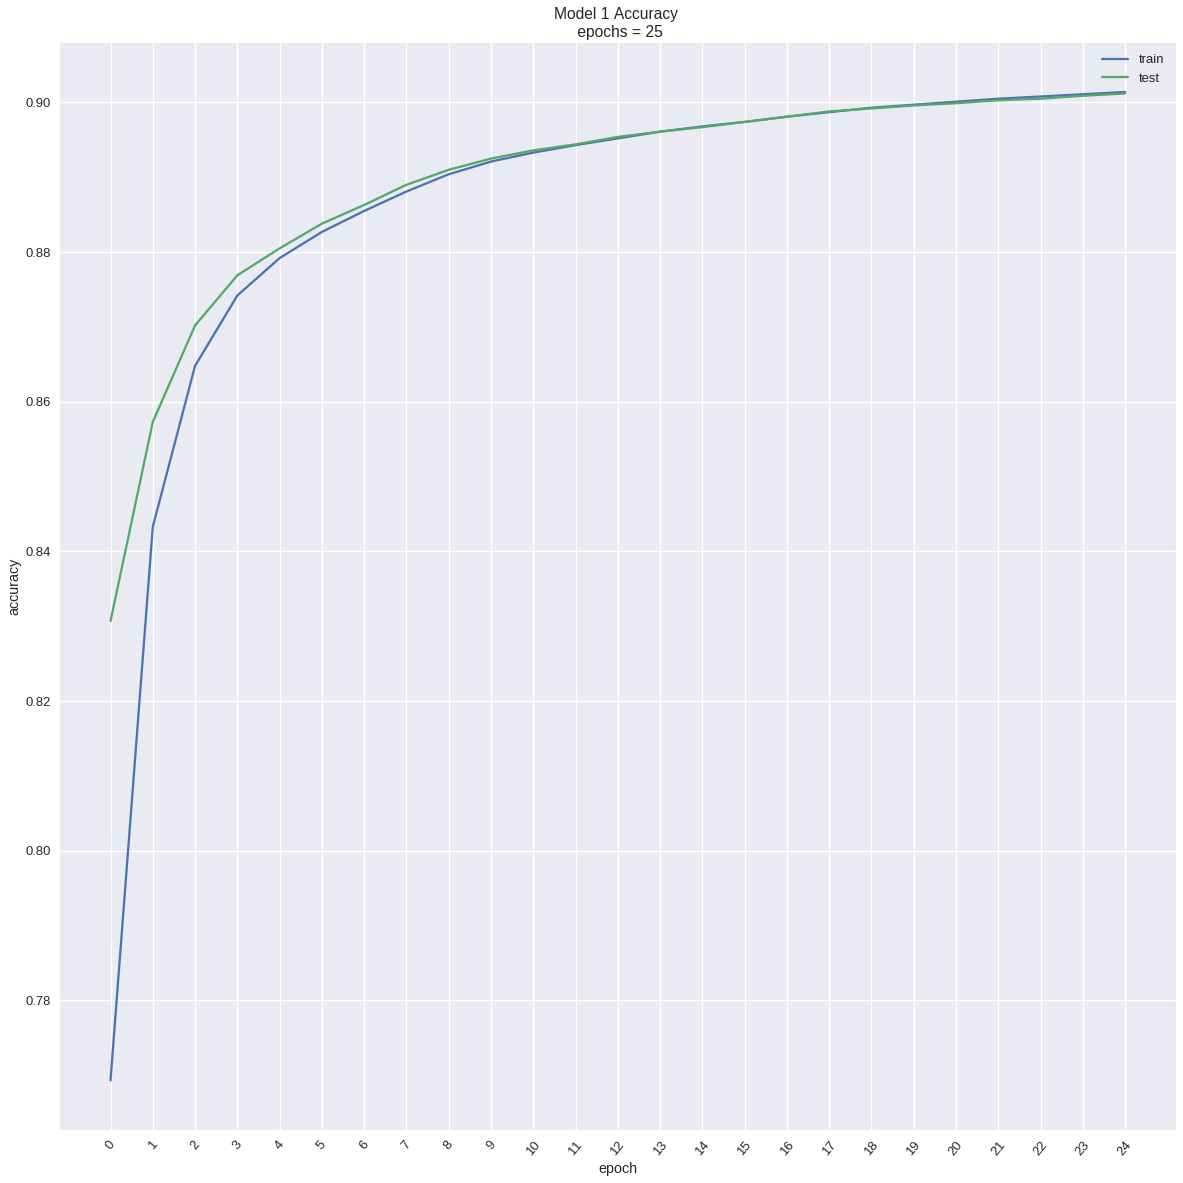

In [15]:
# Plot Accuracy
plot_metrics(training = np.load('model1_acc.npy'),
             validation= np.load('model1_valacc.npy'),
             title = 'Model 1 Accuracy \n epochs = 25', 
             ylabel = 'accuracy',
             xstep = 1)

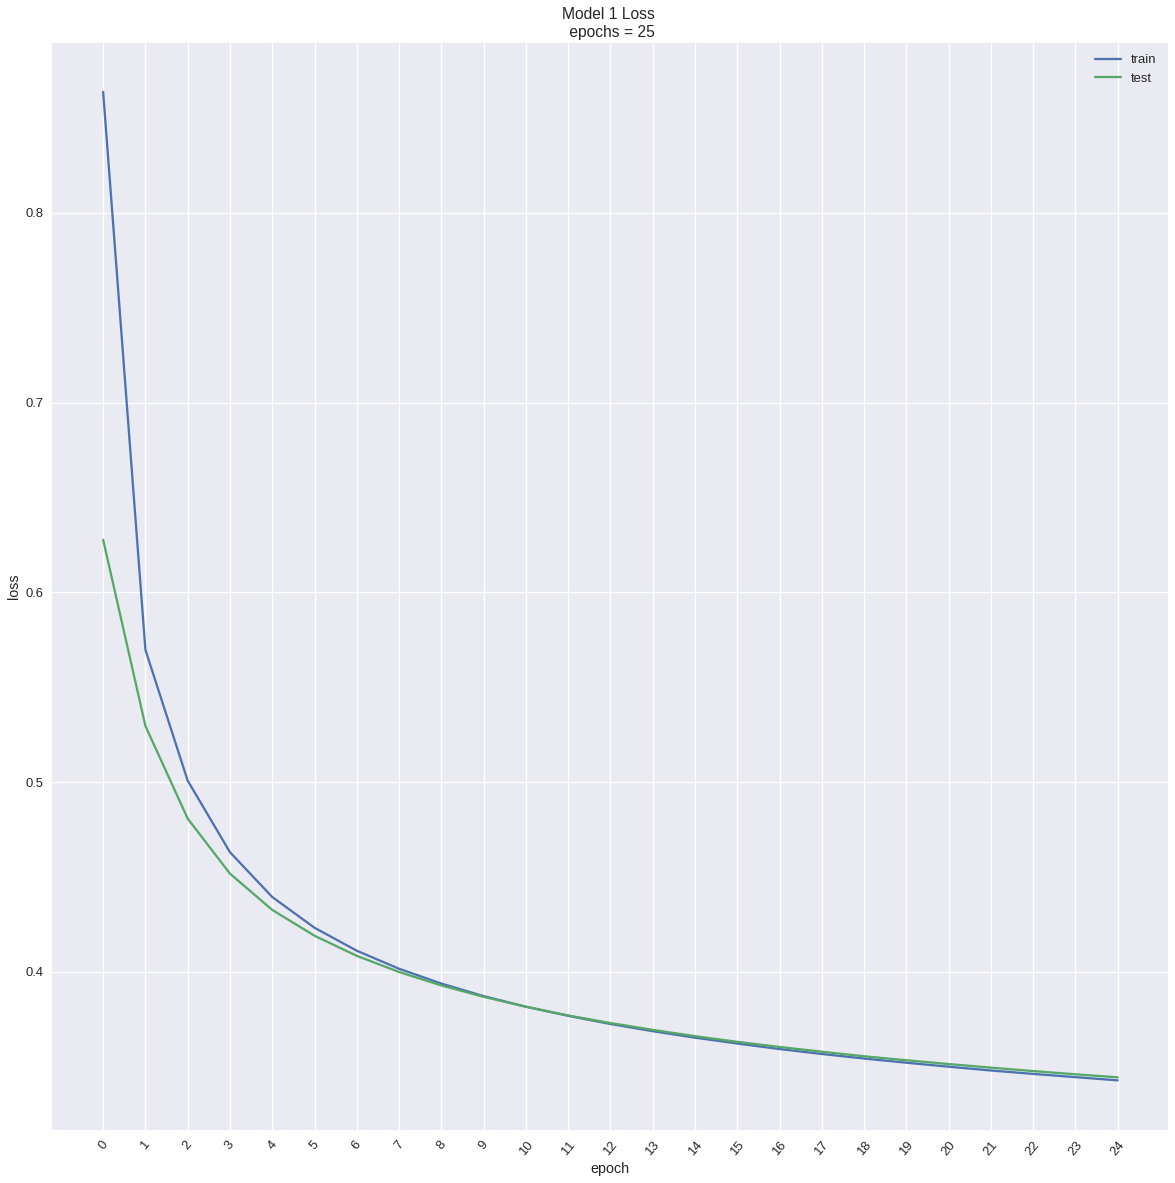

In [16]:
#Plot Loss

plot_metrics(training = np.load('model1_loss.npy'),
             validation= np.load('model1_valloss.npy'),
             title = 'Model 1 Loss \n epochs = 25', 
             ylabel = 'loss',
             xstep = 1)

**K-Fold Cross Validation**

In [106]:
#Divide data into 5 k_folds
    
kfold = KFold(n_splits = 5, shuffle=True, random_state=42)
    
# Initialize score list
    
cvscores = []

In [108]:
for train, test in kfold.split(cat_valid, num_valid, out_valid):
    
    # Categorical Inputs
    
    cat_input = Input(shape=(cat_input_cols,), dtype='int32', name='cat_input')
    
    # Embedding Layer
    
    embed = Embedding(output_dim=out_dim, input_dim=dim, input_length=cat_input_cols)(cat_input)
    
    # A flattening layer will transform the vector sequence into a single vector.
    
    flatten = Flatten()(embed)
    
    #Define numerical features input layer
    
    num_input = Input(shape=(num_cols,), name='num_input')
    
    # Input Layer. Concatenate numerical data & categorical data inputs into one input.
    
    input_layer = keras.layers.concatenate([flatten, num_input])
    
    # Dense Layers
    
    layer1 = Dense(20, activation='relu')(input_layer)
    layer2 = Dense(20, activation='relu')(layer1)
    
    # Output Layer
    
    main_output = Dense(out_cols, activation='softmax', name='main_output')(layer2)
    
    # Model
    
    modelcv = Model(inputs=[cat_input, num_input], outputs=[main_output])
    
    # Optimizer: Adam Gradient Descent
    
    adamgrad = keras.optimizers.Adagrad(lr=0.001, epsilon=None, decay=0.0)
    
    #Compile Model
    
    modelcv.compile(optimizer=adamgrad, loss={'main_output':'categorical_crossentropy'},
               metrics=['accuracy'])
    
    # Fit the model
    
    modelcv.fit({'cat_input':cat_valid[train],
               'num_input': num_valid[train]}, 
              {'main_output': out_valid[train]},
                  epochs=models_epochs, batch_size = 128,
                  shuffle = True, verbose = 1)
    
    # Evaluate the model
    
    scores = modelcv.evaluate({'cat_input':cat_valid[test], 
                             'num_input': num_valid[test]}, 
                            {'main_output': out_valid[test]}, 
                            batch_size=128, verbose=0)
    
    print("%s: %.2f%%" % (modelcv.metrics_names[1], scores[1]*100))
    
    cvscores.append(scores[1] * 100)

print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

Epoch 1/25
1339820/1339820 [==============================] - 52s 39us/step - loss: 1.6474 - acc: 0.5707
Epoch 2/25
1339820/1339820 [==============================] - 51s 38us/step - loss: 1.1086 - acc: 0.6941
Epoch 3/25
1339820/1339820 [==============================] - 51s 38us/step - loss: 0.9824 - acc: 0.7347
Epoch 4/25
1339820/1339820 [==============================] - 51s 38us/step - loss: 0.8903 - acc: 0.7564
Epoch 5/25
1339820/1339820 [==============================] - 51s 38us/step - loss: 0.8244 - acc: 0.7693
Epoch 6/25
1339820/1339820 [==============================] - 50s 38us/step - loss: 0.7758 - acc: 0.7790
Epoch 7/25
1339820/1339820 [==============================] - 50s 37us/step - loss: 0.7379 - acc: 0.7880
Epoch 8/25
1339820/1339820 [==============================] - 50s 37us/step - loss: 0.7077 - acc: 0.7971
Epoch 9/25
1339820/1339820 [==============================] - 50s 37us/step - loss: 0.6828 - acc: 0.8039
Epoch 10/25
1339820/1339820 [==========================

In [109]:
#Display CV Results

model1_cv_results = cvscores

model1_cv_results

[85.67628487451464,
 85.93661835259083,
 85.76704333416141,
 85.67091101709717,
 86.23665865619195]

In [110]:
# Save model cv 

np.save('model1_cv_accuracy.npy', model1_cv_results)

**Examine Model 1 Predictions Using Test Data**

In [36]:
# load json and create model

json_file = open("deep_learning_model1.json", 'r')

loaded_model_json = json_file.read()

json_file.close()

loaded_model = model_from_json(loaded_model_json)

# load weights into new model

loaded_model.load_weights("deep_learning_model1_weights.h5")

print("Loaded model from disk")

Loaded model from disk


In [37]:
#Model probability predictions

prob = loaded_model.predict({'cat_input':cat_test, 'num_input':num_test})

# Use argmax to pull the category with highest probability out. 

predicted = prob.argmax(axis=-1)

# Convert one-hot encoded test output data back to categorical data. 

true = out_test.argmax(axis=-1)

#Calculate Confusion Matrix

model1_cfmtx = confusion_matrix(true, predicted)

In [48]:
#Calculate accuracy by class

calculate_acc_class(confusion_matrix = model1_cfmtx)

Average accuracy by class is (without NaN & Zeroes): 0.739
Average accuracy by class is (with zeroes): 0.579


In [47]:
predict_eval = eval_confusionmatrix(confusion_matrix = model1_cfmtx)

print('False Positive Rate: ',predict_eval['False Positive Rate'])

print('True Positive Rate: ',predict_eval['True Positive Rate'])

False Positive Rate:  ('Overall:', 0.002743513250401857, 'Average:', 0.003221229269746752)
True Positive Rate:  ('Overall:', 0.9012335229855332, 'Average:', 0.5793653611596079)


/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:60: RuntimeWarning: invalid value encountered in true_divide


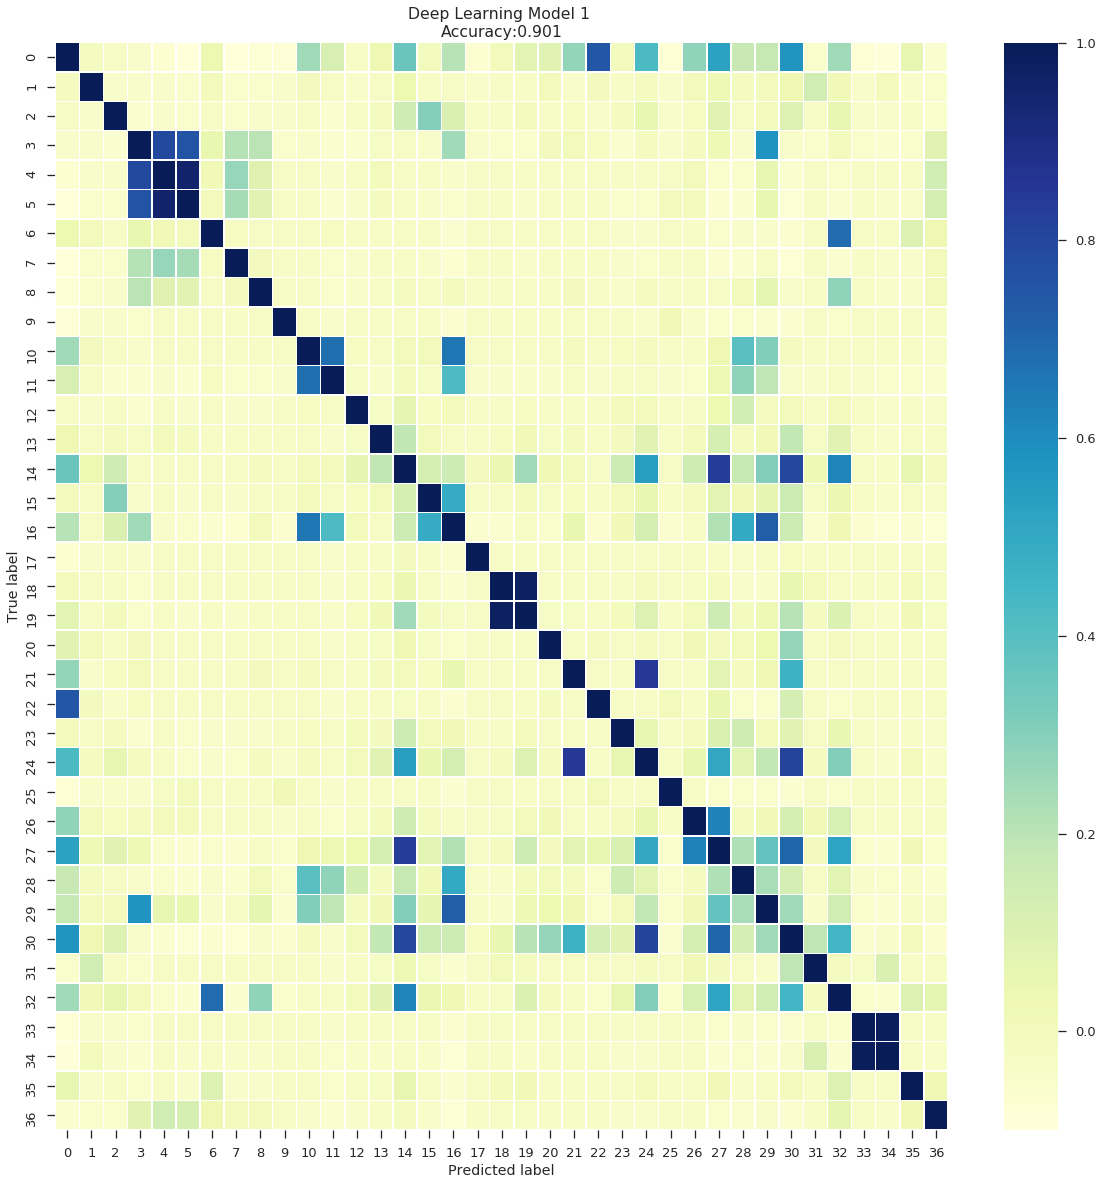

In [48]:
plot_confusion_assoc(confusion_matrix = model1_cfmtx, 
                         title ='Deep Learning Model 1 \nAccuracy:{0:.3f}'.format(accuracy_score(true, predicted)))

## `Deep Network Model 2`

*Addition of two more dense layers to model 1*

In [32]:
# Categorical Inputs

cat_input = Input(shape=(cat_input_cols,), dtype='int32', name='cat_input')

# Embedding Layer

embed = Embedding(output_dim=out_dim, input_dim=dim, input_length=cat_input_cols)(cat_input)

# A flattening layer will transform the vector sequence into a single vector.

flatten = Flatten()(embed)

#Define numerical features input layer

num_input = Input(shape=(num_cols,), name='num_input')

# Input Layer. Concatenate numerical data & categorical data inputs into one input.

input_layer = keras.layers.concatenate([flatten, num_input])


# Dense Layers

layer1 = Dense(20, activation='relu')(input_layer)
layer2 = Dense(20, activation='relu')(layer1)
layer3 = Dense(20, activation='relu')(layer2)
layer4 = Dense(20, activation='relu')(layer3)

# Output Layer

main_output = Dense(out_cols, activation='softmax', name='main_output')(layer4)

# Model

model2 = Model(inputs=[cat_input, num_input], outputs=[main_output])

# Optimizer: Adam Gradient Descent

adamgrad = keras.optimizers.Adagrad(lr=0.001, epsilon=None, decay=0.0)

#Compile Model

model2.compile(optimizer=adamgrad, loss={'main_output':'categorical_crossentropy'},
               metrics=['accuracy'])

In [33]:
%%time

# Fit Model Function

model2_hist = model2.fit({'cat_input':cat_train, 'num_input': num_train}, 
                         {'main_output': out_train},
                         validation_data = testing_data,
                         epochs=models_epochs, 
                         batch_size = 128,
                         shuffle = True, 
                         verbose = 2)

Train on 14621050 samples, validate on 319005 samples
Epoch 1/25
 - 592s - loss: 0.7873 - acc: 0.7867 - val_loss: 0.5787 - val_acc: 0.8478
Epoch 2/25
 - 596s - loss: 0.5337 - acc: 0.8597 - val_loss: 0.5048 - val_acc: 0.8692
Epoch 3/25
 - 595s - loss: 0.4856 - acc: 0.8733 - val_loss: 0.4730 - val_acc: 0.8767
Epoch 4/25
 - 596s - loss: 0.4611 - acc: 0.8785 - val_loss: 0.4541 - val_acc: 0.8805
Epoch 5/25
 - 598s - loss: 0.4452 - acc: 0.8816 - val_loss: 0.4407 - val_acc: 0.8832
Epoch 6/25
 - 601s - loss: 0.4333 - acc: 0.8845 - val_loss: 0.4307 - val_acc: 0.8857
Epoch 7/25
 - 598s - loss: 0.4246 - acc: 0.8867 - val_loss: 0.4230 - val_acc: 0.8872
Epoch 8/25
 - 599s - loss: 0.4175 - acc: 0.8879 - val_loss: 0.4165 - val_acc: 0.8885
Epoch 9/25
 - 594s - loss: 0.4115 - acc: 0.8893 - val_loss: 0.4110 - val_acc: 0.8896
Epoch 10/25
 - 601s - loss: 0.4065 - acc: 0.8904 - val_loss: 0.4064 - val_acc: 0.8905
Epoch 11/25
 - 598s - loss: 0.4021 - acc: 0.8914 - val_loss: 0.4023 - val_acc: 0.8916
Epoch 12/

**Save Model 2 Metrics and Model**

In [62]:
# Save model history metrics

np.save('model2_valloss.npy', model2_hist.history['val_loss'])
np.save('model2_loss.npy', model2_hist.history['loss'])
np.save('model2_acc.npy', model2_hist.history['acc'])
np.save('model2_valacc.npy', model2_hist.history['val_acc'])

In [66]:
# serialize model to JSON

model_json = model2.to_json()

with open("deep_learning_model2.json", "w") as json_file:
    json_file.write(model_json)

    # serialize weights to HDF5

    model2.save_weights("deep_learning_model2_weights.h5")

print("Saved model to disk")

Saved model to disk


**Accuracy of Training and Testing**

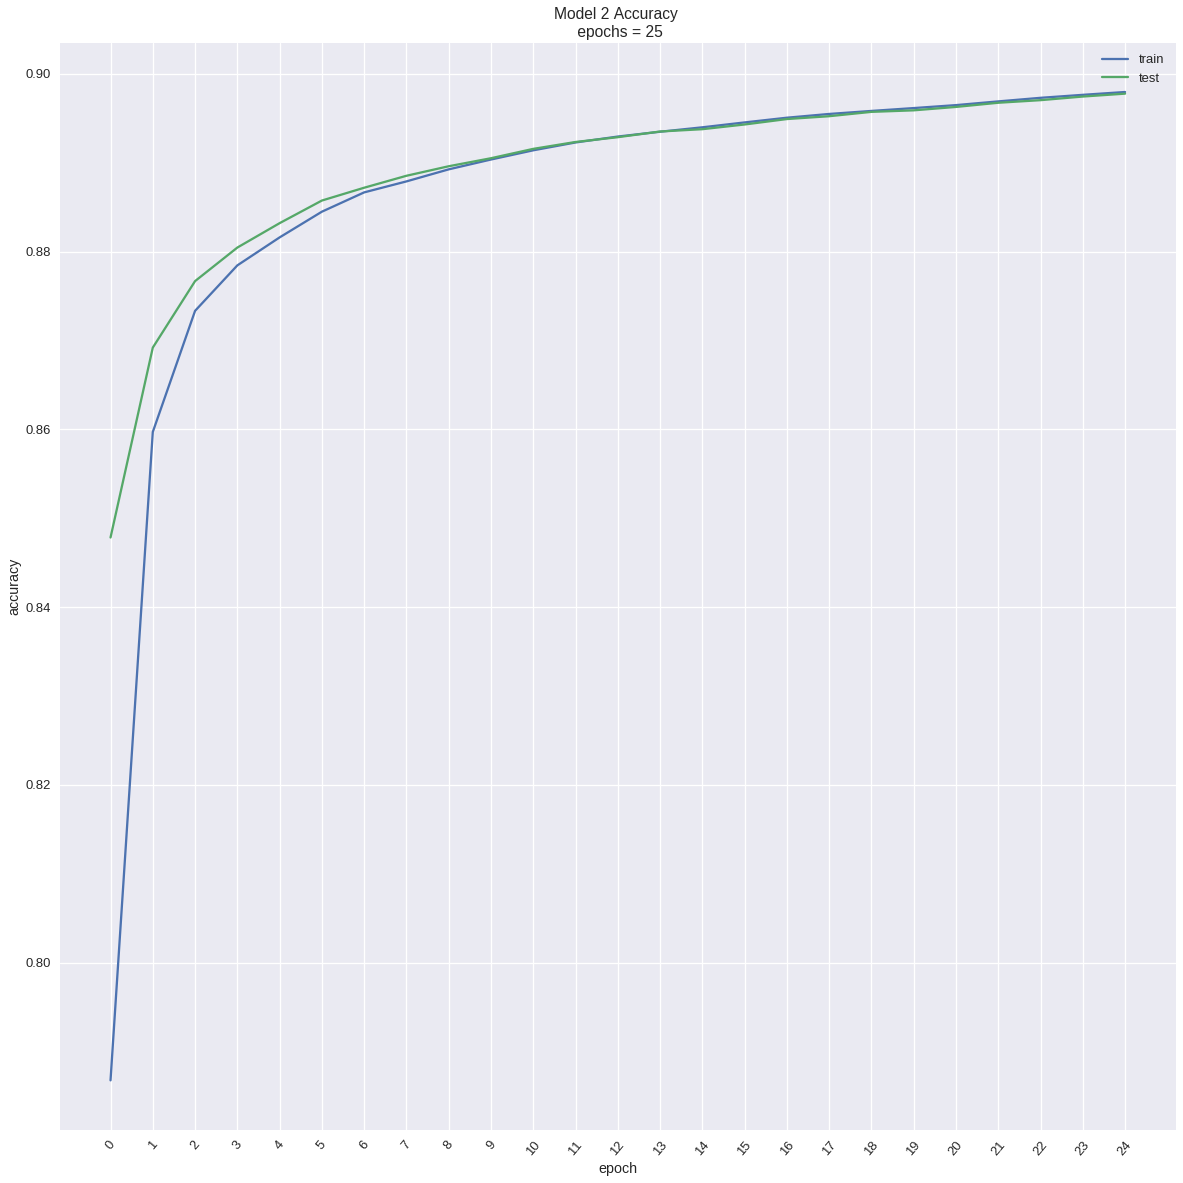

In [25]:
#Plot Accuracy

plot_metrics(training = np.load('model2_acc.npy'),
             validation= np.load('model2_valacc.npy'),
             title = 'Model 2 Accuracy \n epochs = 25', 
             ylabel = 'accuracy',
             xstep = 1)

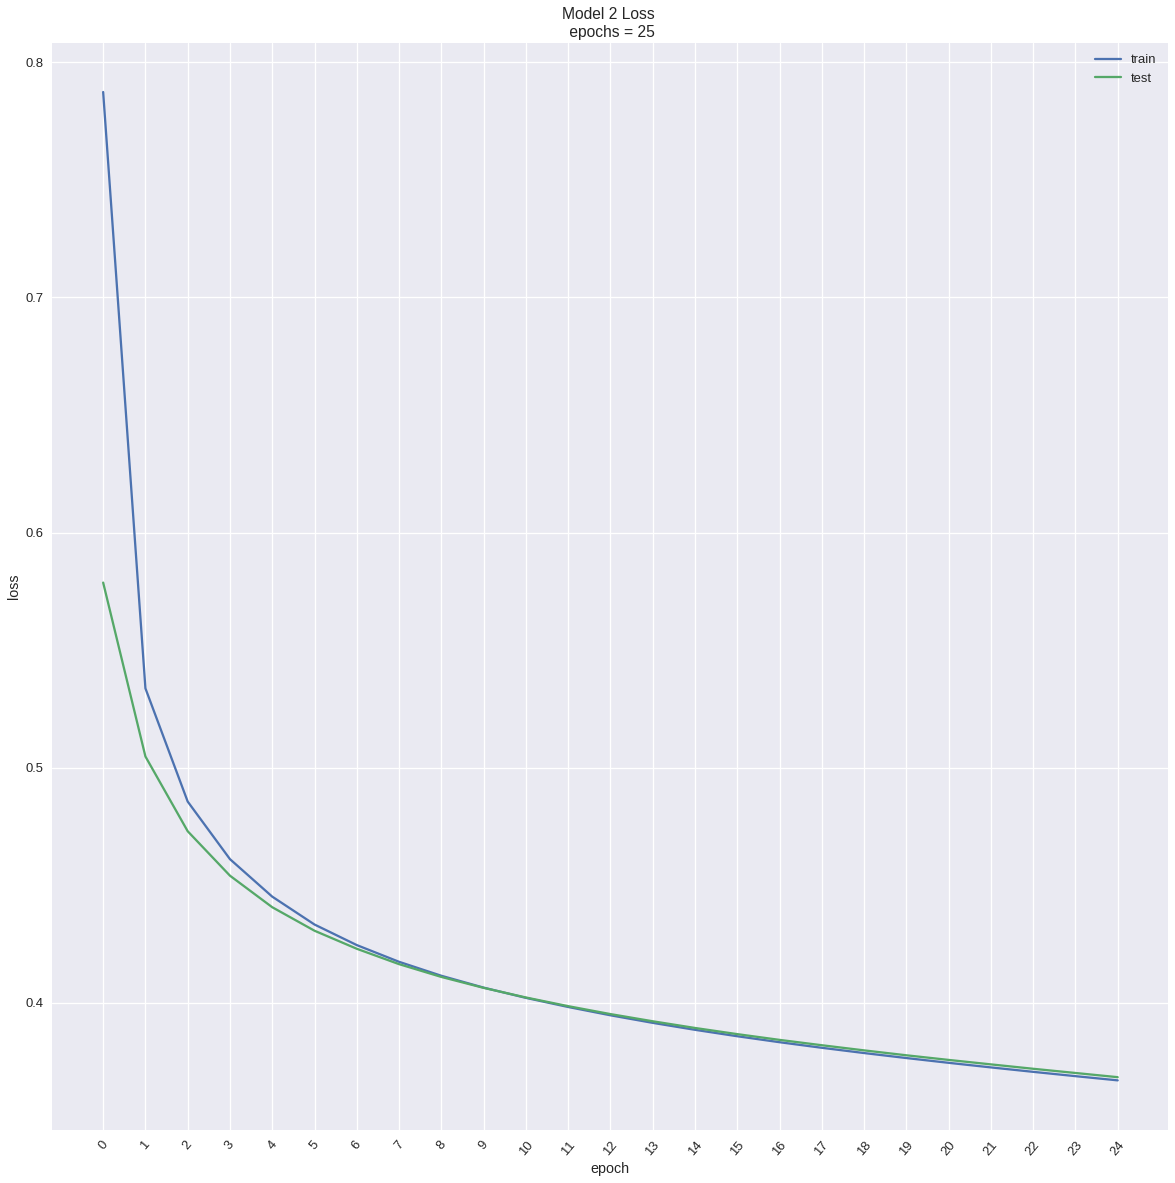

In [26]:
#Plot Loss

plot_metrics(training = np.load('model2_loss.npy'),
             validation= np.load('model2_valloss.npy'),
             title = 'Model 2 Loss \n epochs = 25', 
             ylabel = 'loss',
             xstep = 1)

**K-Fold Cross Validation**

In [13]:
#Divide data into 5 k_folds
    
kfold = KFold(n_splits = 5, shuffle=True, random_state=42)
    
# Initialize score list
    
cvscores = []

In [14]:
for train, test in kfold.split(cat_valid, num_valid, out_valid):
    
    # Categorical Inputs
    
    cat_input = Input(shape=(cat_input_cols,), dtype='int32', name='cat_input')
    
    # Embedding Layer
    
    embed = Embedding(output_dim=out_dim, input_dim=dim, input_length=cat_input_cols)(cat_input)
    
    # A flattening layer will transform the vector sequence into a single vector.
    
    flatten = Flatten()(embed)
    
    #Define numerical features input layer
    
    num_input = Input(shape=(num_cols,), name='num_input')
    
    # Input Layer. Concatenate numerical data & categorical data inputs into one input.
    
    input_layer = keras.layers.concatenate([flatten, num_input])
    
    # Dense Layers
    
    layer1 = Dense(20, activation='relu')(input_layer)
    layer2 = Dense(20, activation='relu')(layer1)
    layer3 = Dense(20, activation='relu')(layer2)
    layer4 = Dense(20, activation='relu')(layer3)
    
    # Output Layer
    
    main_output = Dense(out_cols, activation='softmax', name='main_output')(layer4)
    
    # Model
    
    modelcv = Model(inputs=[cat_input, num_input], outputs=[main_output])
    
    # Optimizer: Adam Gradient Descent
    
    adamgrad = keras.optimizers.Adagrad(lr=0.001, epsilon=None, decay=0.0)
    
    #Compile Model
    
    modelcv.compile(optimizer=adamgrad, loss={'main_output':'categorical_crossentropy'},
               metrics=['accuracy'])
    
    # Fit the model
    
    modelcv.fit({'cat_input':cat_valid[train],
               'num_input': num_valid[train]}, 
              {'main_output': out_valid[train]},
                  epochs=models_epochs, batch_size = 128,
                  shuffle = True, verbose = 1)
    
    # Evaluate the model
    
    scores = modelcv.evaluate({'cat_input':cat_valid[test], 
                             'num_input': num_valid[test]}, 
                            {'main_output': out_valid[test]}, 
                            batch_size=128, verbose=0)
    
    print("%s: %.2f%%" % (modelcv.metrics_names[1], scores[1]*100))
    
    cvscores.append(scores[1] * 100)

print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

Epoch 1/25
1339820/1339820 [==============================] - 54s 40us/step - loss: 1.5147 - acc: 0.5845
Epoch 2/25
1339820/1339820 [==============================] - 53s 39us/step - loss: 0.9614 - acc: 0.7343
Epoch 3/25
1339820/1339820 [==============================] - 53s 39us/step - loss: 0.8405 - acc: 0.7755
Epoch 4/25
1339820/1339820 [==============================] - 53s 40us/step - loss: 0.7709 - acc: 0.7968
Epoch 5/25
1339820/1339820 [==============================] - 53s 39us/step - loss: 0.7263 - acc: 0.8121
Epoch 6/25
1339820/1339820 [==============================] - 53s 39us/step - loss: 0.6961 - acc: 0.8204
Epoch 7/25
1339820/1339820 [==============================] - 53s 40us/step - loss: 0.6736 - acc: 0.8262
Epoch 8/25
1339820/1339820 [==============================] - 53s 40us/step - loss: 0.6561 - acc: 0.8317
Epoch 9/25
1339820/1339820 [==============================] - 53s 39us/step - loss: 0.6418 - acc: 0.8348
Epoch 10/25
1339820/1339820 [==========================

In [15]:
#Display CV Results

model2_cv_results = cvscores

model2_cv_results

[86.23665865494631,
 85.01559910963425,
 85.71420041496333,
 85.10904449883503,
 86.77643265456334]

In [16]:
# Save model cv 

np.save('model2_cv_accuracy.npy', model2_cv_results)

**Examine Model 2 Predictions Using Test Data**

In [50]:
# load json and create model

json_file = open("deep_learning_model2.json", 'r')

loaded_model_json = json_file.read()

json_file.close()

loaded_model = model_from_json(loaded_model_json)

# load weights into new model

loaded_model.load_weights("deep_learning_model2_weights.h5")

print("Loaded model from disk")

Loaded model from disk


In [52]:
#Model probability predictions

prob = loaded_model.predict({'cat_input':cat_test, 'num_input':num_test})

# Use argmax to pull the catoegory with highest probability out. 

predicted = prob.argmax(axis=-1)

# Convert one-hot encoded test output data back to categorical data. 

true = out_test.argmax(axis=-1)

#Calculate Confusion Matrix

model2_cfmtx = confusion_matrix(true, predicted)

In [53]:
#Calculate accuracy by class

calculate_acc_class(confusion_matrix = model2_cfmtx)

Average accuracy by class is (without NaN & Zeroes): 0.709
Average accuracy by class is (with zeroes): 0.556


In [54]:
predict_eval = eval_confusionmatrix(confusion_matrix = model2_cfmtx)

print('False Positive Rate: ',predict_eval['False Positive Rate'])

print('True Positive Rate: ',predict_eval['True Positive Rate'])

False Positive Rate:  ('Overall:', 0.0028395584186245776, 'Average:', 0.003321819277239186)
True Positive Rate:  ('Overall:', 0.8977758969295152, 'Average:', 0.5556953421541958)


/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:60: RuntimeWarning: invalid value encountered in true_divide


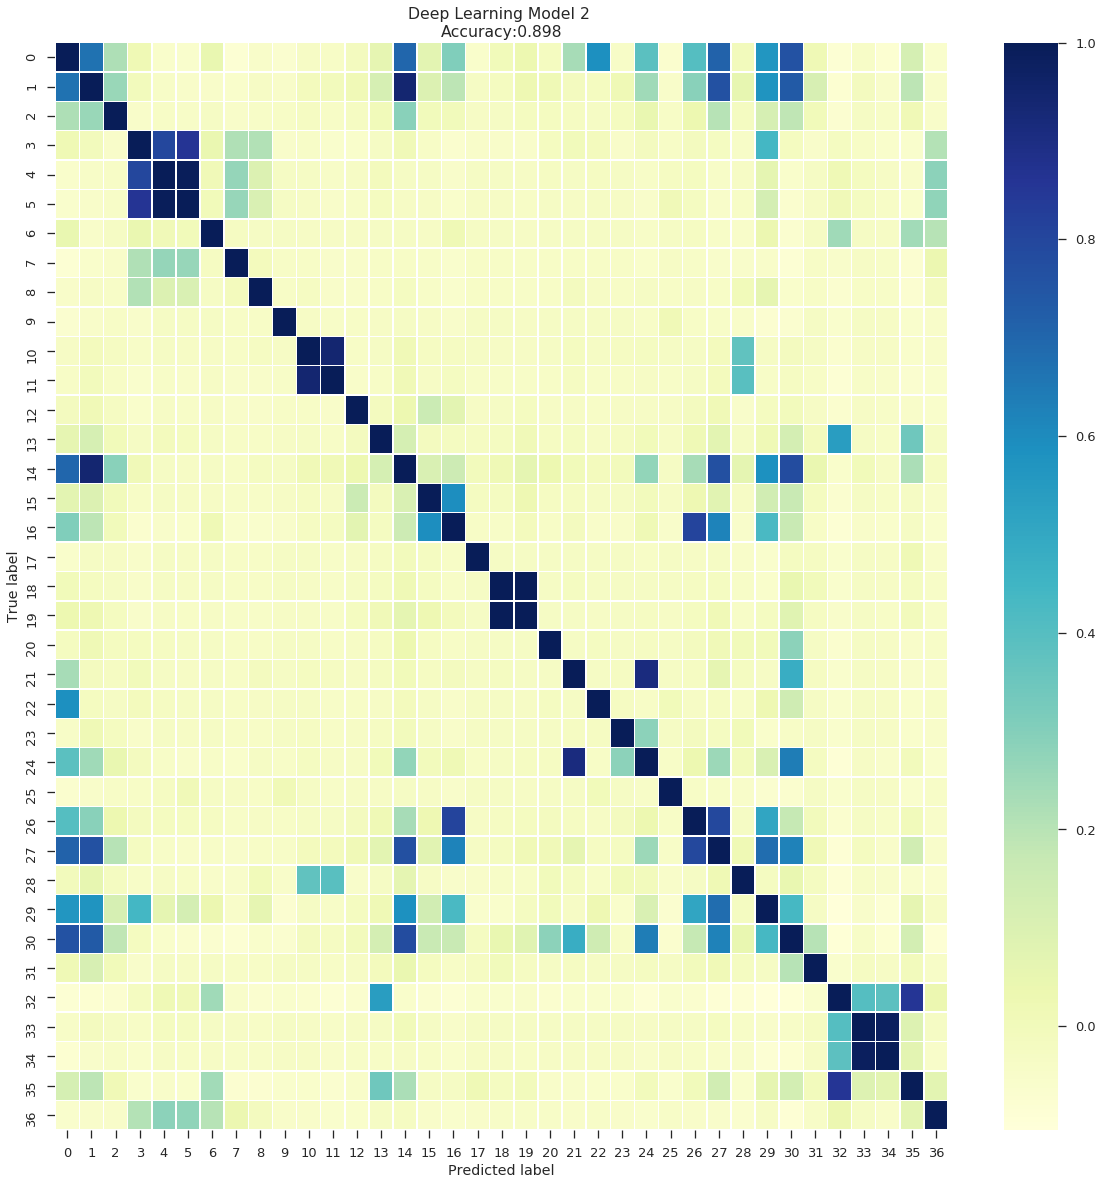

In [55]:
plot_confusion_assoc(confusion_matrix = model2_cfmtx, 
                         title ='Deep Learning Model 2 \nAccuracy:{0:.3f}'.format(accuracy_score(true, predicted)))

## `Deep Network Model 3`

*Model 1 with L2 regularization*

In [12]:
# Categorical Inputs

cat_input = Input(shape=(cat_input_cols,), dtype='int32', name='cat_input')

# Embedding Layer

embed = Embedding(output_dim=out_dim, input_dim=dim, input_length=cat_input_cols)(cat_input)

# A flattening layer will transform the vector sequence into a single vector.

flatten = Flatten()(embed)

#Define numerical features input layer

num_input = Input(shape=(num_cols,), name='num_input')

# Input Layer. Concatenate numerical data & categorical data inputs into one input.

input_layer = keras.layers.concatenate([flatten, num_input])


# Dense Layers

layer1 = Dense(20, activation='relu', kernel_regularizer= regularizers.l2(0.01))(input_layer)
layer2 = Dense(20, activation='relu', kernel_regularizer= regularizers.l2(0.01))(layer1)

# Output Layer

main_output = Dense(out_cols, activation='softmax', name='main_output')(layer2)

# Model

model3 = Model(inputs=[cat_input, num_input], outputs=[main_output])

# Optimizer: Adam Gradient Descent

adamgrad = keras.optimizers.Adagrad(lr=0.001, epsilon=None, decay=0.0)

#Compile Model

model3.compile(optimizer=adamgrad, loss={'main_output':'categorical_crossentropy'},
               metrics=['accuracy'])

In [13]:
%%time

# Fit Model Function

model3_hist = model3.fit({'cat_input':cat_train, 'num_input': num_train}, 
                         {'main_output': out_train},
                         validation_data = testing_data,
                         epochs=models_epochs, 
                         batch_size = 128,
                         shuffle = True, 
                         verbose = 2)

Train on 14621050 samples, validate on 319005 samples
Epoch 1/25
 - 494s - loss: 1.4111 - acc: 0.6647 - val_loss: 1.1562 - val_acc: 0.7093
Epoch 2/25
 - 490s - loss: 1.0781 - acc: 0.7510 - val_loss: 1.0212 - val_acc: 0.7725
Epoch 3/25
 - 489s - loss: 0.9831 - acc: 0.7800 - val_loss: 0.9536 - val_acc: 0.7854
Epoch 4/25
 - 492s - loss: 0.9300 - acc: 0.7905 - val_loss: 0.9120 - val_acc: 0.7949
Epoch 5/25
 - 491s - loss: 0.8953 - acc: 0.7968 - val_loss: 0.8832 - val_acc: 0.7994
Epoch 6/25
 - 493s - loss: 0.8701 - acc: 0.8007 - val_loss: 0.8612 - val_acc: 0.8020
Epoch 7/25
 - 491s - loss: 0.8504 - acc: 0.8031 - val_loss: 0.8435 - val_acc: 0.8046
Epoch 8/25
 - 493s - loss: 0.8341 - acc: 0.8059 - val_loss: 0.8286 - val_acc: 0.8075
Epoch 9/25
 - 492s - loss: 0.8202 - acc: 0.8092 - val_loss: 0.8157 - val_acc: 0.8113
Epoch 10/25
 - 494s - loss: 0.8080 - acc: 0.8128 - val_loss: 0.8042 - val_acc: 0.8148
Epoch 11/25
 - 493s - loss: 0.7970 - acc: 0.8159 - val_loss: 0.7936 - val_acc: 0.8183
Epoch 12/

**Save Model 3 Metrics and Model**

In [14]:
# Save model history metrics

np.save('model3_valloss.npy', model3_hist.history['val_loss'])
np.save('model3_loss.npy', model3_hist.history['loss'])
np.save('model3_acc.npy', model3_hist.history['acc'])
np.save('model3_valacc.npy', model3_hist.history['val_acc'])

In [17]:
# serialize model to JSON

model_json = model3.to_json()

with open("deep_learning_model3.json", "w") as json_file:
    json_file.write(model_json)

    # serialize weights to HDF5

    model3.save_weights("deep_learning_model3_weights.h5")

print("Saved model to disk")

Saved model to disk


**Plot Model 3 Accuracy and Loss of Training and Testing**

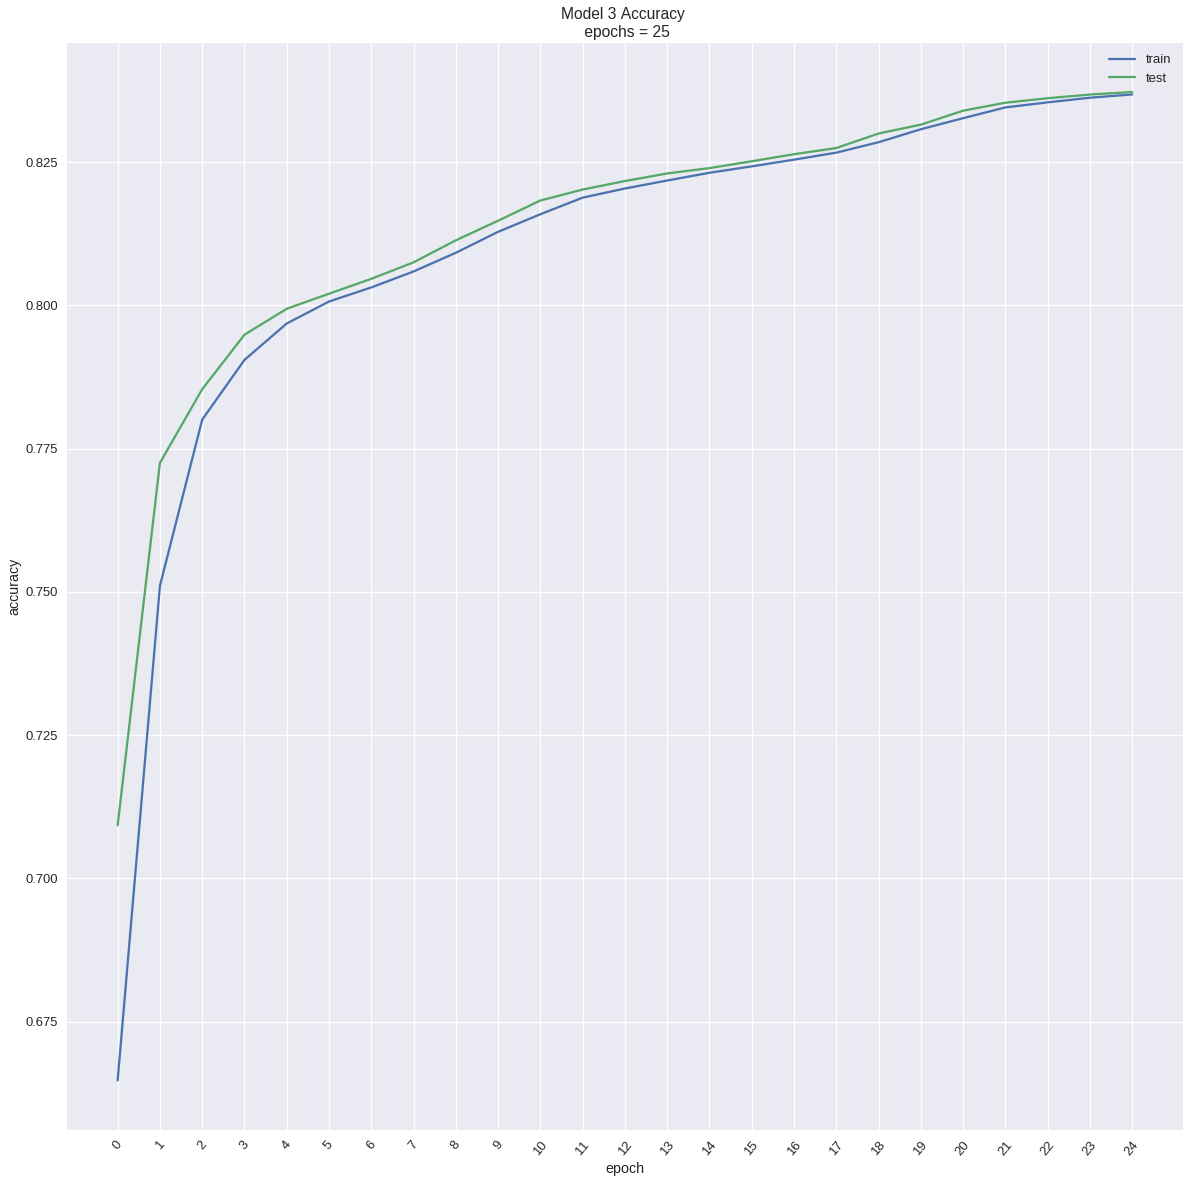

In [68]:
# Plot Accuracy
plot_metrics(training = np.load('model3_acc.npy'),
             validation= np.load('model3_valacc.npy'),
             title = 'Model 3 Accuracy \n epochs = 25', 
             ylabel = 'accuracy',
             xstep = 1)

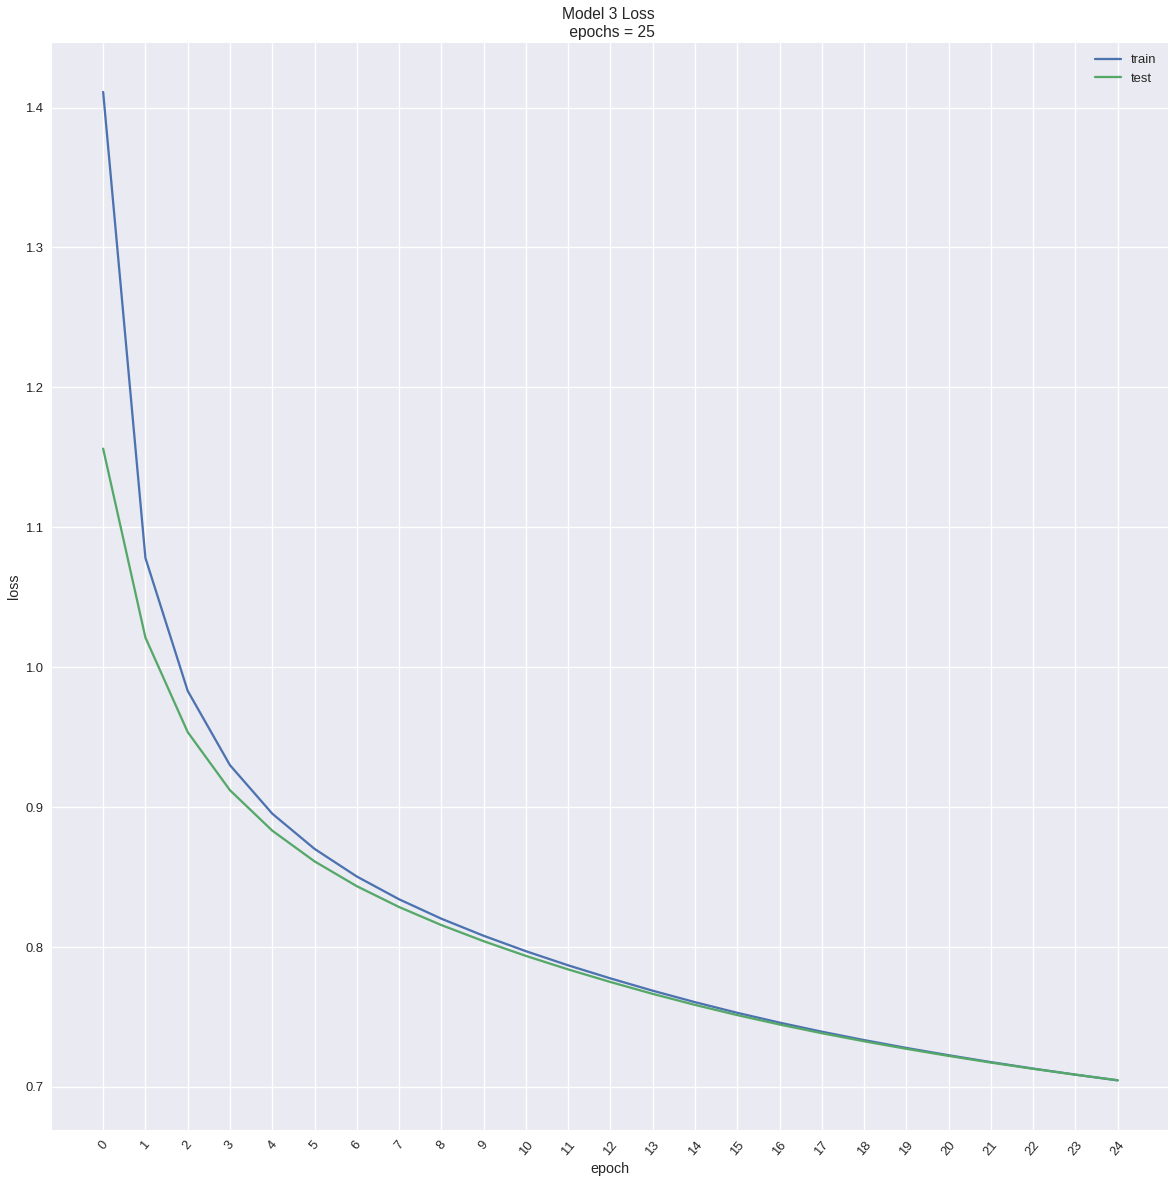

In [28]:
#Plot Loss

plot_metrics(training = np.load('model3_loss.npy'),
             validation= np.load('model3_valloss.npy'),
             title = 'Model 3 Loss \n epochs = 25', 
             ylabel = 'loss',
             xstep = 1)

**K-Fold Cross Validation**

In [26]:
#Divide data into 5 k_folds
    
kfold = KFold(n_splits = 5, shuffle=True, random_state=42)
    
# Initialize score list
    
cvscores = []

In [27]:
for train, test in kfold.split(cat_valid, num_valid, out_valid):
    
    # Categorical Inputs
    
    cat_input = Input(shape=(cat_input_cols,), dtype='int32', name='cat_input')
    
    # Embedding Layer
    
    embed = Embedding(output_dim=out_dim, input_dim=dim, input_length=cat_input_cols)(cat_input)
    
    # A flattening layer will transform the vector sequence into a single vector.
    
    flatten = Flatten()(embed)
    
    #Define numerical features input layer
    
    num_input = Input(shape=(num_cols,), name='num_input')
    
    # Input Layer. Concatenate numerical data & categorical data inputs into one input.
    
    input_layer = keras.layers.concatenate([flatten, num_input])
    
    # Dense Layers
    
    layer1 = Dense(20, activation='relu',kernel_regularizer=regularizers.l2(0.01))(input_layer)
    layer2 = Dense(20, activation='relu',kernel_regularizer=regularizers.l2(0.01))(layer1)
    
    # Output Layer
    
    main_output = Dense(out_cols, activation='softmax', name='main_output')(layer2)
    
    # Model
    
    modelcv = Model(inputs=[cat_input, num_input], outputs=[main_output])
    
    # Optimizer: Adam Gradient Descent
    
    adamgrad = keras.optimizers.Adagrad(lr=0.001, epsilon=None, decay=0.0)
    
    #Compile Model
    
    modelcv.compile(optimizer=adamgrad, loss={'main_output':'categorical_crossentropy'},
               metrics=['accuracy'])
    
    # Fit the model
    
    modelcv.fit({'cat_input':cat_valid[train],
               'num_input': num_valid[train]}, 
              {'main_output': out_valid[train]},
                  epochs=models_epochs, batch_size = 128,
                  shuffle = True, verbose = 1)
    
    # Evaluate the model
    
    scores = modelcv.evaluate({'cat_input':cat_valid[test], 
                             'num_input': num_valid[test]}, 
                            {'main_output': out_valid[test]}, 
                            batch_size=128, verbose=0)
    
    print("%s: %.2f%%" % (modelcv.metrics_names[1], scores[1]*100))
    
    cvscores.append(scores[1] * 100)

print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

Epoch 1/25
1339820/1339820 [==============================] - 50s 38us/step - loss: 2.2038 - acc: 0.4918
Epoch 2/25
1339820/1339820 [==============================] - 50s 37us/step - loss: 1.6304 - acc: 0.6152
Epoch 3/25
1339820/1339820 [==============================] - 49s 37us/step - loss: 1.4547 - acc: 0.6785
Epoch 4/25
1339820/1339820 [==============================] - 49s 37us/step - loss: 1.3614 - acc: 0.7073
Epoch 5/25
1339820/1339820 [==============================] - 49s 37us/step - loss: 1.2975 - acc: 0.7216
Epoch 6/25
1339820/1339820 [==============================] - 49s 37us/step - loss: 1.2477 - acc: 0.7287
Epoch 7/25
1339820/1339820 [==============================] - 49s 37us/step - loss: 1.2076 - acc: 0.7339
Epoch 8/25
1339820/1339820 [==============================] - 49s 37us/step - loss: 1.1730 - acc: 0.7411
Epoch 9/25
1339820/1339820 [==============================] - 49s 37us/step - loss: 1.1413 - acc: 0.7546
Epoch 10/25
1339820/1339820 [==========================

In [28]:
#Display CV Results

model3_cv_results = cvscores

model3_cv_results

[80.33198489335079,
 78.17796420322149,
 79.88177516357885,
 77.01840545753849,
 77.16558940717645]

In [29]:
# Save model cv 

np.save('model3_cv_accuracy.npy', model3_cv_results)

**Examine Model 3 Predictions Using Test Data**

In [67]:
# load json and create model

json_file = open("deep_learning_model3.json", 'r')

loaded_model_json = json_file.read()

json_file.close()

loaded_model = model_from_json(loaded_model_json)

# load weights into new model

loaded_model.load_weights("deep_learning_model3_weights.h5")

print("Loaded model from disk")

Loaded model from disk


In [68]:
#Model probability predictions

prob = loaded_model.predict({'cat_input':cat_test, 'num_input':num_test})

# Use argmax to pull the catoegory with highest probability out. 

predicted = prob.argmax(axis=-1)

# Convert one-hot encoded test output data back to categorical data. 

true = out_test.argmax(axis=-1)

#Calculate Confusion Matrix

model3_cfmtx = confusion_matrix(true, predicted)

In [69]:
#Calculate accuracy by class

calculate_acc_class(confusion_matrix = model3_cfmtx)

Average accuracy by class is (without NaN & Zeroes): 0.651
Average accuracy by class is (with zeroes): 0.317


In [70]:
predict_eval = eval_confusionmatrix(confusion_matrix = model3_cfmtx)

print('False Positive Rate: ',predict_eval['False Positive Rate'])

print('True Positive Rate: ',predict_eval['True Positive Rate'])

False Positive Rate:  ('Overall:', 0.004521611468994739, 'Average:', 0.005278225887985056)
True Positive Rate:  ('Overall:', 0.8372219871161894, 'Average:', 0.3169203247891843)


/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:60: RuntimeWarning: invalid value encountered in true_divide


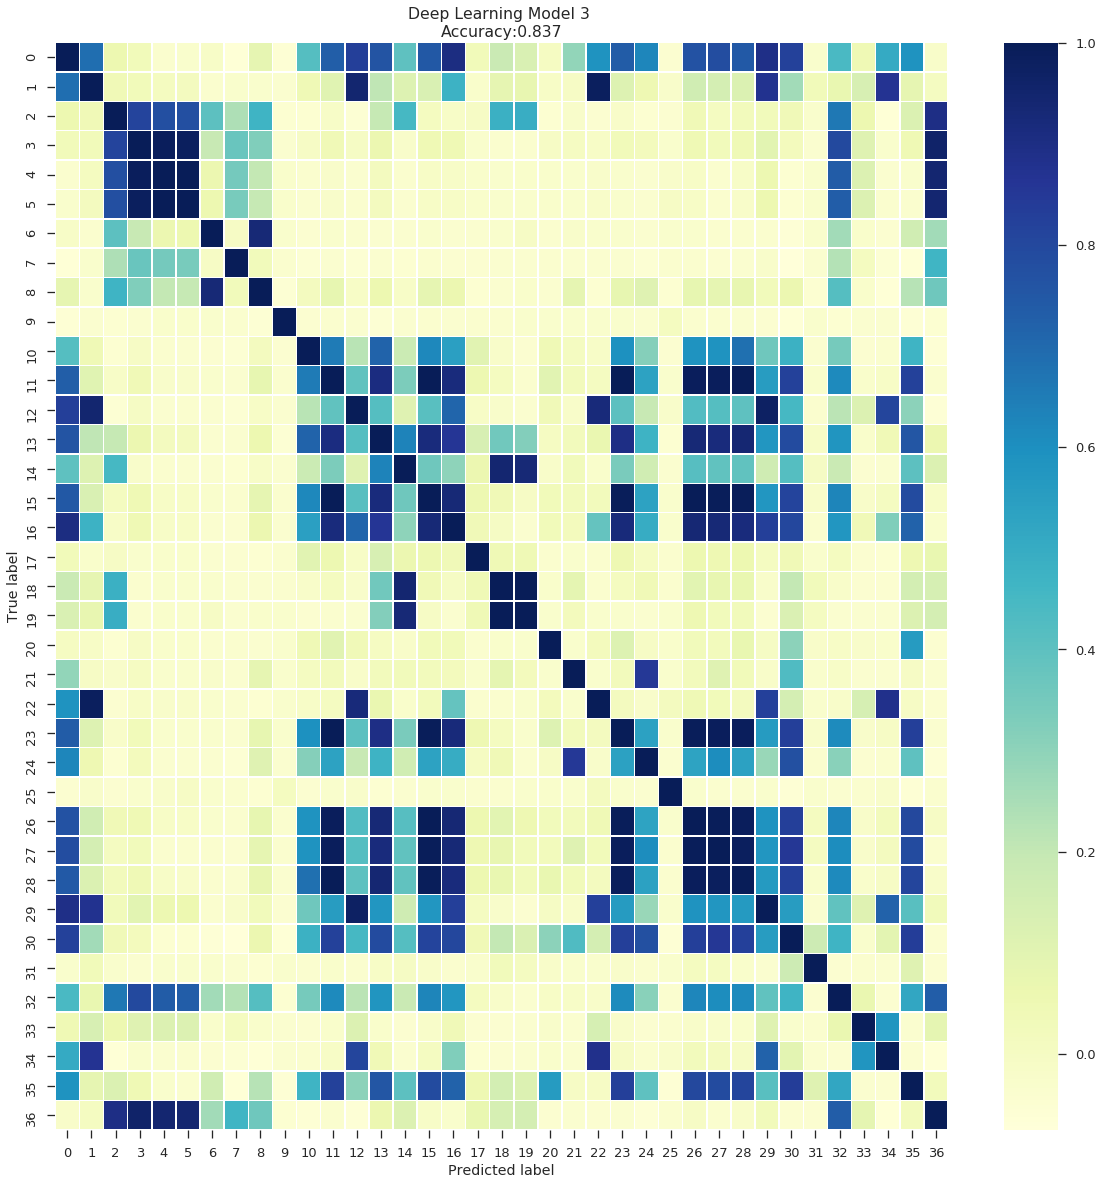

In [71]:
plot_confusion_assoc(confusion_matrix = model3_cfmtx, 
                         title ='Deep Learning Model 3 \nAccuracy:{0:.3f}'.format(accuracy_score(true, predicted)))

## `Deep Network Model 4`

*Addition of two more dense layers to model 2*

In [15]:
# Categorical Inputs

cat_input = Input(shape=(cat_input_cols,), dtype='int32', name='cat_input')

# Embedding Layer

embed = Embedding(output_dim=out_dim, input_dim=dim, input_length=cat_input_cols)(cat_input)

# A flattening layer will transform the vector sequence into a single vector.

flatten = Flatten()(embed)

#Define numerical features input layer

num_input = Input(shape=(num_cols,), name='num_input')

# Input Layer. Concatenate numerical data & categorical data inputs into one input.

input_layer = keras.layers.concatenate([flatten, num_input])


# Dense Layers

layer1 = Dense(20, activation='relu')(input_layer)
layer2 = Dense(20, activation='relu')(layer1)
layer3 = Dense(20, activation='relu')(layer2)
layer4 = Dense(20, activation='relu')(layer3)
layer5 = Dense(20, activation='relu')(layer4)
layer6 = Dense(20, activation='relu')(layer5)

# Output Layer

main_output = Dense(out_cols, activation='softmax', name='main_output')(layer6)

# Model

model4 = Model(inputs=[cat_input, num_input], outputs=[main_output])

# Optimizer: Adam Gradient Descent

adamgrad = keras.optimizers.Adagrad(lr=0.001, epsilon=None, decay=0.0)

#Compile Model

model4.compile(optimizer=adamgrad, loss={'main_output':'categorical_crossentropy'},
               metrics=['accuracy'])

In [16]:
%%time

# Fit Model Function

model4_hist = model4.fit({'cat_input':cat_train, 'num_input': num_train}, 
                         {'main_output': out_train},
                         validation_data = testing_data,
                         epochs=models_epochs, 
                         batch_size = 128,
                         shuffle = True, 
                         verbose = 2)

Train on 14621050 samples, validate on 319005 samples
Epoch 1/25
 - 694s - loss: 0.8195 - acc: 0.7744 - val_loss: 0.6270 - val_acc: 0.8400
Epoch 2/25
 - 696s - loss: 0.5677 - acc: 0.8561 - val_loss: 0.5310 - val_acc: 0.8654
Epoch 3/25
 - 696s - loss: 0.5089 - acc: 0.8684 - val_loss: 0.4945 - val_acc: 0.8718
Epoch 4/25
 - 696s - loss: 0.4822 - acc: 0.8736 - val_loss: 0.4749 - val_acc: 0.8755
Epoch 5/25
 - 695s - loss: 0.4666 - acc: 0.8765 - val_loss: 0.4622 - val_acc: 0.8781
Epoch 6/25
 - 696s - loss: 0.4559 - acc: 0.8787 - val_loss: 0.4530 - val_acc: 0.8799
Epoch 7/25
 - 695s - loss: 0.4478 - acc: 0.8805 - val_loss: 0.4458 - val_acc: 0.8816
Epoch 8/25
 - 698s - loss: 0.4413 - acc: 0.8817 - val_loss: 0.4398 - val_acc: 0.8826
Epoch 9/25
 - 696s - loss: 0.4358 - acc: 0.8827 - val_loss: 0.4349 - val_acc: 0.8835
Epoch 10/25
 - 697s - loss: 0.4313 - acc: 0.8836 - val_loss: 0.4307 - val_acc: 0.8843
Epoch 11/25
 - 696s - loss: 0.4273 - acc: 0.8844 - val_loss: 0.4270 - val_acc: 0.8851
Epoch 12/

**Save Model 4 Metrics and Model**

In [18]:
# Save model history metrics

np.save('model4_valloss.npy', model4_hist.history['val_loss'])
np.save('model4_loss.npy', model4_hist.history['loss'])
np.save('model4_acc.npy', model4_hist.history['acc'])
np.save('model4_valacc.npy', model4_hist.history['val_acc'])

In [19]:
# serialize model to JSON

model_json = model4.to_json()

with open("deep_learning_model4.json", "w") as json_file:
    json_file.write(model_json)

    # serialize weights to HDF5

    model4.save_weights("deep_learning_model4_weights.h5")

print("Saved model to disk")

Saved model to disk


**Accuracy of Training and Testing**

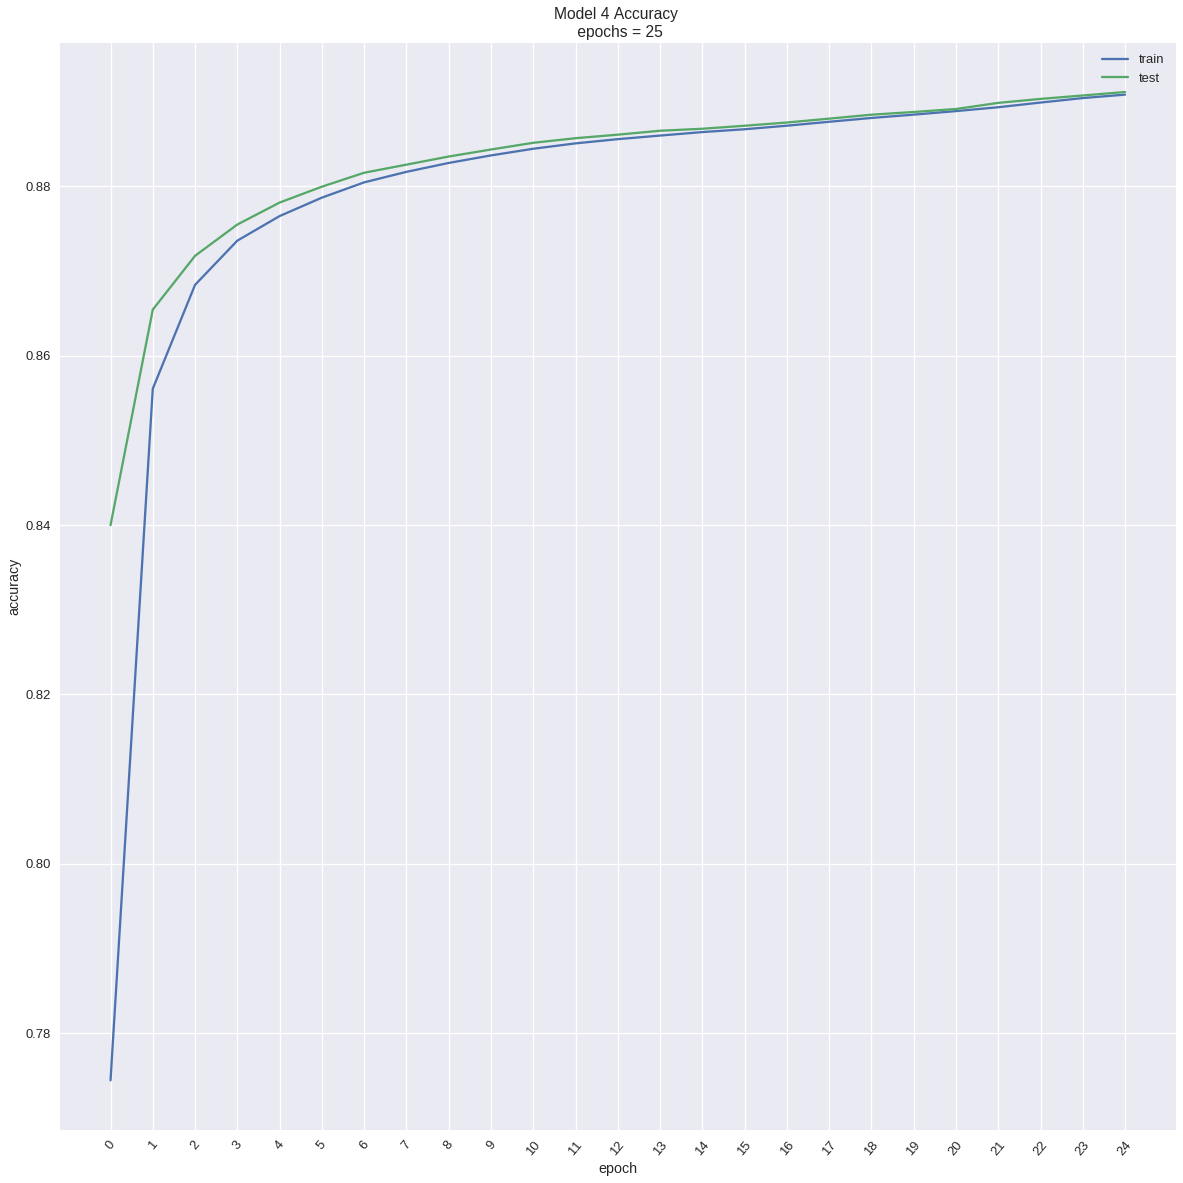

In [17]:
#Plot Accuracy

plot_metrics(training = np.load('model4_acc.npy'),
             validation= np.load('model4_valacc.npy'),
             title = 'Model 4 Accuracy \n epochs = 25', 
             ylabel = 'accuracy',
             xstep = 1)

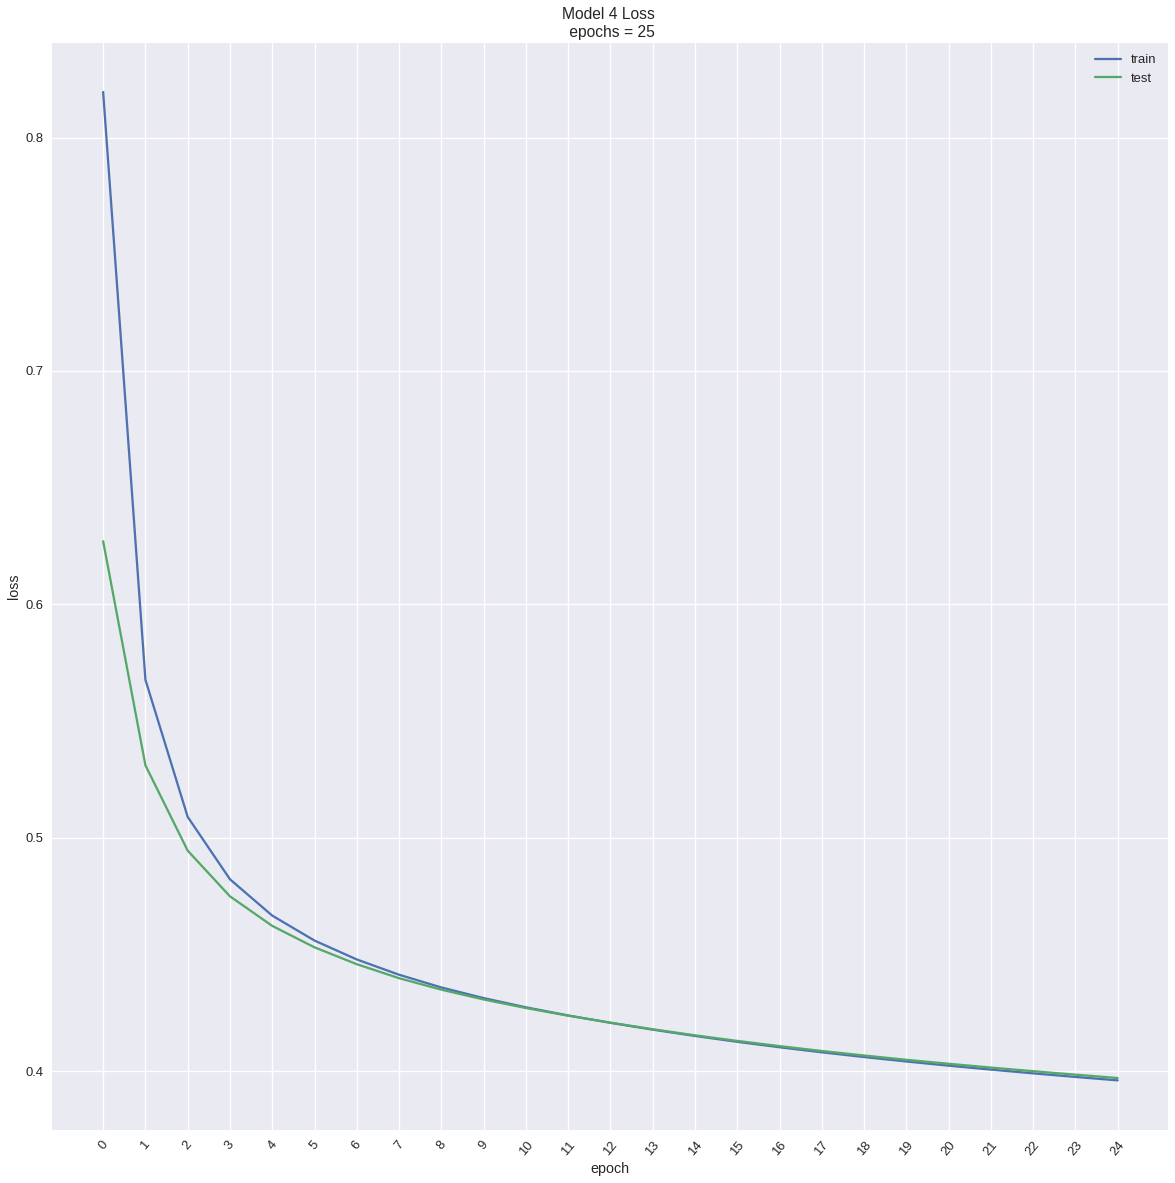

In [18]:
#Plot Loss

plot_metrics(training = np.load('model4_loss.npy'),
             validation= np.load('model4_valloss.npy'),
             title = 'Model 4 Loss \n epochs = 25', 
             ylabel = 'loss',
             xstep = 1)

**K-Fold Cross Validation**

In [19]:
#Divide data into 5 k_folds
    
kfold = KFold(n_splits = 5, shuffle=True, random_state=42)
    
# Initialize score list
    
cvscores = []

In [20]:
for train, test in kfold.split(cat_valid, num_valid, out_valid):
    
    # Categorical Inputs
    
    cat_input = Input(shape=(cat_input_cols,), dtype='int32', name='cat_input')
    
    # Embedding Layer
    
    embed = Embedding(output_dim=out_dim, input_dim=dim, input_length=cat_input_cols)(cat_input)
    
    # A flattening layer will transform the vector sequence into a single vector.
    
    flatten = Flatten()(embed)
    
    #Define numerical features input layer
    
    num_input = Input(shape=(num_cols,), name='num_input')
    
    # Input Layer. Concatenate numerical data & categorical data inputs into one input.
    
    input_layer = keras.layers.concatenate([flatten, num_input])
    
    # Dense Layers
    
    layer1 = Dense(20, activation='relu')(input_layer)
    layer2 = Dense(20, activation='relu')(layer1)
    layer3 = Dense(20, activation='relu')(layer2)
    layer4 = Dense(20, activation='relu')(layer3)
    layer5 = Dense(20, activation='relu')(layer4)
    layer6 = Dense(20, activation='relu')(layer5)
    
    # Output Layer
    
    main_output = Dense(out_cols, activation='softmax', name='main_output')(layer6)
    
    # Model
    
    modelcv = Model(inputs=[cat_input, num_input], outputs=[main_output])
    
    # Optimizer: Adam Gradient Descent
    
    adamgrad = keras.optimizers.Adagrad(lr=0.001, epsilon=None, decay=0.0)
    
    #Compile Model
    
    modelcv.compile(optimizer=adamgrad, loss={'main_output':'categorical_crossentropy'},
               metrics=['accuracy'])
    
    # Fit the model
    
    modelcv.fit({'cat_input':cat_valid[train],
               'num_input': num_valid[train]}, 
              {'main_output': out_valid[train]},
                  epochs=models_epochs, batch_size = 128,
                  shuffle = True, verbose = 1)
    
    # Evaluate the model
    
    scores = modelcv.evaluate({'cat_input':cat_valid[test], 
                             'num_input': num_valid[test]}, 
                            {'main_output': out_valid[test]}, 
                            batch_size=128, verbose=0)
    
    print("%s: %.2f%%" % (modelcv.metrics_names[1], scores[1]*100))
    
    cvscores.append(scores[1] * 100)

print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

Epoch 1/25
1339820/1339820 [==============================] - 65s 49us/step - loss: 1.4693 - acc: 0.5575
Epoch 2/25
1339820/1339820 [==============================] - 65s 48us/step - loss: 1.0268 - acc: 0.6821
Epoch 3/25
1339820/1339820 [==============================] - 65s 49us/step - loss: 0.8508 - acc: 0.7590
Epoch 4/25
1339820/1339820 [==============================] - 65s 48us/step - loss: 0.7768 - acc: 0.7790
Epoch 5/25
1339820/1339820 [==============================] - 65s 48us/step - loss: 0.7326 - acc: 0.7905
Epoch 6/25
1339820/1339820 [==============================] - 65s 48us/step - loss: 0.7034 - acc: 0.8016
Epoch 7/25
1339820/1339820 [==============================] - 65s 49us/step - loss: 0.6823 - acc: 0.8123
Epoch 8/25
1339820/1339820 [==============================] - 65s 48us/step - loss: 0.6656 - acc: 0.8203
Epoch 9/25
1339820/1339820 [==============================] - 65s 49us/step - loss: 0.6515 - acc: 0.8275
Epoch 10/25
1339820/1339820 [==========================

In [21]:
#Display CV Results

model4_cv_results = cvscores

model4_cv_results

[85.71181203375839,
 85.59776686351164,
 86.69851173958227,
 85.79271842429361,
 85.67658342074613]

In [22]:
# Save model cv 

np.save('model4_cv_accuracy.npy', model4_cv_results)

**Examine Model 4 Predictions Using Testing Data**

In [72]:
# load json and create model

json_file = open("deep_learning_model4.json", 'r')

loaded_model_json = json_file.read()

json_file.close()

loaded_model = model_from_json(loaded_model_json)

# load weights into new model

loaded_model.load_weights("deep_learning_model4_weights.h5")

print("Loaded model from disk")

Loaded model from disk


In [73]:
#Model probability predictions

prob = loaded_model.predict({'cat_input':cat_test, 'num_input':num_test})

# Use argmax to pull the catoegory with highest probability out. 

predicted = prob.argmax(axis=-1)

# Convert one-hot encoded test output data back to categorical data. 

true = out_test.argmax(axis=-1)

#Calculate Confusion Matrix

model4_cfmtx = confusion_matrix(true, predicted)

In [74]:
#Calculate accuracy by class

calculate_acc_class(confusion_matrix = model4_cfmtx)

Average accuracy by class is (without NaN & Zeroes): 0.726
Average accuracy by class is (with zeroes): 0.491


In [75]:
predict_eval = eval_confusionmatrix(confusion_matrix = model4_cfmtx)

print('False Positive Rate: ',predict_eval['False Positive Rate'])

print('True Positive Rate: ',predict_eval['True Positive Rate'])

False Positive Rate:  ('Overall:', 0.0030242472688515854, 'Average:', 0.0035084380580109515)
True Positive Rate:  ('Overall:', 0.891127098321343, 'Average:', 0.49085846312852816)


/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:60: RuntimeWarning: invalid value encountered in true_divide


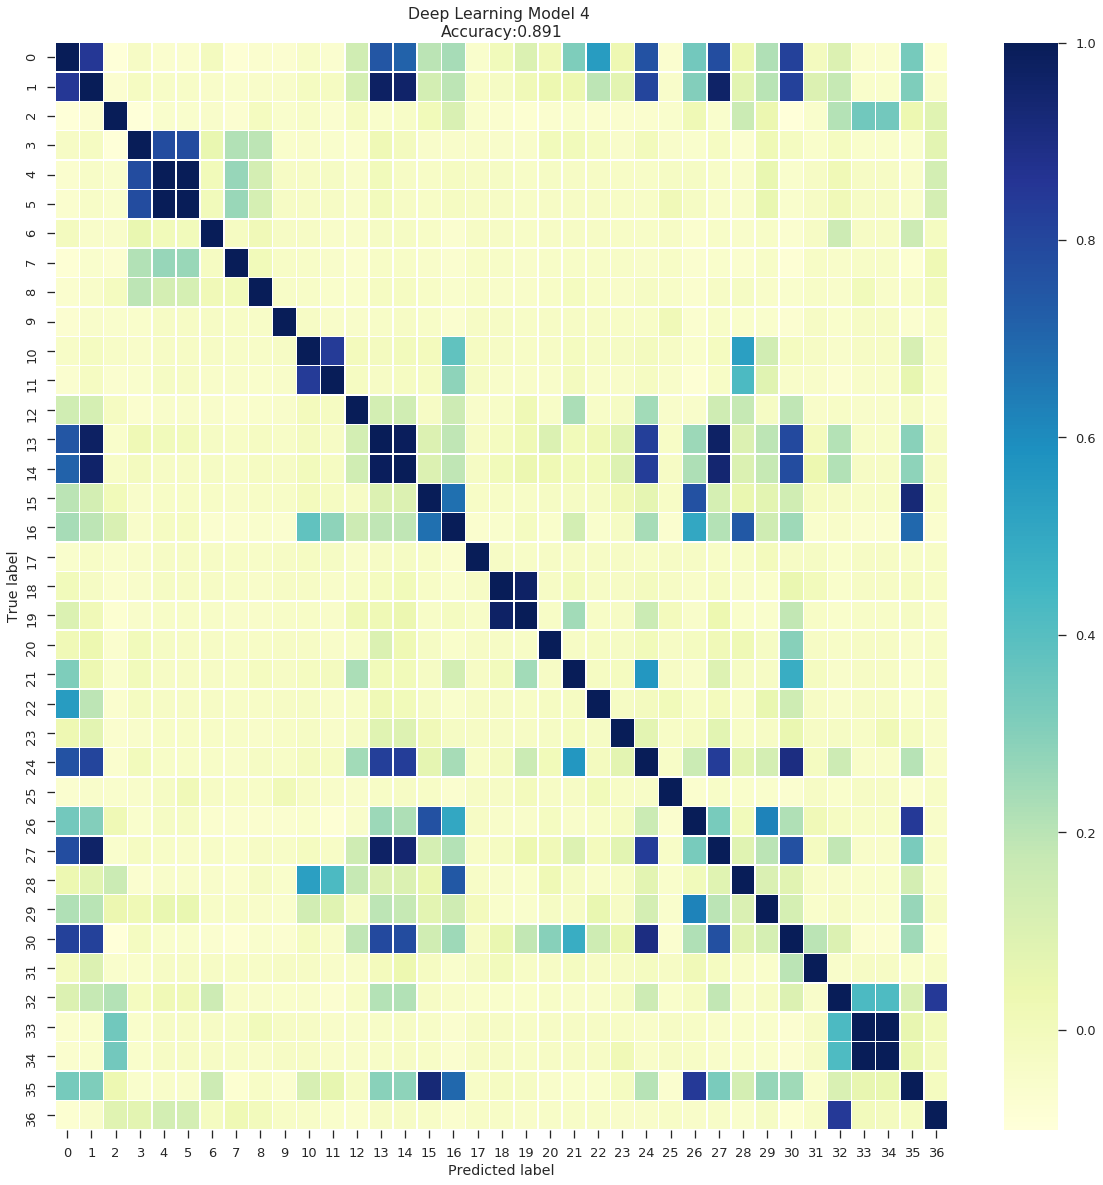

In [76]:
plot_confusion_assoc(confusion_matrix = model4_cfmtx, 
                         title ='Deep Learning Model 4 \nAccuracy:{0:.3f}'.format(accuracy_score(true, predicted)))

## `Deep Network Model 5`

*Model 1 with L1 regularization in the input and deep layers*

In [23]:
# Categorical Inputs

cat_input = Input(shape=(cat_input_cols,), dtype='int32', name='cat_input')

# Embedding Layer

embed = Embedding(output_dim=out_dim, input_dim=dim, input_length=cat_input_cols)(cat_input)

# A flattening layer will transform the vector sequence into a single vector.

flatten = Flatten()(embed)

#Define numerical features input layer

num_input = Input(shape=(num_cols,), name='num_input')

# Input Layer. Concatenate numerical data & categorical data inputs into one input.

input_layer = keras.layers.concatenate([flatten, num_input])


# Dense Layers

layer1 = Dense(20, activation='relu', kernel_regularizer= regularizers.l1(0.01))(input_layer)
layer2 = Dense(20, activation='relu', kernel_regularizer= regularizers.l1(0.01))(layer1)

# Output Layer

main_output = Dense(out_cols, activation='softmax', name='main_output')(layer2)

# Model

model5 = Model(inputs=[cat_input, num_input], outputs=[main_output])

# Optimizer: Adam Gradient Descent

adamgrad = keras.optimizers.Adagrad(lr=0.001, epsilon=None, decay=0.0)

#Compile Model

model5.compile(optimizer=adamgrad, loss={'main_output':'categorical_crossentropy'},
               metrics=['accuracy'])

In [24]:
%%time

# Fit Model Function

model5_hist = model5.fit({'cat_input':cat_train, 'num_input': num_train}, 
                         {'main_output': out_train},
                         validation_data = testing_data,
                         epochs=models_epochs, 
                         batch_size = 128,
                         shuffle = True, 
                         verbose = 2)

Train on 14621050 samples, validate on 319005 samples
Epoch 1/25
 - 496s - loss: 2.0274 - acc: 0.5122 - val_loss: 1.5513 - val_acc: 0.6739
Epoch 2/25
 - 498s - loss: 1.4074 - acc: 0.6895 - val_loss: 1.3118 - val_acc: 0.6914
Epoch 3/25
 - 497s - loss: 1.2607 - acc: 0.6979 - val_loss: 1.2197 - val_acc: 0.7114
Epoch 4/25
 - 497s - loss: 1.1869 - acc: 0.7281 - val_loss: 1.1591 - val_acc: 0.7349
Epoch 5/25
 - 496s - loss: 1.1340 - acc: 0.7482 - val_loss: 1.1121 - val_acc: 0.7599
Epoch 6/25
 - 499s - loss: 1.0915 - acc: 0.7680 - val_loss: 1.0732 - val_acc: 0.7762
Epoch 7/25
 - 499s - loss: 1.0504 - acc: 0.7827 - val_loss: 1.0316 - val_acc: 0.7908
Epoch 8/25
 - 499s - loss: 1.0146 - acc: 0.7959 - val_loss: 1.0002 - val_acc: 0.8026
Epoch 9/25
 - 552s - loss: 0.9865 - acc: 0.8068 - val_loss: 0.9752 - val_acc: 0.8103
Epoch 10/25
 - 510s - loss: 0.9637 - acc: 0.8122 - val_loss: 0.9545 - val_acc: 0.8148
Epoch 11/25
 - 500s - loss: 0.9447 - acc: 0.8155 - val_loss: 0.9372 - val_acc: 0.8165
Epoch 12/

**Save Model 5 Metrics and Model**

In [25]:
# Save model history metrics

np.save('model5_valloss.npy', model5_hist.history['val_loss'])
np.save('model5_loss.npy', model5_hist.history['loss'])
np.save('model5_acc.npy', model5_hist.history['acc'])
np.save('model5_valacc.npy', model5_hist.history['val_acc'])

In [26]:
# serialize model to JSON

model_json = model5.to_json()

with open("deep_learning_model5.json", "w") as json_file:
    json_file.write(model_json)

    # serialize weights to HDF5

    model5.save_weights("deep_learning_model5_weights.h5")

print("Saved model to disk")

Saved model to disk


**Plot Model 5 Accuracy and Loss of Training and Testing**

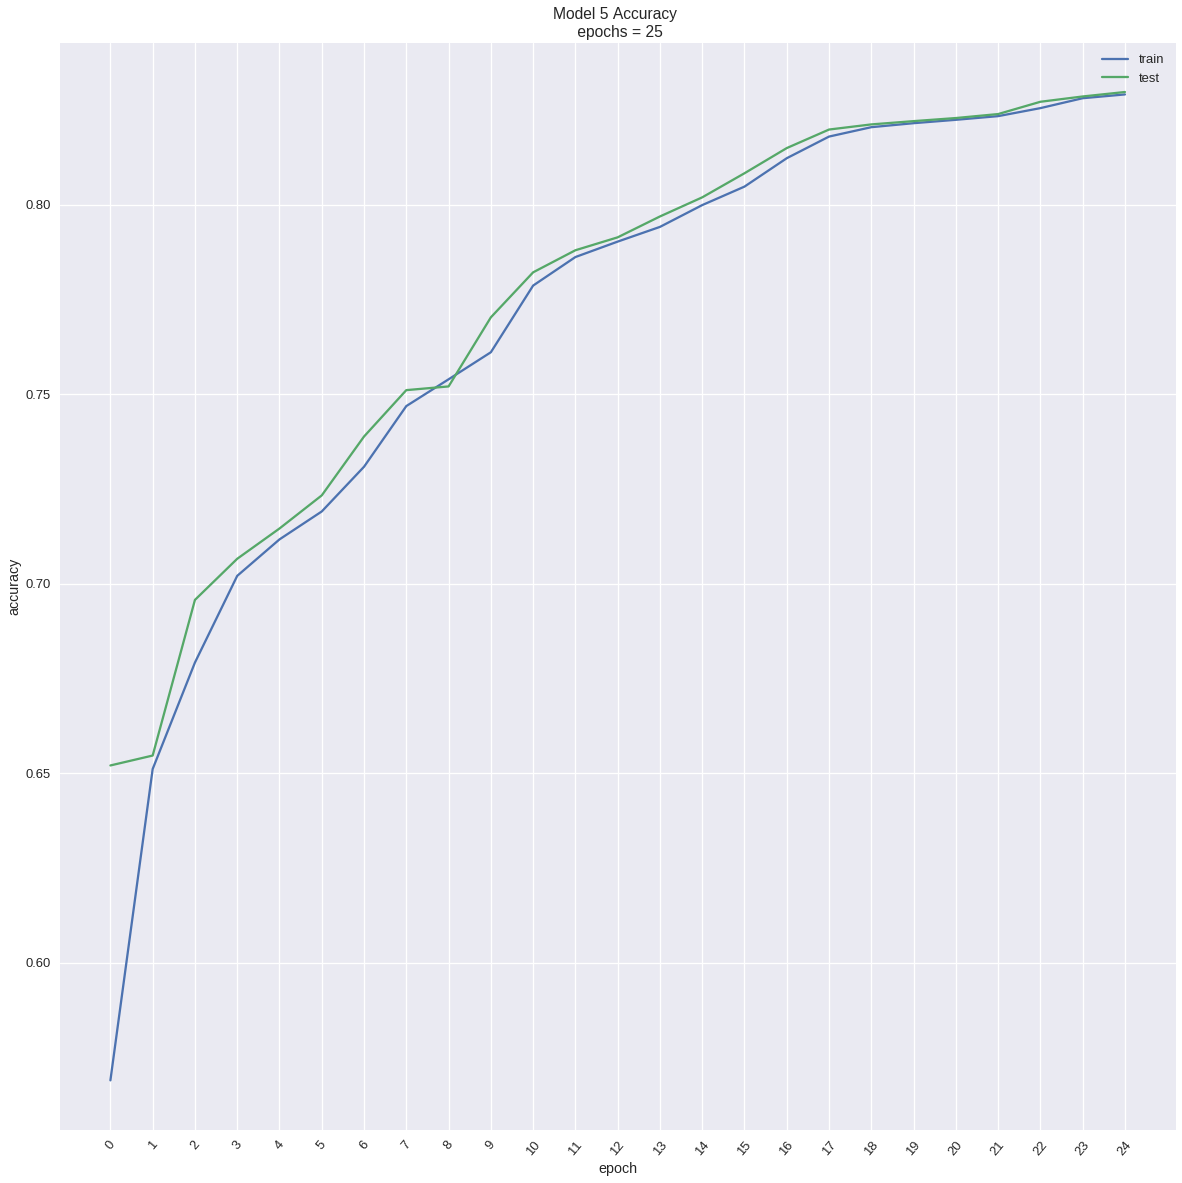

In [41]:
# Plot Accuracy
plot_metrics(training = np.load('model5_acc.npy'),
             validation= np.load('model5_valacc.npy'),
             title = 'Model 5 Accuracy \n epochs = 25', 
             ylabel = 'accuracy',
             xstep = 1)

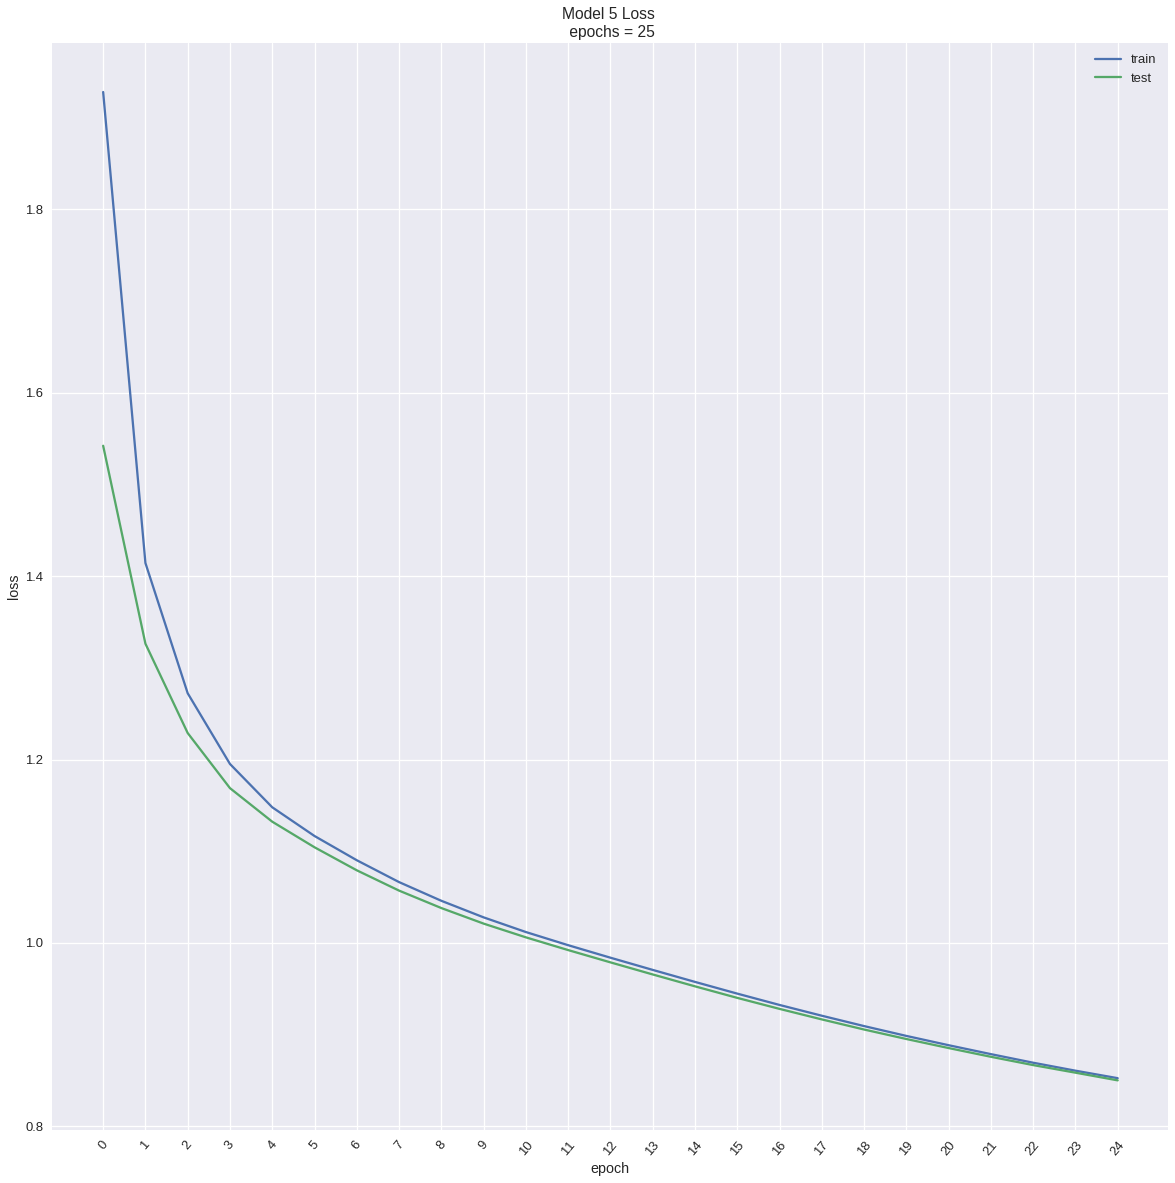

In [42]:
#Plot Loss

plot_metrics(training = np.load('model5_loss.npy'),
             validation= np.load('model5_valloss.npy'),
             title = 'Model 5 Loss \n epochs = 25', 
             ylabel = 'loss',
             xstep = 1)

**K-Fold Cross Validation**

In [27]:
#Divide data into 5 k_folds
    
kfold = KFold(n_splits = 5, shuffle=True, random_state=42)
    
# Initialize score list
    
cvscores = []

In [28]:
for train, test in kfold.split(cat_valid, num_valid, out_valid):
    
    # Categorical Inputs
    
    cat_input = Input(shape=(cat_input_cols,), dtype='int32', name='cat_input')
    
    # Embedding Layer
    
    embed = Embedding(output_dim=out_dim, input_dim=dim, input_length=cat_input_cols)(cat_input)
    
    # A flattening layer will transform the vector sequence into a single vector.
    
    flatten = Flatten()(embed)
    
    #Define numerical features input layer
    
    num_input = Input(shape=(num_cols,), name='num_input')
    
    # Input Layer. Concatenate numerical data & categorical data inputs into one input.
    
    input_layer = keras.layers.concatenate([flatten, num_input])
    
    # Dense Layers
    
    layer1 = Dense(20, activation='relu',kernel_regularizer=regularizers.l1(0.01))(input_layer)
    layer2 = Dense(20, activation='relu',kernel_regularizer=regularizers.l1(0.01))(layer1)
    
    # Output Layer
    
    main_output = Dense(out_cols, activation='softmax', name='main_output')(layer2)
    
    # Model
    
    modelcv = Model(inputs=[cat_input, num_input], outputs=[main_output])
    
    # Optimizer: Adam Gradient Descent
    
    adamgrad = keras.optimizers.Adagrad(lr=0.001, epsilon=None, decay=0.0)
    
    #Compile Model
    
    modelcv.compile(optimizer=adamgrad, loss={'main_output':'categorical_crossentropy'},
               metrics=['accuracy'])
    
    # Fit the model
    
    modelcv.fit({'cat_input':cat_valid[train],
               'num_input': num_valid[train]}, 
              {'main_output': out_valid[train]},
                  epochs=models_epochs, batch_size = 128,
                  shuffle = True, verbose = 1)
    
    # Evaluate the model
    
    scores = modelcv.evaluate({'cat_input':cat_valid[test], 
                             'num_input': num_valid[test]}, 
                            {'main_output': out_valid[test]}, 
                            batch_size=128, verbose=0)
    
    print("%s: %.2f%%" % (modelcv.metrics_names[1], scores[1]*100))
    
    cvscores.append(scores[1] * 100)

print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

Epoch 1/25
1339820/1339820 [==============================] - 52s 39us/step - loss: 3.3508 - acc: 0.4131
Epoch 2/25
1339820/1339820 [==============================] - 51s 38us/step - loss: 2.3361 - acc: 0.4876
Epoch 3/25
1339820/1339820 [==============================] - 51s 38us/step - loss: 2.0860 - acc: 0.5014
Epoch 4/25
1339820/1339820 [==============================] - 51s 38us/step - loss: 1.9630 - acc: 0.5315
Epoch 5/25
1339820/1339820 [==============================] - 51s 38us/step - loss: 1.8801 - acc: 0.5639
Epoch 6/25
1339820/1339820 [==============================] - 51s 38us/step - loss: 1.8130 - acc: 0.5819
Epoch 7/25
1339820/1339820 [==============================] - 51s 38us/step - loss: 1.7486 - acc: 0.6324
Epoch 8/25
1339820/1339820 [==============================] - 51s 38us/step - loss: 1.6867 - acc: 0.6412
Epoch 9/25
1339820/1339820 [==============================] - 50s 37us/step - loss: 1.6329 - acc: 0.6509
Epoch 10/25
1339820/1339820 [==========================

In [29]:
#Display CV Results

model5_cv_results = cvscores

model5_cv_results

[70.09120628083578,
 69.70219880245057,
 70.67038855995979,
 74.3505844069496,
 74.86557895801165]

In [30]:
# Save model cv 

np.save('model5_cv_accuracy.npy', model5_cv_results)

**Examine Model 5 Predictions**

In [77]:
# load json and create model

json_file = open("deep_learning_model5.json", 'r')

loaded_model_json = json_file.read()

json_file.close()

loaded_model = model_from_json(loaded_model_json)

# load weights into new model

loaded_model.load_weights("deep_learning_model5_weights.h5")

print("Loaded model from disk")

Loaded model from disk


In [78]:
#Model probability predictions

prob = loaded_model.predict({'cat_input':cat_test, 'num_input':num_test})

# Use argmax to pull the catoegory with highest probability out. 

predicted = prob.argmax(axis=-1)

# Convert one-hot encoded test output data back to categorical data. 

true = out_test.argmax(axis=-1)

#Calculate Confusion Matrix

model5_cfmtx = confusion_matrix(true, predicted)

In [79]:
#Calculate accuracy by class

calculate_acc_class(confusion_matrix = model5_cfmtx)

Average accuracy by class is (without NaN & Zeroes): 0.76
Average accuracy by class is (with zeroes): 0.267


In [80]:
predict_eval = eval_confusionmatrix(confusion_matrix = model5_cfmtx)

print('False Positive Rate: ',predict_eval['False Positive Rate'])

print('True Positive Rate: ',predict_eval['True Positive Rate'])

False Positive Rate:  ('Overall:', 0.004710305829410546, 'Average:', 0.005351660254016205)
True Positive Rate:  ('Overall:', 0.8304289901412204, 'Average:', 0.26707775636545356)


/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:60: RuntimeWarning: invalid value encountered in true_divide


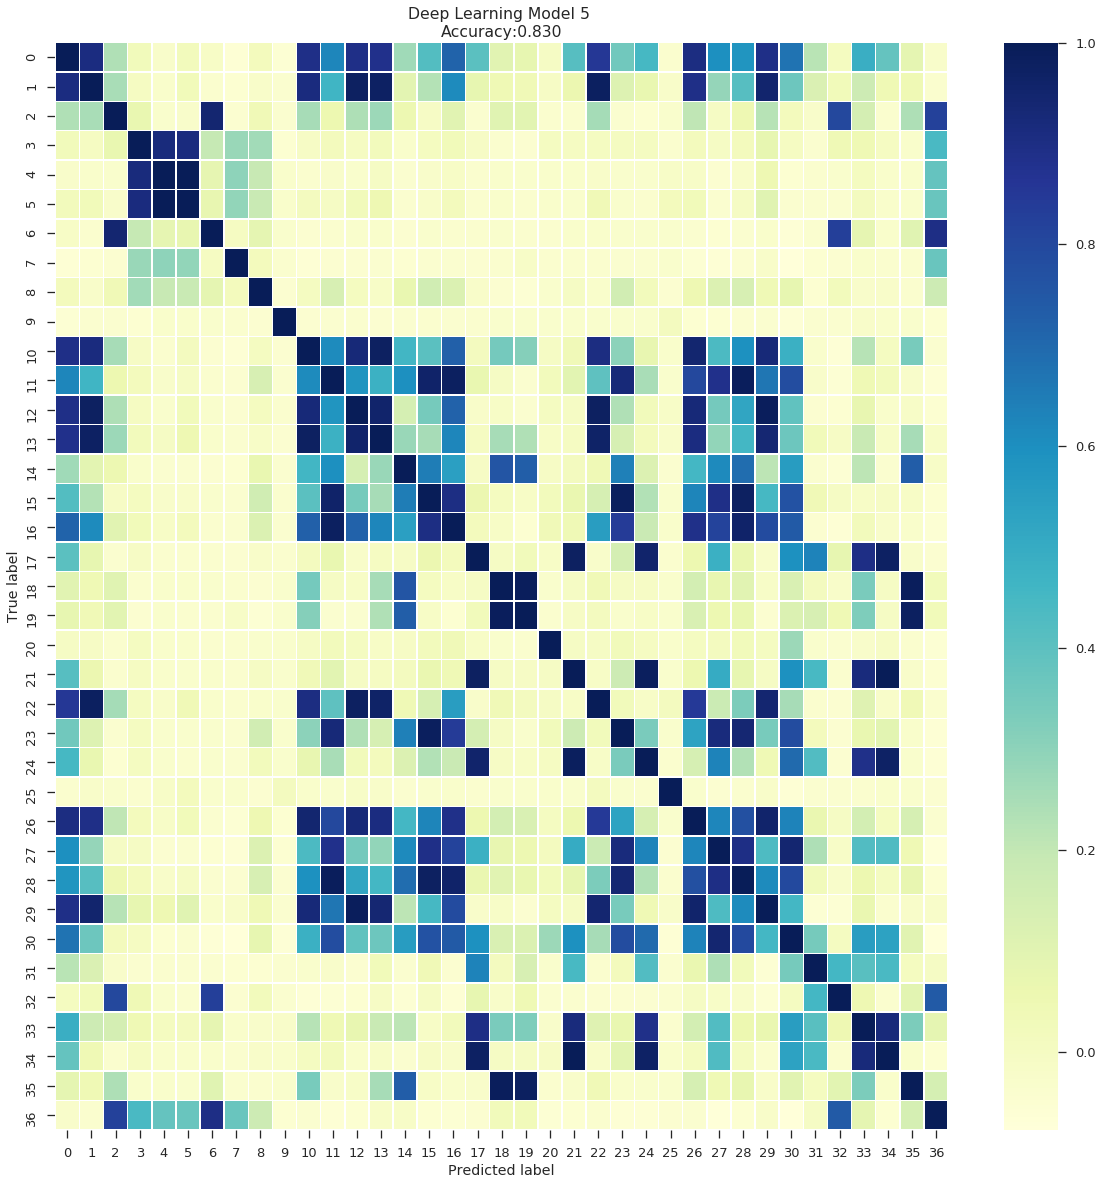

In [81]:
plot_confusion_assoc(confusion_matrix = model5_cfmtx, 
                         title ='Deep Learning Model 5 \nAccuracy:{0:.3f}'.format(accuracy_score(true, predicted)))

## `Deep Network Model 6`

*Model 1 with dropout regularization in the input and deep layers*

In [50]:
# Categorical Inputs

cat_input = Input(shape=(cat_input_cols,), dtype='int32', name='cat_input')

# Embedding Layer

embed = Embedding(output_dim=out_dim, input_dim=dim, input_length=cat_input_cols)(cat_input)

# A flattening layer will transform the vector sequence into a single vector.

flatten = Flatten()(embed)

#Define numerical features input layer

num_input = Input(shape=(num_cols,), name='num_input')

# Input Layer. Concatenate numerical data & categorical data inputs into one input.

input_layer = keras.layers.concatenate([flatten, num_input])


# Dense Layers

dropout1 = Dropout(0.2)(input_layer)
layer1 = Dense(20, activation='relu')(dropout1)
dropout2 = Dropout(0.2)(layer1)
layer2 = Dense(20, activation='relu')(dropout2)

# Output Layer

main_output = Dense(out_cols, activation='softmax', name='main_output')(layer2)

# Model

model6 = Model(inputs=[cat_input, num_input], outputs=[main_output])

# Optimizer: Adam Gradient Descent

adamgrad = keras.optimizers.Adagrad(lr=0.001, epsilon=None, decay=0.0)

#Compile Model

model6.compile(optimizer=adamgrad, loss={'main_output':'categorical_crossentropy'},
               metrics=['accuracy'])

In [51]:
%%time

# Fit Model Function

model6_hist = model6.fit({'cat_input':cat_train, 'num_input': num_train}, 
                         {'main_output': out_train},
                         validation_data = testing_data,
                         epochs=models_epochs, 
                         batch_size = 128,
                         shuffle = True, 
                         verbose = 2)

Train on 14621050 samples, validate on 319005 samples
Epoch 1/25
 - 596s - loss: 1.1262 - acc: 0.6816 - val_loss: 0.7482 - val_acc: 0.8024
Epoch 2/25
 - 594s - loss: 0.7899 - acc: 0.7800 - val_loss: 0.6299 - val_acc: 0.8293
Epoch 3/25
 - 594s - loss: 0.7155 - acc: 0.8008 - val_loss: 0.5888 - val_acc: 0.8349
Epoch 4/25
 - 595s - loss: 0.6804 - acc: 0.8102 - val_loss: 0.5645 - val_acc: 0.8403
Epoch 5/25
 - 597s - loss: 0.6576 - acc: 0.8164 - val_loss: 0.5466 - val_acc: 0.8464
Epoch 6/25
 - 594s - loss: 0.6404 - acc: 0.8211 - val_loss: 0.5324 - val_acc: 0.8493
Epoch 7/25
 - 595s - loss: 0.6264 - acc: 0.8249 - val_loss: 0.5201 - val_acc: 0.8534
Epoch 8/25
 - 598s - loss: 0.6146 - acc: 0.8280 - val_loss: 0.5094 - val_acc: 0.8571
Epoch 9/25
 - 600s - loss: 0.6040 - acc: 0.8309 - val_loss: 0.4998 - val_acc: 0.8592
Epoch 10/25
 - 595s - loss: 0.5947 - acc: 0.8335 - val_loss: 0.4910 - val_acc: 0.8614
Epoch 11/25
 - 595s - loss: 0.5861 - acc: 0.8358 - val_loss: 0.4832 - val_acc: 0.8642
Epoch 12/

**Save Model 6 Metrics and Model**

In [52]:
# Save model history metrics

np.save('model6_valloss.npy', model5_hist.history['val_loss'])
np.save('model6_loss.npy', model5_hist.history['loss'])
np.save('model6_acc.npy', model5_hist.history['acc'])
np.save('model6_valacc.npy', model5_hist.history['val_acc'])

In [53]:
# serialize model to JSON

model_json = model6.to_json()

with open("deep_learning_model6.json", "w") as json_file:
    json_file.write(model_json)

    # serialize weights to HDF5

    model6.save_weights("deep_learning_model6_weights.h5")

print("Saved model to disk")

Saved model to disk


**Plot Model 6 Accuracy and Loss of Training and Testing**

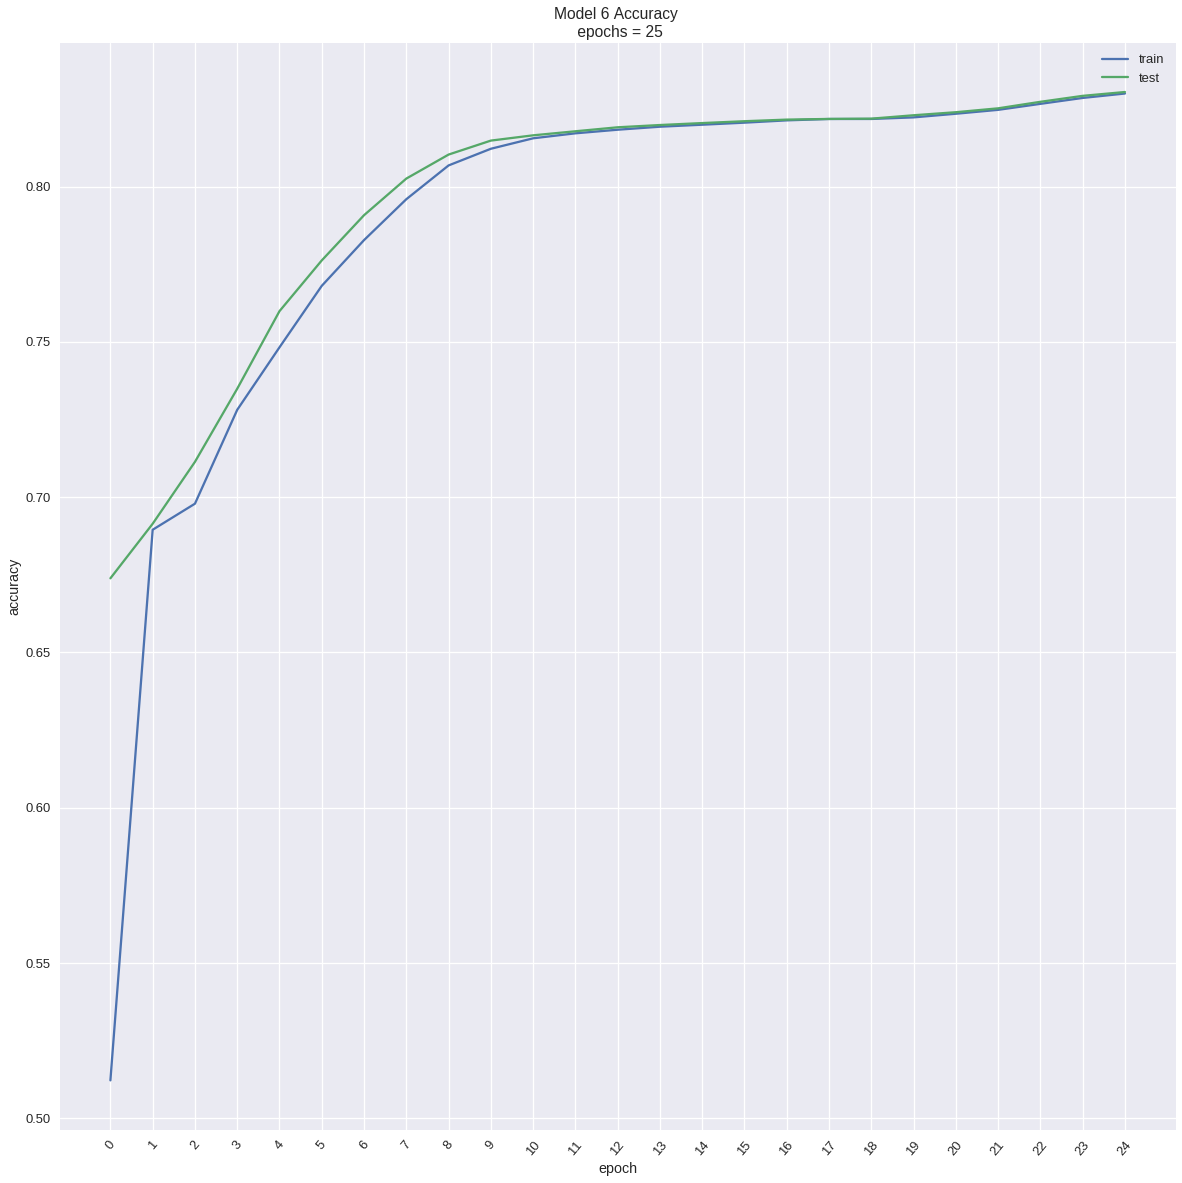

In [54]:
# Plot Accuracy
plot_metrics(training = np.load('model6_acc.npy'),
             validation= np.load('model6_valacc.npy'),
             title = 'Model 6 Accuracy \n epochs = 25', 
             ylabel = 'accuracy',
             xstep = 1)

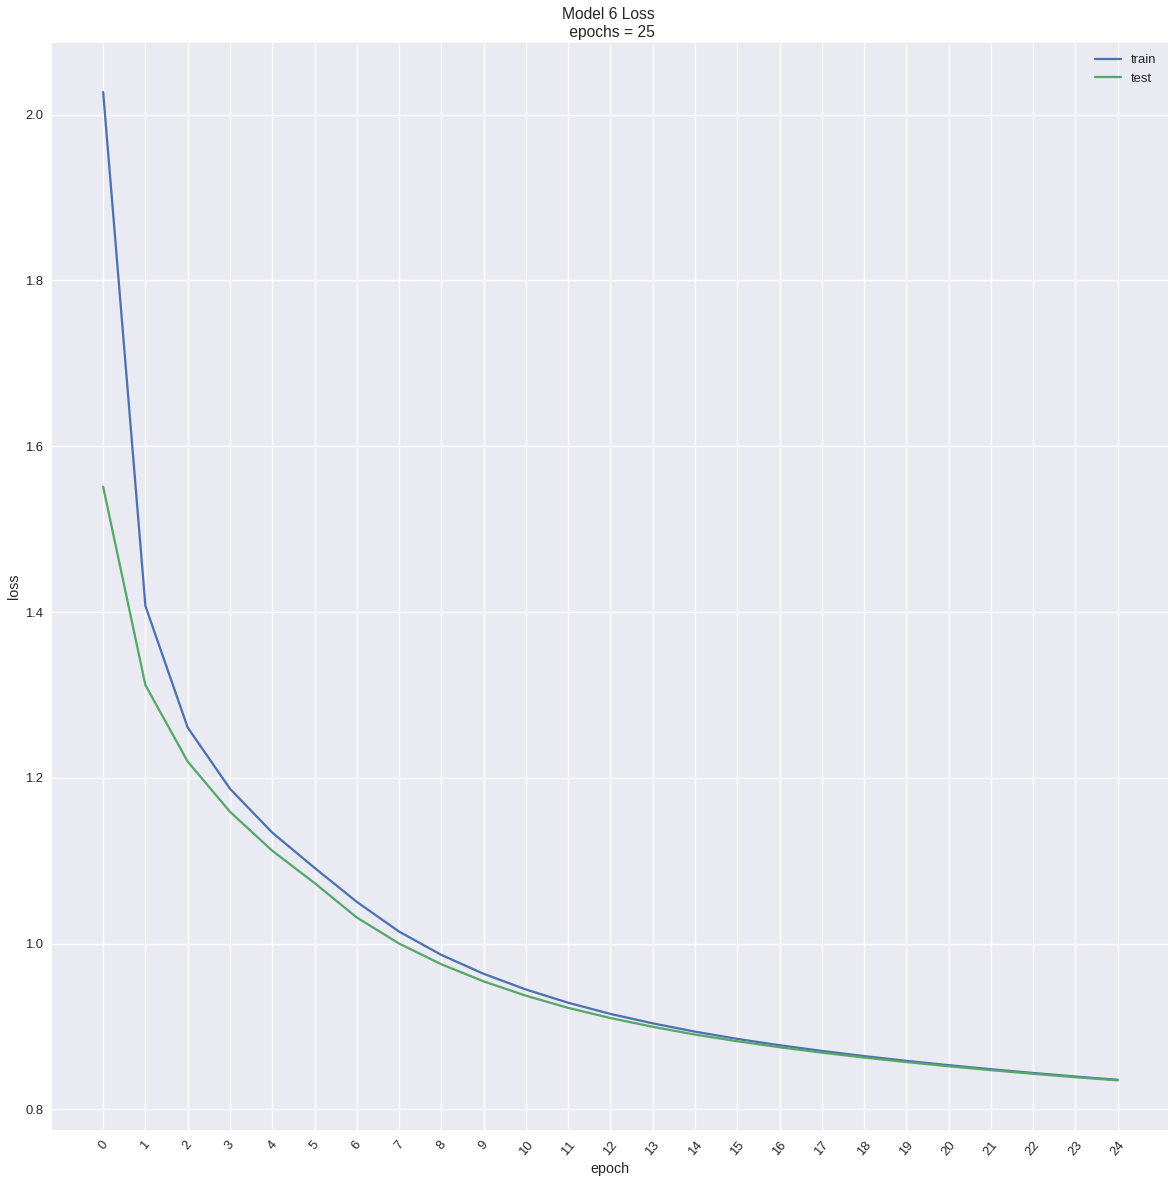

In [55]:
#Plot Loss

plot_metrics(training = np.load('model6_loss.npy'),
             validation= np.load('model6_valloss.npy'),
             title = 'Model 6 Loss \n epochs = 25', 
             ylabel = 'loss',
             xstep = 1)

**K-Fold Cross Validation**

In [56]:
#Divide data into 5 k_folds
    
kfold = KFold(n_splits = 5, shuffle=True, random_state=42)
    
# Initialize score list
    
cvscores = []

In [58]:
for train, test in kfold.split(cat_valid, num_valid, out_valid):
    
    # Categorical Inputs
    
    cat_input = Input(shape=(cat_input_cols,), dtype='int32', name='cat_input')
    
    # Embedding Layer
    
    embed = Embedding(output_dim=out_dim, input_dim=dim, input_length=cat_input_cols)(cat_input)
    
    # A flattening layer will transform the vector sequence into a single vector.
    
    flatten = Flatten()(embed)
    
    #Define numerical features input layer
    
    num_input = Input(shape=(num_cols,), name='num_input')
    
    # Input Layer. Concatenate numerical data & categorical data inputs into one input.
    
    input_layer = keras.layers.concatenate([flatten, num_input])
    
    # Dense Layers
    
    dropout1 = Dropout(0.2)(input_layer)
    layer1 = Dense(20, activation='relu')(dropout1)
    dropout2 = Dropout(0.2)(layer1)
    layer2 = Dense(20, activation='relu')(dropout2)
    
    # Output Layer
    
    main_output = Dense(out_cols, activation='softmax', name='main_output')(layer2)
    
    # Model
    
    modelcv = Model(inputs=[cat_input, num_input], outputs=[main_output])
    
    # Optimizer: Adam Gradient Descent
    
    adamgrad = keras.optimizers.Adagrad(lr=0.001, epsilon=None, decay=0.0)
    
    #Compile Model
    
    modelcv.compile(optimizer=adamgrad, loss={'main_output':'categorical_crossentropy'},
               metrics=['accuracy'])
    
    # Fit the model
    
    modelcv.fit({'cat_input':cat_valid[train],
               'num_input': num_valid[train]}, 
              {'main_output': out_valid[train]},
                  epochs=models_epochs, batch_size = 128,
                  shuffle = True, verbose = 1)
    
    # Evaluate the model
    
    scores = modelcv.evaluate({'cat_input':cat_valid[test], 
                             'num_input': num_valid[test]}, 
                            {'main_output': out_valid[test]}, 
                            batch_size=128, verbose=0)
    
    print("%s: %.2f%%" % (modelcv.metrics_names[1], scores[1]*100))
    
    cvscores.append(scores[1] * 100)

print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

Epoch 1/25
1339820/1339820 [==============================] - 58s 43us/step - loss: 2.0874 - acc: 0.4522
Epoch 2/25
1339820/1339820 [==============================] - 57s 42us/step - loss: 1.4362 - acc: 0.6026
Epoch 3/25
1339820/1339820 [==============================] - 57s 42us/step - loss: 1.2232 - acc: 0.6701
Epoch 4/25
1339820/1339820 [==============================] - 57s 42us/step - loss: 1.1110 - acc: 0.6995
Epoch 5/25
1339820/1339820 [==============================] - 57s 43us/step - loss: 1.0433 - acc: 0.7165
Epoch 6/25
1339820/1339820 [==============================] - 57s 42us/step - loss: 0.9963 - acc: 0.7288
Epoch 7/25
1339820/1339820 [==============================] - 57s 42us/step - loss: 0.9598 - acc: 0.7385
Epoch 8/25
1339820/1339820 [==============================] - 57s 42us/step - loss: 0.9305 - acc: 0.7465
Epoch 9/25
1339820/1339820 [==============================] - 57s 42us/step - loss: 0.9050 - acc: 0.7535
Epoch 10/25
1339820/1339820 [==========================

In [59]:
#Display CV Results

model6_cv_results = cvscores

model6_cv_results

[82.58213789965461,
 81.83487334139082,
 82.89203027315027,
 83.10758161497822,
 82.43047573463903]

In [60]:
# Save model cv 

np.save('model6_cv_accuracy.npy', model6_cv_results)

**Examine Model 6 Predictions Using Testing Data**

In [87]:
# load json and create model

json_file = open("deep_learning_model6.json", 'r')

loaded_model_json = json_file.read()

json_file.close()

loaded_model = model_from_json(loaded_model_json)

# load weights into new model

loaded_model.load_weights("deep_learning_model6_weights.h5")

print("Loaded model from disk")

Loaded model from disk


In [88]:
#Model probability predictions

prob = loaded_model.predict({'cat_input':cat_test, 'num_input':num_test})

# Use argmax to pull the catoegory with highest probability out. 

predicted = prob.argmax(axis=-1)

# Convert one-hot encoded test output data back to categorical data. 

true = out_test.argmax(axis=-1)

#Calculate Confusion Matrix

model6_cfmtx = confusion_matrix(true, predicted)

In [89]:
#Calculate accuracy by class

calculate_acc_class(confusion_matrix = model6_cfmtx)

Average accuracy by class is (without NaN & Zeroes): 0.761
Average accuracy by class is (with zeroes): 0.432


In [90]:
predict_eval = eval_confusionmatrix(confusion_matrix = model6_cfmtx)

print('False Positive Rate: ',predict_eval['False Positive Rate'])

print('True Positive Rate: ',predict_eval['True Positive Rate'])

False Positive Rate:  ('Overall:', 0.003245595244936948, 'Average:', 0.0038033954676960666)
True Positive Rate:  ('Overall:', 0.8831585711822699, 'Average:', 0.43165344794738586)


/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:60: RuntimeWarning: invalid value encountered in true_divide


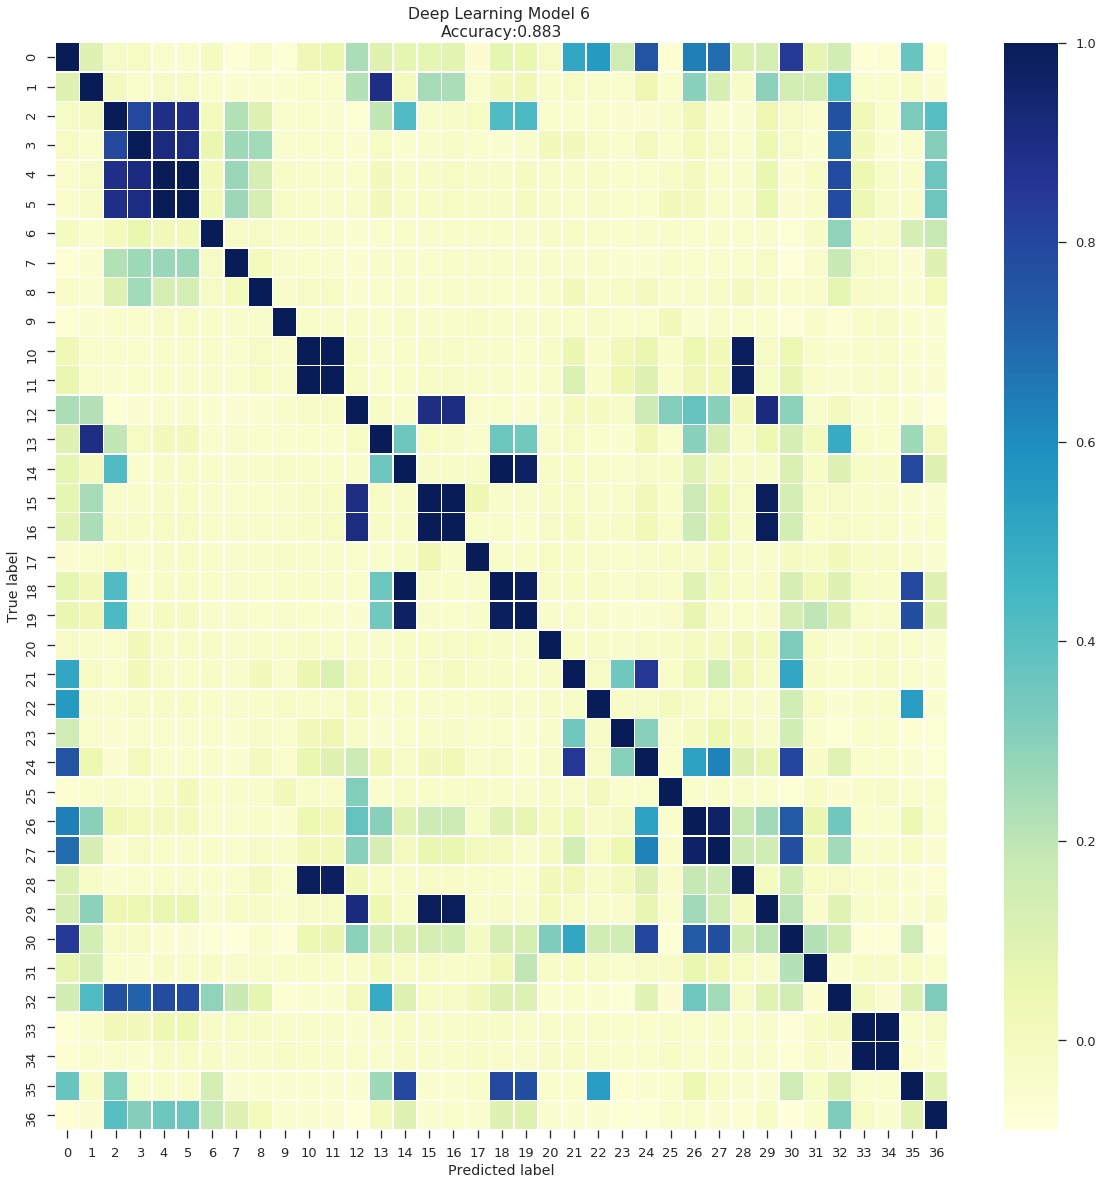

In [91]:
plot_confusion_assoc(confusion_matrix = model6_cfmtx, 
                         title ='Deep Learning Model 6 \nAccuracy:{0:.3f}'.format(accuracy_score(true, predicted)))

## `Naive Oversampling of Minority Classes`

**Training Data**

In [37]:
#Create X array array by concatenating numerical and categorical inputs.

x_train = np.concatenate((num_train, cat_train), axis = 1)

In [27]:
#Convert output(y) from one-hot encoding back to one categorical array

y_train = np.argmax(out_train, axis=1)

In [63]:
df_y = pd.DataFrame(y_train)

pd.value_counts(df_y[0].values, sort=True)

5     5942398
10    1440762
26    1278384
22     940765
21     919979
31     644002
23     595807
4      461932
7      388769
19     354824
8      301347
9      280044
32     173248
16     160822
11     124717
18     122941
14     104432
29      72385
27      70417
24      43128
37      40433
34      26377
6       23635
36      17047
12      16549
13      15253
30      14931
0       13244
3        8693
2        8054
17       4388
15       3974
35       2126
28       2065
20       2063
33        986
25        114
1          15
dtype: int64

In [115]:
# Resample any category with less than 100k observations

sampling_strategy = {29:100000,27:100000,24:100000,37:100000,34:100000,6:100000,
                     36:100000,12:100000,13:100000,30:100000,0:100000,3:100000,
                     2:100000,17:100000,15:100000,35:100000,28:100000,20:100000,
                     33:100000,25:100000,1:100000}

In [33]:
%%time

#Resample specific categories in the minority classes.

rd_sampler = RandomOverSampler(sampling_strategy = sampling_strategy, random_state=0)

x_rdsampler, y_rdsampler = rd_sampler.fit_resample(x_train, y_train)

CPU times: user 7.91 s, sys: 2.94 s, total: 10.9 s
Wall time: 10.8 s


In [64]:
cat_train_rdsampling = x_rdsampler[:,[8,9,10,11,12,13]]

num_train_rdsampling = x_rdsampler[:,[0,1,2,3,4,5,6,7]]

In [66]:
#Convert output variable back to one-hot encoded array

out_train_rdsampling = np.max(y_rdsampler) + 1

out_train_rdsampling = np.eye(out_train_rdsampling)[y_rdsampler]

In [116]:
print('num_input shape |', 'Train:',num_train_rdsampling.shape)

print('cat_input shape |', 'Train:',cat_train_rdsampling.shape)

print('out_input shape |', 'Train:',out_train_rdsampling.shape)

num_input shape | Train: (16335173, 8)
cat_input shape | Train: (16335173, 6)
out_input shape | Train: (16335173, 38)


*Only training data will be re-sampled. If test and validation data is re-sampled we will bleed training information into data that should be hidden to the model*

## `Deep Network Model 7`

*Model 1 with Random Oversampling*

In [69]:
# Categorical Inputs

cat_input = Input(shape=(cat_input_cols,), dtype='int32', name='cat_input')

# Embedding Layer

embed = Embedding(output_dim=out_dim, input_dim=dim, input_length=cat_input_cols)(cat_input)

# A flattening layer will transform the vector sequence into a single vector.

flatten = Flatten()(embed)

#Define numerical features input layer

num_input = Input(shape=(num_cols,), name='num_input')

# Input Layer. Concatenate numerical data & categorical data inputs into one input.

input_layer = keras.layers.concatenate([flatten, num_input])


# Dense Layers

layer1 = Dense(20, activation='relu')(input_layer)
layer2 = Dense(20, activation='relu')(layer1)

# Output Layer

main_output = Dense(out_cols, activation='softmax', name='main_output')(layer2)

# Model

model7 = Model(inputs=[cat_input, num_input], outputs=[main_output])

# Optimizer: Adam Gradient Descent

adamgrad = keras.optimizers.Adagrad(lr=0.001, epsilon=None, decay=0.0)

#Compile Model

model7.compile(optimizer=adamgrad, loss={'main_output':'categorical_crossentropy'},
               metrics=['accuracy'])

In [70]:
%%time

# Fit Model Function

model7_hist = model7.fit({'cat_input':cat_train_rdsampling, 
                          'num_input': num_train_rdsampling}, 
                         {'main_output': out_train_rdsampling},
                         validation_data = testing_data,
                         epochs=models_epochs, 
                         batch_size = 128,
                         shuffle = True, 
                         verbose = 2)

Train on 16335173 samples, validate on 319005 samples
Epoch 1/25
 - 564s - loss: 1.1115 - acc: 0.6969 - val_loss: 0.6795 - val_acc: 0.8168
Epoch 2/25
 - 565s - loss: 0.7324 - acc: 0.8005 - val_loss: 0.5715 - val_acc: 0.8523
Epoch 3/25
 - 563s - loss: 0.6304 - acc: 0.8357 - val_loss: 0.5219 - val_acc: 0.8646
Epoch 4/25
 - 562s - loss: 0.5760 - acc: 0.8491 - val_loss: 0.4909 - val_acc: 0.8719
Epoch 5/25
 - 561s - loss: 0.5399 - acc: 0.8584 - val_loss: 0.4690 - val_acc: 0.8764
Epoch 6/25
 - 563s - loss: 0.5124 - acc: 0.8648 - val_loss: 0.4509 - val_acc: 0.8801
Epoch 7/25
 - 562s - loss: 0.4916 - acc: 0.8694 - val_loss: 0.4379 - val_acc: 0.8831
Epoch 8/25
 - 563s - loss: 0.4759 - acc: 0.8739 - val_loss: 0.4272 - val_acc: 0.8856
Epoch 9/25
 - 562s - loss: 0.4632 - acc: 0.8773 - val_loss: 0.4184 - val_acc: 0.8876
Epoch 10/25
 - 564s - loss: 0.4525 - acc: 0.8793 - val_loss: 0.4111 - val_acc: 0.8889
Epoch 11/25
 - 562s - loss: 0.4434 - acc: 0.8811 - val_loss: 0.4048 - val_acc: 0.8904
Epoch 12/

**Save Model 7 Metrics and Model**

In [71]:
# Save model history metrics

np.save('model7_valloss.npy', model7_hist.history['val_loss'])
np.save('model7_loss.npy', model7_hist.history['loss'])
np.save('model7_acc.npy', model7_hist.history['acc'])
np.save('model7_valacc.npy', model7_hist.history['val_acc'])

In [104]:
# serialize model to JSON

model_json = model7.to_json()

with open("deep_learning_model7.json", "w") as json_file:
    json_file.write(model_json)

    # serialize weights to HDF5

    model7.save_weights("deep_learning_model7_weights.h5")

print("Saved model to disk")

Saved model to disk


**Accuracy of Training and Testing**

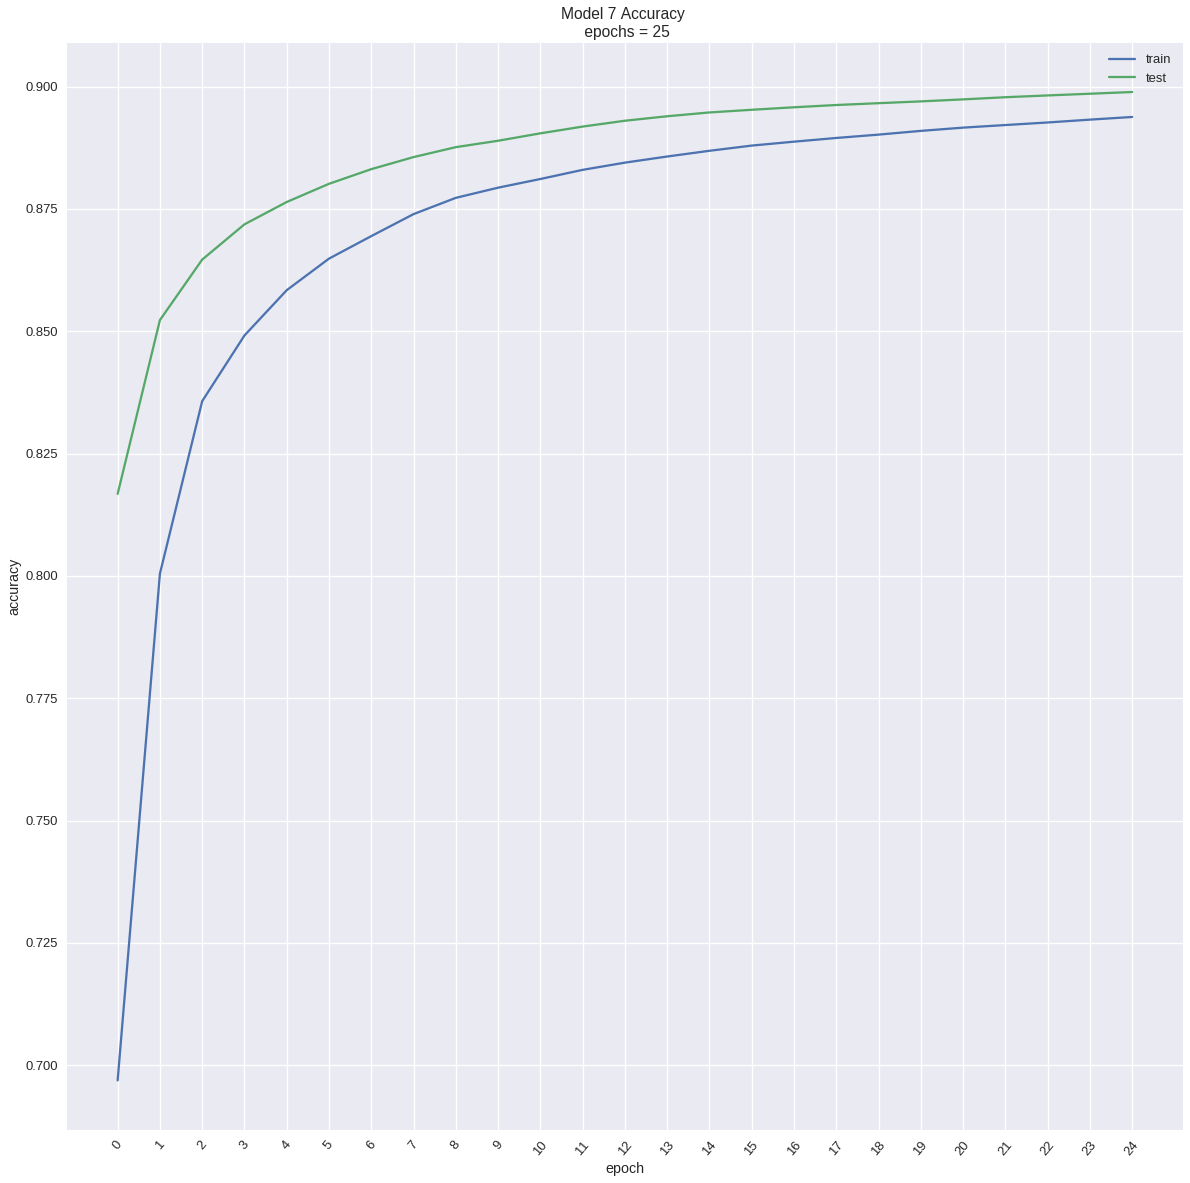

In [73]:
# Plot Accuracy
plot_metrics(training = np.load('model7_acc.npy'),
             validation= np.load('model7_valacc.npy'),
             title = 'Model 7 Accuracy \n epochs = 25', 
             ylabel = 'accuracy',
             xstep = 1)

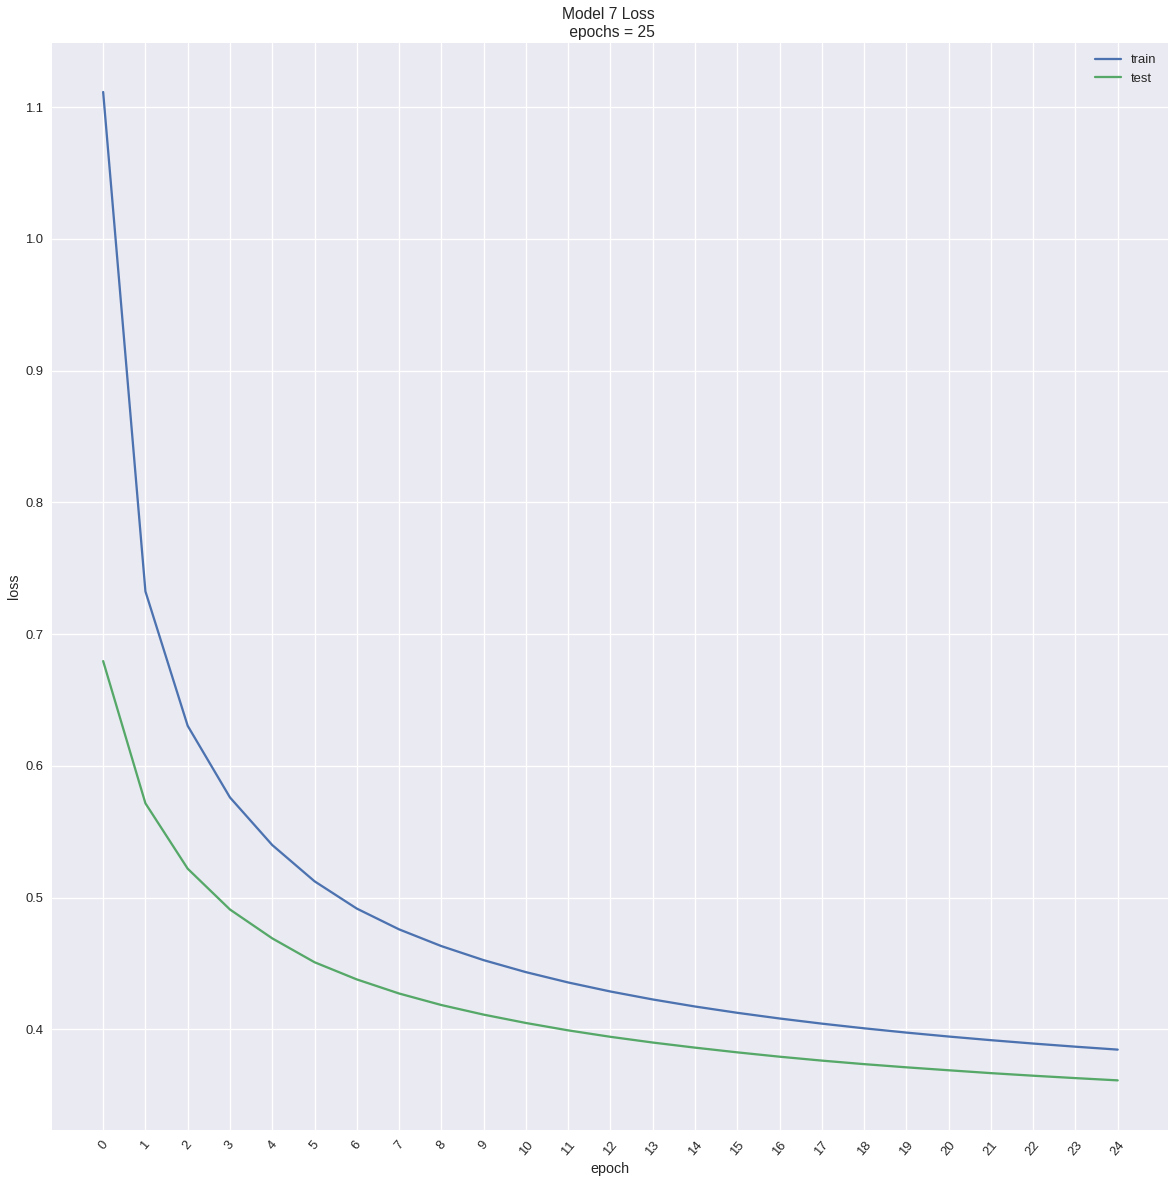

In [76]:
#Plot Loss

plot_metrics(training = np.load('model7_loss.npy'),
             validation= np.load('model7_valloss.npy'),
             title = 'Model 7 Loss \n epochs = 25', 
             ylabel = 'loss',
             xstep = 1)

**K-Fold Cross Validation**

In [77]:
#Divide data into 5 k_folds
    
kfold = KFold(n_splits = 5, shuffle=True, random_state=42)
    
# Initialize score list
    
cvscores = []

In [124]:
for train, test in kfold.split(cat_valid, num_valid, out_valid):
    
    #Prepare re-sampling (only training data)
    
    x_valid = np.concatenate((num_valid[train], cat_valid[train]), axis = 1)
    
    #Convert output(y) from one-hot encoding back to one categorical array
    
    y_valid = np.argmax(out_valid[train], axis=1)
    
    #Random Re-Sampling
    
    rd_sampler = RandomOverSampler(sampling_strategy = sampling_strategy, random_state=0)
    xvalid_rdsampler, yvalid_rdsampler = rd_sampler.fit_resample(x_valid, y_valid)
    
    #Validation Training Data
    
    cat_valid_rdsampling = xvalid_rdsampler[:,[8,9,10,11,12,13]]
    
    num_valid_rdsampling = xvalid_rdsampler[:,[0,1,2,3,4,5,6,7]]
    
    out_valid_rdsampling = np.max(yvalid_rdsampler) + 1
    
    out_valid_rdsampling = np.eye(out_valid_rdsampling)[yvalid_rdsampler]
    
    #-------MODEL STARTS HERE-----------
    
    # Categorical Inputs
    
    cat_input = Input(shape=(cat_input_cols,), dtype='int32', name='cat_input')
    
    # Embedding Layer
    
    embed = Embedding(output_dim=out_dim, input_dim=dim, input_length=cat_input_cols)(cat_input)
    
    # A flattening layer will transform the vector sequence into a single vector.
    
    flatten = Flatten()(embed)
    
    #Define numerical features input layer
    
    num_input = Input(shape=(num_cols,), name='num_input')
    
    # Input Layer. Concatenate numerical data & categorical data inputs into one input.
    
    input_layer = keras.layers.concatenate([flatten, num_input])
    
    # Dense Layers
    
    layer1 = Dense(20, activation='relu')(input_layer)
    layer2 = Dense(20, activation='relu')(layer1)
    
    # Output Layer
    
    main_output = Dense(out_cols, activation='softmax', name='main_output')(layer2)
    
    # Model
    
    modelcv = Model(inputs=[cat_input, num_input], outputs=[main_output])
    
    # Optimizer: Adam Gradient Descent
    
    adamgrad = keras.optimizers.Adagrad(lr=0.001, epsilon=None, decay=0.0)
    
    #Compile Model
    
    modelcv.compile(optimizer=adamgrad, loss={'main_output':'categorical_crossentropy'},
               metrics=['accuracy'])
    
    # Fit the model
    
    modelcv.fit({'cat_input':cat_valid_rdsampling,
                 'num_input': num_valid_rdsampling}, 
              {'main_output': out_valid_rdsampling},
                  epochs=models_epochs, batch_size = 128,
                  shuffle = True, verbose = 1)
    
    # Evaluate the model
    
    scores = modelcv.evaluate({'cat_input':cat_valid[test], 
                               'num_input': num_valid[test]}, 
                              {'main_output': out_valid[test]}, 
                              batch_size=128, verbose=0)
    
    print("%s: %.2f%%" % (modelcv.metrics_names[1], scores[1]*100))
    
    cvscores.append(scores[1] * 100)

print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

Epoch 1/25
3404494/3404494 [==============================] - 128s 38us/step - loss: 1.9593 - acc: 0.5151
Epoch 2/25
3404494/3404494 [==============================] - 128s 37us/step - loss: 1.0036 - acc: 0.7598
Epoch 3/25
3404494/3404494 [==============================] - 126s 37us/step - loss: 0.7838 - acc: 0.8079
Epoch 4/25
3404494/3404494 [==============================] - 127s 37us/step - loss: 0.6837 - acc: 0.8310
Epoch 5/25
3404494/3404494 [==============================] - 127s 37us/step - loss: 0.6241 - acc: 0.8435
Epoch 6/25
3404494/3404494 [==============================] - 127s 37us/step - loss: 0.5837 - acc: 0.8520
Epoch 7/25
3404494/3404494 [==============================] - 126s 37us/step - loss: 0.5543 - acc: 0.8581
Epoch 8/25
3404494/3404494 [==============================] - 126s 37us/step - loss: 0.5316 - acc: 0.8630
Epoch 9/25
3404494/3404494 [==============================] - 126s 37us/step - loss: 0.5134 - acc: 0.8681
Epoch 10/25
3404494/3404494 [=================

In [125]:
#Display CV Results

model7_cv_results = cvscores

model7_cv_results

[84.18742816197411,
 84.65495365057933,
 82.16417130634429,
 82.77708945976039,
 83.09922228380387]

In [126]:
# Save model cv 

np.save('model7_cv_accuracy.npy', model7_cv_results)

**Examine Model 7 Predictions Using Testing Data**

In [92]:
# load json and create model

json_file = open("deep_learning_model7.json", 'r')

loaded_model_json = json_file.read()

json_file.close()

loaded_model = model_from_json(loaded_model_json)

# load weights into new model

loaded_model.load_weights("deep_learning_model7_weights.h5")

print("Loaded model from disk")

Loaded model from disk


In [104]:
#Model probability predictions

prob = loaded_model.predict({'cat_input':cat_test, 'num_input':num_test})

# Use argmax to pull the catoegory with highest probability out. 

predicted = prob.argmax(axis=-1)

# Convert one-hot encoded test output data back to categorical data. 

true = out_test.argmax(axis=-1)

#Calculate Confusion Matrix

model7_cfmtx = confusion_matrix(true, predicted)

#Remove empty column [1] - it creates issues when calculating 

model7_cfmtx = np.delete(model7_cfmtx, [1], axis=0)
model7_cfmtx = np.delete(model7_cfmtx, [1], axis=1)

In [107]:
#Calculate accuracy by class

calculate_acc_class(confusion_matrix = model7_cfmtx)

Average accuracy by class is (without NaN & Zeroes): 0.82
Average accuracy by class is (with zeroes): 0.82


In [108]:
predict_eval = eval_confusionmatrix(confusion_matrix = model7_cfmtx)

print('False Positive Rate: ',predict_eval['False Positive Rate'])

print('True Positive Rate: ',predict_eval['True Positive Rate'])

False Positive Rate:  ('Overall:', 0.0028075416729364164, 'Average:', 0.003266106019521077)
True Positive Rate:  ('Overall:', 0.898928499774289, 'Average:', 0.8202383897847452)


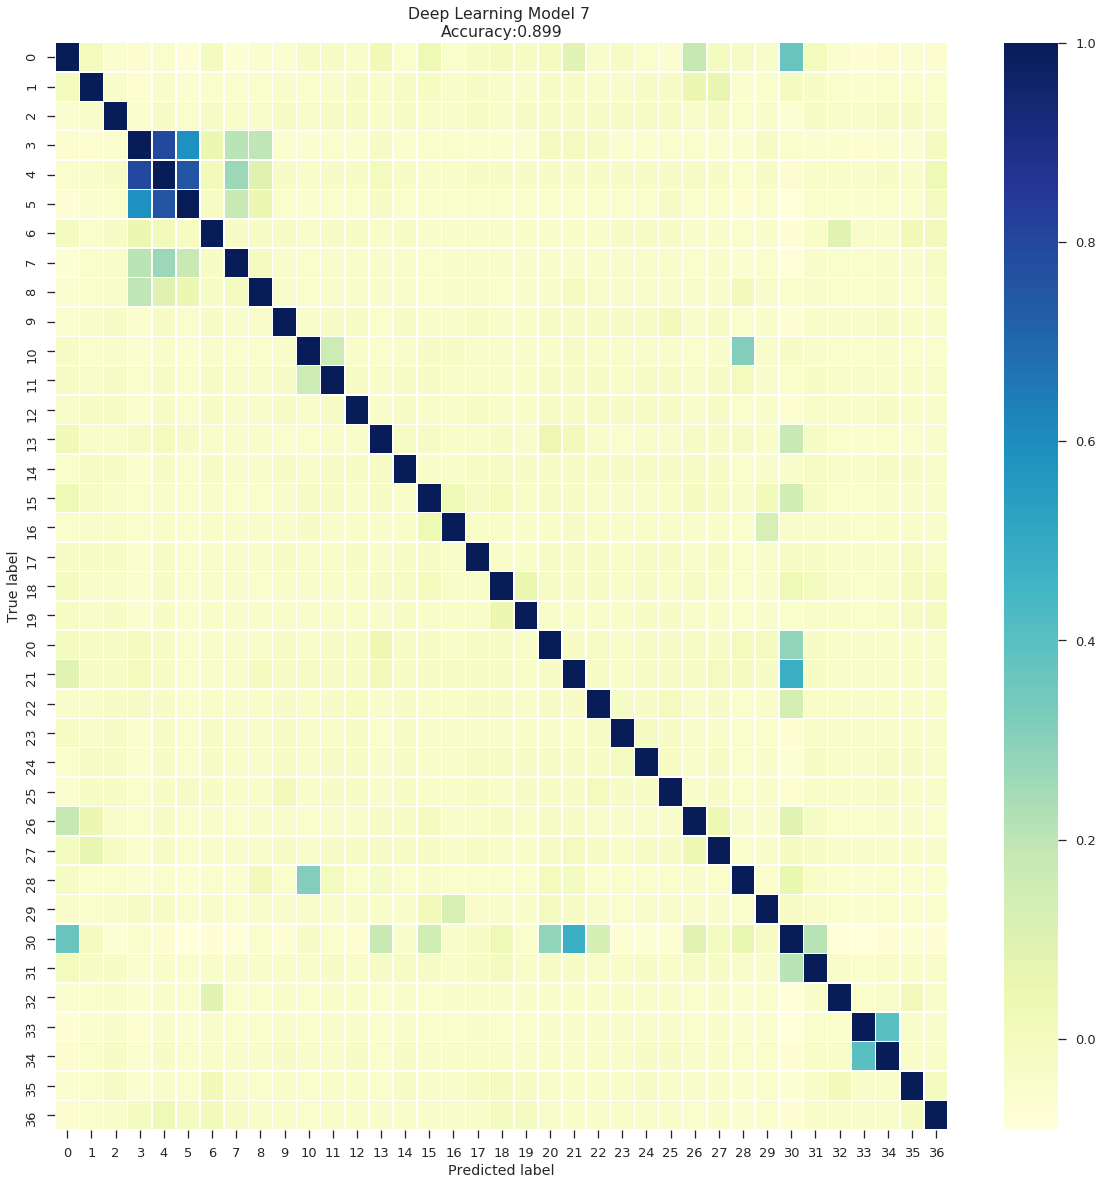

In [106]:
plot_confusion_assoc(confusion_matrix = model7_cfmtx, 
                         title ='Deep Learning Model 7 \nAccuracy:{0:.3f}'.format(accuracy_score(true, predicted)))

## `SMOTE-NC Oversampling of Minority Classes`

*Synthetic Minority Over-sampling Technique for Nominal and Continuous (SMOTE-NC).*

**Training Data**

In [17]:
#Create X array array by concatenating numerical and categorical inputs.

x_train = np.concatenate((num_train, cat_train), axis = 1)

In [18]:
#Convert output(y) from one-hot encoding back to one categorical array

y_train = np.argmax(out_train, axis=1)

In [19]:
df_y = pd.DataFrame(y_train)

pd.value_counts(df_y[0].values, sort=True)

5     5942398
10    1440762
26    1278384
22     940765
21     919979
31     644002
23     595807
4      461932
7      388769
19     354824
8      301347
9      280044
32     173248
16     160822
11     124717
18     122941
14     104432
29      72385
27      70417
24      43128
37      40433
34      26377
6       23635
36      17047
12      16549
13      15253
30      14931
0       13244
3        8693
2        8054
17       4388
15       3974
35       2126
28       2065
20       2063
33        986
25        114
1          15
dtype: int64

In [39]:
# Resample any category with less than 100k observations

sampling_strategy = {29:100000,27:100000,24:100000,37:100000,34:100000,6:100000,
                     36:100000,12:100000,13:100000,30:100000,0:100000,3:100000,
                     2:100000,17:100000,15:100000,35:100000,28:100000,20:100000,
                     33:100000,25:100000,1:100000}

In [26]:
%%time

#Resample specific categories in the minority classes.

smotenc_sampler = SMOTENC(sampling_strategy = sampling_strategy, 
                          categorical features = [8,9,10,11,12,13],
                          random_state = 0)

x_smotenc_sampler, y_smotenc_sampler = smotenc_sampler.fit_resample(x_train, y_train)

CPU times: user 1h 18min 11s, sys: 4min 19s, total: 1h 22min 30s
Wall time: 1h 22min 29s


In [27]:
cat_train_smotenc = x_smotenc_sampler[:,[8,9,10,11,12,13]]

num_train_smotenc = x_smotenc_sampler[:,[0,1,2,3,4,5,6,7]]

In [29]:
#Convert output variable back to one-hot encoded array

out_train_smotenc = np.max(y_smotenc_sampler) + 1

out_train_smotenc = np.eye(out_train_smotenc)[y_smotenc_sampler]

In [30]:
print('num_input shape |', 'Train:',num_train_smotenc.shape)

print('cat_input shape |', 'Train:',cat_train_smotenc.shape)

print('out_input shape |', 'Train:',out_train_smotenc.shape)

num_input shape | Train: (16335173, 8)
cat_input shape | Train: (16335173, 6)
out_input shape | Train: (16335173, 38)


*Only training data will be re-sampled. If test and validation data is re-sampled we will bleed training information into data that should be hidden to the model*

## `Deep Network Model 8`

*Model 1 with SMOTENC Oversampling*

In [31]:
# Categorical Inputs

cat_input = Input(shape=(cat_input_cols,), dtype='int32', name='cat_input')

# Embedding Layer

embed = Embedding(output_dim=out_dim, input_dim=dim, input_length=cat_input_cols)(cat_input)

# A flattening layer will transform the vector sequence into a single vector.

flatten = Flatten()(embed)

#Define numerical features input layer

num_input = Input(shape=(num_cols,), name='num_input')

# Input Layer. Concatenate numerical data & categorical data inputs into one input.

input_layer = keras.layers.concatenate([flatten, num_input])


# Dense Layers

layer1 = Dense(20, activation='relu')(input_layer)
layer2 = Dense(20, activation='relu')(layer1)

# Output Layer

main_output = Dense(out_cols, activation='softmax', name='main_output')(layer2)

# Model

model8 = Model(inputs=[cat_input, num_input], outputs=[main_output])

# Optimizer: Adam Gradient Descent

adamgrad = keras.optimizers.Adagrad(lr=0.001, epsilon=None, decay=0.0)

#Compile Model

model8.compile(optimizer=adamgrad, loss={'main_output':'categorical_crossentropy'},
               metrics=['accuracy'])

In [32]:
%%time

# Fit Model Function

model8_hist = model8.fit({'cat_input':cat_train_smotenc, 
                          'num_input': num_train_smotenc}, 
                         {'main_output': out_train_smotenc},
                         validation_data = testing_data,
                         epochs=models_epochs, 
                         batch_size = 128,
                         shuffle = True, 
                         verbose = 2)

Train on 16335173 samples, validate on 319005 samples
Epoch 1/25
 - 559s - loss: 1.0117 - acc: 0.7320 - val_loss: 0.6138 - val_acc: 0.8354
Epoch 2/25
 - 558s - loss: 0.6040 - acc: 0.8419 - val_loss: 0.5251 - val_acc: 0.8602
Epoch 3/25
 - 558s - loss: 0.5293 - acc: 0.8603 - val_loss: 0.4884 - val_acc: 0.8688
Epoch 4/25
 - 559s - loss: 0.4937 - acc: 0.8688 - val_loss: 0.4656 - val_acc: 0.8742
Epoch 5/25
 - 561s - loss: 0.4705 - acc: 0.8741 - val_loss: 0.4493 - val_acc: 0.8784
Epoch 6/25
 - 560s - loss: 0.4531 - acc: 0.8786 - val_loss: 0.4361 - val_acc: 0.8818
Epoch 7/25
 - 559s - loss: 0.4392 - acc: 0.8825 - val_loss: 0.4251 - val_acc: 0.8844
Epoch 8/25
 - 559s - loss: 0.4276 - acc: 0.8854 - val_loss: 0.4158 - val_acc: 0.8864
Epoch 9/25
 - 559s - loss: 0.4178 - acc: 0.8876 - val_loss: 0.4079 - val_acc: 0.8882
Epoch 10/25
 - 558s - loss: 0.4094 - acc: 0.8894 - val_loss: 0.4010 - val_acc: 0.8895
Epoch 11/25
 - 559s - loss: 0.4021 - acc: 0.8909 - val_loss: 0.3950 - val_acc: 0.8906
Epoch 12/

**Save Model 8 Metrics and Model**

In [33]:
# Save model history metrics

np.save('model8_valloss.npy', model8_hist.history['val_loss'])
np.save('model8_loss.npy', model8_hist.history['loss'])
np.save('model8_acc.npy', model8_hist.history['acc'])
np.save('model8_valacc.npy', model8_hist.history['val_acc'])

In [34]:
# serialize model to JSON

model_json = model8.to_json()

with open("deep_learning_model8.json", "w") as json_file:
    json_file.write(model_json)

    # serialize weights to HDF5

    model8.save_weights("deep_learning_model8_weights.h5")

print("Saved model to disk")

Saved model to disk


**Accuracy of Training and Testing**

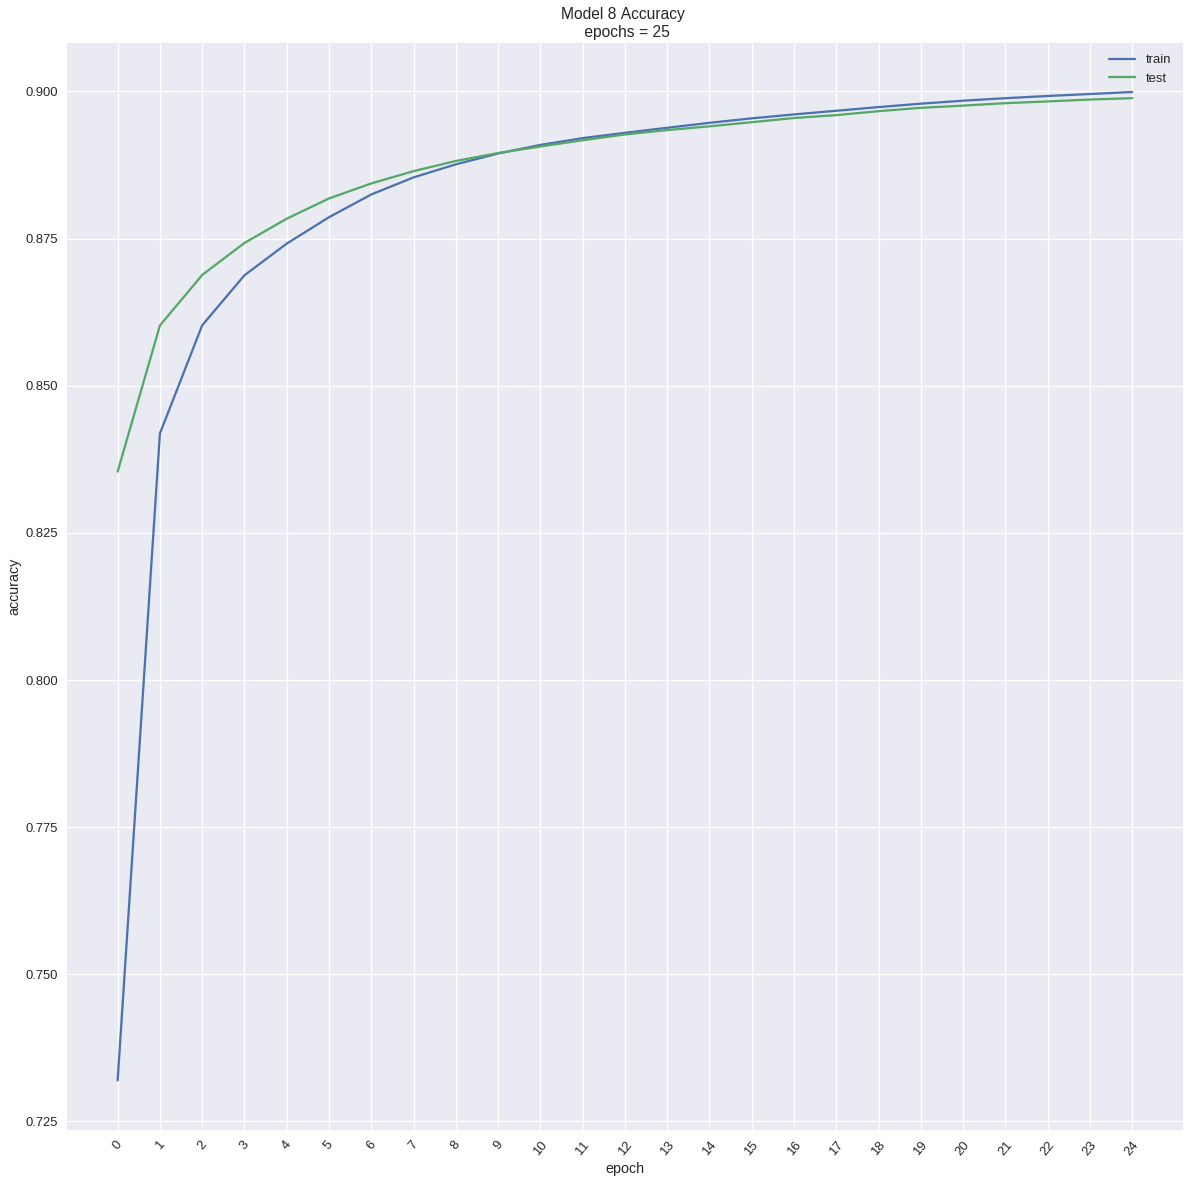

In [35]:
# Plot Accuracy
plot_metrics(training = np.load('model8_acc.npy'),
             validation= np.load('model8_valacc.npy'),
             title = 'Model 8 Accuracy \n epochs = 25', 
             ylabel = 'accuracy',
             xstep = 1)

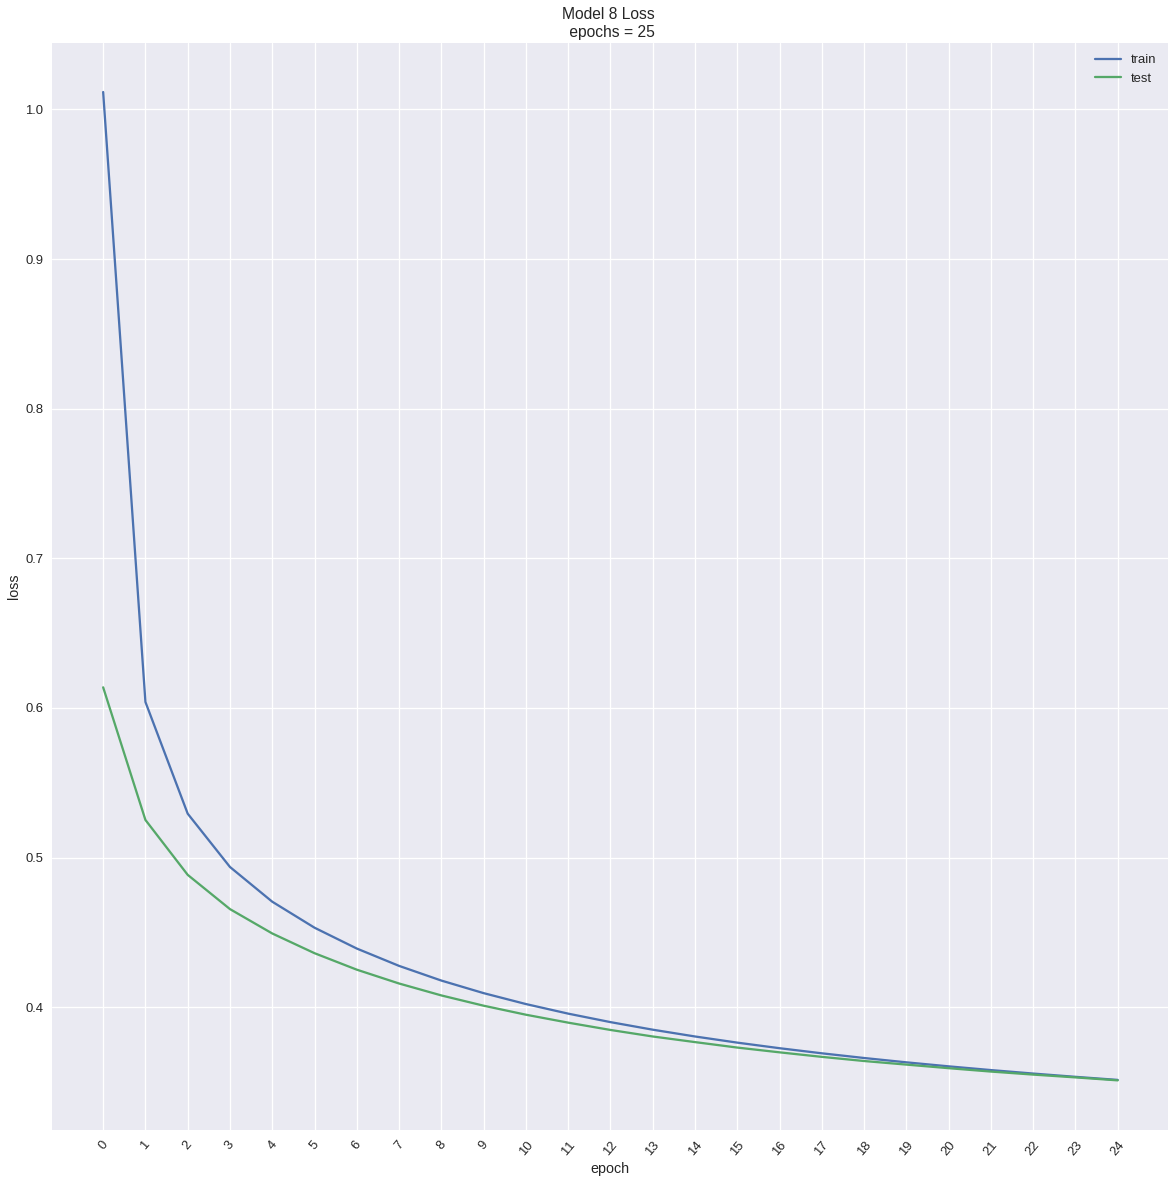

In [36]:
#Plot Loss

plot_metrics(training = np.load('model8_loss.npy'),
             validation= np.load('model8_valloss.npy'),
             title = 'Model 8 Loss \n epochs = 25', 
             ylabel = 'loss',
             xstep = 1)

**Examine Model 8 Predictions Using Testing Data**

In [111]:
# load json and create model

json_file = open("deep_learning_model8.json", 'r')

loaded_model_json = json_file.read()

json_file.close()

loaded_model = model_from_json(loaded_model_json)

# load weights into new model

loaded_model.load_weights("deep_learning_model8_weights.h5")

print("Loaded model from disk")

Loaded model from disk


In [115]:
#Model probability predictions

prob = loaded_model.predict({'cat_input':cat_test, 'num_input':num_test})

# Use argmax to pull the catoegory with highest probability out. 

predicted = prob.argmax(axis=-1)

# Convert one-hot encoded test output data back to categorical data. 

true = out_test.argmax(axis=-1)

#Calculate Confusion Matrix

model8_cfmtx = confusion_matrix(true, predicted)

#Remove empty column [1] - it creates issues when calculating 

model8_cfmtx = np.delete(model8_cfmtx, [1], axis=0)
model8_cfmtx = np.delete(model8_cfmtx, [1], axis=1)

In [116]:
#Calculate accuracy by class

calculate_acc_class(confusion_matrix = model8_cfmtx)

Average accuracy by class is (without NaN & Zeroes): 0.801
Average accuracy by class is (with zeroes): 0.801


In [117]:
predict_eval = eval_confusionmatrix(confusion_matrix = model8_cfmtx)

print('False Positive Rate: ',predict_eval['False Positive Rate'])

print('True Positive Rate: ',predict_eval['True Positive Rate'])

False Positive Rate:  ('Overall:', 0.0028098742056874245, 'Average:', 0.003299303817226744)
True Positive Rate:  ('Overall:', 0.8988445285952528, 'Average:', 0.8013125009167454)


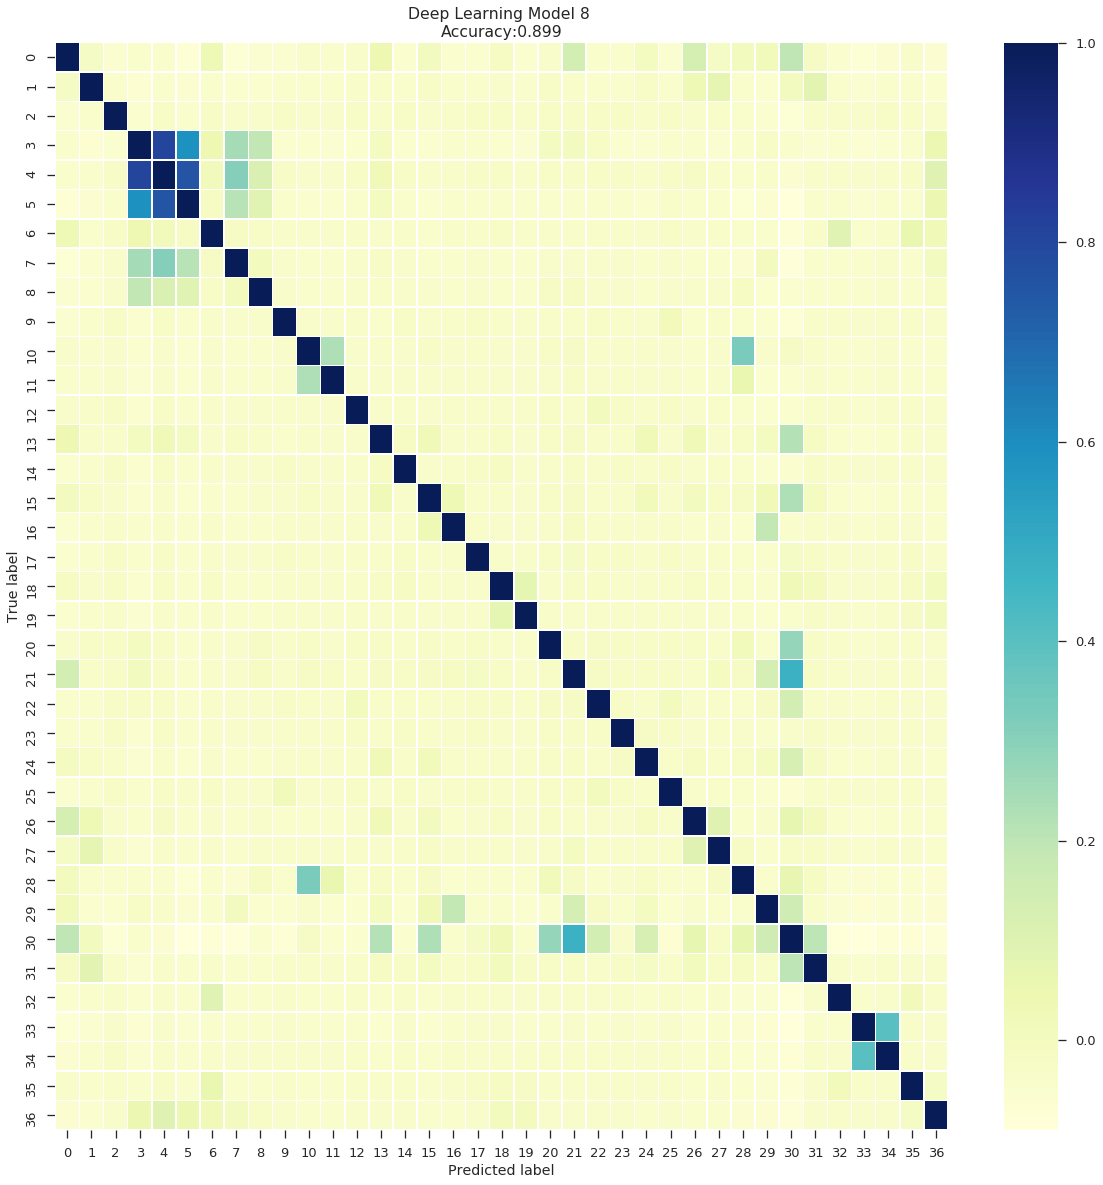

In [118]:
plot_confusion_assoc(confusion_matrix = model8_cfmtx, 
                         title ='Deep Learning Model 8 \nAccuracy:{0:.3f}'.format(accuracy_score(true, predicted)))

## `Parameter Testing`

*Use Model 1 or Baseline Model for parameter testing*

All the models above have used batch size = 128, learning rate = 0.001 and embedding size = 10. I will use cross validation to test different parameters for these. 

In [49]:
#Divide data into 5 k_folds
    
kfold = KFold(n_splits = 5, shuffle=True, random_state=42)
    
# Initialize score list
    
cvscores = []

**Test 1: Batch = 128, LR = 0.0001, Embeddings Output = 10**

In [50]:
for train, test in kfold.split(cat_valid, num_valid, out_valid):
    
    # Categorical Inputs
    
    cat_input = Input(shape=(cat_input_cols,), dtype='int32', name='cat_input')
    
    # Embedding Layer
    
    embed = Embedding(output_dim=10, input_dim=dim, input_length=cat_input_cols)(cat_input)
    
    # A flattening layer will transform the vector sequence into a single vector.
    
    flatten = Flatten()(embed)
    
    #Define numerical features input layer
    
    num_input = Input(shape=(num_cols,), name='num_input')
    
    # Input Layer. Concatenate numerical data & categorical data inputs into one input.
    
    input_layer = keras.layers.concatenate([flatten, num_input])
    
    # Dense Layers
    
    layer1 = Dense(20, activation='relu')(input_layer)
    layer2 = Dense(20, activation='relu')(layer1)
    
    # Output Layer
    
    main_output = Dense(out_cols, activation='softmax', name='main_output')(layer2)
    
    # Model
    
    modelcv = Model(inputs=[cat_input, num_input], outputs=[main_output])
    
    # Optimizer: Adam Gradient Descent
    
    adamgrad = keras.optimizers.Adagrad(lr=0.0001, epsilon=None, decay=0.0)
    
    #Compile Model
    
    modelcv.compile(optimizer=adamgrad, loss={'main_output':'categorical_crossentropy'},
               metrics=['accuracy'])
    
    # Fit the model
    
    modelcv.fit({'cat_input':cat_valid[train],
               'num_input': num_valid[train]}, 
              {'main_output': out_valid[train]},
                  epochs=models_epochs, batch_size = 128,
                  shuffle = True, verbose = 1)
    
    # Evaluate the model
    
    scores = modelcv.evaluate({'cat_input':cat_valid[test], 
                             'num_input': num_valid[test]}, 
                            {'main_output': out_valid[test]}, 
                            batch_size=128, verbose=0)
    
    print("%s: %.2f%%" % (modelcv.metrics_names[1], scores[1]*100))
    
    cvscores.append(scores[1] * 100)

print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

Epoch 1/25
1339820/1339820 [==============================] - 50s 37us/step - loss: 3.4775 - acc: 0.1419
Epoch 2/25
1339820/1339820 [==============================] - 50s 37us/step - loss: 3.2929 - acc: 0.4036
Epoch 3/25
1339820/1339820 [==============================] - 48s 36us/step - loss: 3.1137 - acc: 0.4066
Epoch 4/25
1339820/1339820 [==============================] - 48s 36us/step - loss: 2.9309 - acc: 0.4066
Epoch 5/25
1339820/1339820 [==============================] - 51s 38us/step - loss: 2.7567 - acc: 0.4066
Epoch 6/25
1339820/1339820 [==============================] - 51s 38us/step - loss: 2.5977 - acc: 0.4066
Epoch 7/25
1339820/1339820 [==============================] - 50s 37us/step - loss: 2.4736 - acc: 0.4066
Epoch 8/25
1339820/1339820 [==============================] - 50s 37us/step - loss: 2.3852 - acc: 0.4066
Epoch 9/25
1339820/1339820 [==============================] - 49s 36us/step - loss: 2.3222 - acc: 0.4066
Epoch 10/25
1339820/1339820 [==========================

In [25]:
test1_training = np.array([0.4928, 0.5015, 0.5008, 0.4067,0.5024])
test1_testing = np.array([49.21, 50.12, 50.27, 40.61,50.29])



print('Training: '"%.2f%% (+/- %.2f%%)" % (np.mean(test1_training)*100, np.std(test1_training)**100))
print('Testing: '"%.2f%% (+/- %.2f%%)" % (np.mean(test1_testing), np.std(test1_testing)))

Training: 48.08% (+/- 0.00%)
Testing: 48.10% (+/- 3.77%)


**Test 2: Batch = 32, LR = 0.0001, Embeddings Output = 10**

In [51]:
for train, test in kfold.split(cat_valid, num_valid, out_valid):
    
    # Categorical Inputs
    
    cat_input = Input(shape=(cat_input_cols,), dtype='int32', name='cat_input')
    
    # Embedding Layer
    
    embed = Embedding(output_dim=10, input_dim=dim, input_length=cat_input_cols)(cat_input)
    
    # A flattening layer will transform the vector sequence into a single vector.
    
    flatten = Flatten()(embed)
    
    #Define numerical features input layer
    
    num_input = Input(shape=(num_cols,), name='num_input')
    
    # Input Layer. Concatenate numerical data & categorical data inputs into one input.
    
    input_layer = keras.layers.concatenate([flatten, num_input])
    
    # Dense Layers
    
    layer1 = Dense(20, activation='relu')(input_layer)
    layer2 = Dense(20, activation='relu')(layer1)
    
    # Output Layer
    
    main_output = Dense(out_cols, activation='softmax', name='main_output')(layer2)
    
    # Model
    
    modelcv = Model(inputs=[cat_input, num_input], outputs=[main_output])
    
    # Optimizer: Adam Gradient Descent
    
    adamgrad = keras.optimizers.Adagrad(lr=0.0001, epsilon=None, decay=0.0)
    
    #Compile Model
    
    modelcv.compile(optimizer=adamgrad, loss={'main_output':'categorical_crossentropy'},
               metrics=['accuracy'])
    
    # Fit the model
    
    modelcv.fit({'cat_input':cat_valid[train],
               'num_input': num_valid[train]}, 
              {'main_output': out_valid[train]},
                  epochs=models_epochs, batch_size = 32,
                  shuffle = True, verbose = 1)
    
    # Evaluate the model
    
    scores = modelcv.evaluate({'cat_input':cat_valid[test], 
                             'num_input': num_valid[test]}, 
                            {'main_output': out_valid[test]}, 
                            batch_size=32, verbose=0)
    
    print("%s: %.2f%%" % (modelcv.metrics_names[1], scores[1]*100))
    
    cvscores.append(scores[1] * 100)

print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

Epoch 1/25
1339820/1339820 [==============================] - 131s 97us/step - loss: 3.4216 - acc: 0.3825
Epoch 2/25
1339820/1339820 [==============================] - 136s 101us/step - loss: 3.0198 - acc: 0.4066
Epoch 3/25
1339820/1339820 [==============================] - 131s 98us/step - loss: 2.5858 - acc: 0.4066
Epoch 4/25
1339820/1339820 [==============================] - 131s 98us/step - loss: 2.2838 - acc: 0.4066
Epoch 5/25
1339820/1339820 [==============================] - 130s 97us/step - loss: 2.1438 - acc: 0.4066
Epoch 6/25
1339820/1339820 [==============================] - 132s 98us/step - loss: 2.0619 - acc: 0.4066
Epoch 7/25
1339820/1339820 [==============================] - 131s 97us/step - loss: 1.9976 - acc: 0.4161
Epoch 8/25
1339820/1339820 [==============================] - 132s 98us/step - loss: 1.9395 - acc: 0.4747
Epoch 9/25
1339820/1339820 [==============================] - 133s 99us/step - loss: 1.8854 - acc: 0.4923
Epoch 10/25
1339820/1339820 [================

In [27]:
test2_training = np.array([0.5726, 0.5218, 0.5092, 0.5933,0.5566])
test2_testing = np.array([57.73, 52.59, 51.14, 59.72,56.09])



print('Training: '"%.2f%% (+/- %.2f%%)" % (np.mean(test2_training)*100, np.std(test2_training)**100))
print('Testing: '"%.2f%% (+/- %.2f%%)" % (np.mean(test2_testing), np.std(test2_testing)))

Training: 55.07% (+/- 0.00%)
Testing: 55.45% (+/- 3.18%)


**Test 3: Batch = 32, LR = 0.001, Embeddings Output = 10**

In [52]:
for train, test in kfold.split(cat_valid, num_valid, out_valid):
    
    # Categorical Inputs
    
    cat_input = Input(shape=(cat_input_cols,), dtype='int32', name='cat_input')
    
    # Embedding Layer
    
    embed = Embedding(output_dim=10, input_dim=dim, input_length=cat_input_cols)(cat_input)
    
    # A flattening layer will transform the vector sequence into a single vector.
    
    flatten = Flatten()(embed)
    
    #Define numerical features input layer
    
    num_input = Input(shape=(num_cols,), name='num_input')
    
    # Input Layer. Concatenate numerical data & categorical data inputs into one input.
    
    input_layer = keras.layers.concatenate([flatten, num_input])
    
    # Dense Layers
    
    layer1 = Dense(20, activation='relu')(input_layer)
    layer2 = Dense(20, activation='relu')(layer1)
    
    # Output Layer
    
    main_output = Dense(out_cols, activation='softmax', name='main_output')(layer2)
    
    # Model
    
    modelcv = Model(inputs=[cat_input, num_input], outputs=[main_output])
    
    # Optimizer: Adam Gradient Descent
    
    adamgrad = keras.optimizers.Adagrad(lr=0.001, epsilon=None, decay=0.0)
    
    #Compile Model
    
    modelcv.compile(optimizer=adamgrad, loss={'main_output':'categorical_crossentropy'},
               metrics=['accuracy'])
    
    # Fit the model
    
    modelcv.fit({'cat_input':cat_valid[train],
               'num_input': num_valid[train]}, 
              {'main_output': out_valid[train]},
                  epochs=models_epochs, batch_size = 32,
                  shuffle = True, verbose = 1)
    
    # Evaluate the model
    
    scores = modelcv.evaluate({'cat_input':cat_valid[test], 
                             'num_input': num_valid[test]}, 
                            {'main_output': out_valid[test]}, 
                            batch_size=32, verbose=0)
    
    print("%s: %.2f%%" % (modelcv.metrics_names[1], scores[1]*100))
    
    cvscores.append(scores[1] * 100)

print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

Epoch 1/25
1339820/1339820 [==============================] - 135s 101us/step - loss: 1.3994 - acc: 0.6225
Epoch 2/25
1339820/1339820 [==============================] - 133s 99us/step - loss: 0.9685 - acc: 0.7305
Epoch 3/25
1339820/1339820 [==============================] - 133s 99us/step - loss: 0.8236 - acc: 0.7703
Epoch 4/25
1339820/1339820 [==============================] - 133s 99us/step - loss: 0.7337 - acc: 0.7967
Epoch 5/25
1339820/1339820 [==============================] - 133s 99us/step - loss: 0.6782 - acc: 0.8109
Epoch 6/25
1339820/1339820 [==============================] - 133s 99us/step - loss: 0.6400 - acc: 0.8233
Epoch 7/25
1339820/1339820 [==============================] - 135s 101us/step - loss: 0.6116 - acc: 0.8307
Epoch 8/25
1339820/1339820 [==============================] - 134s 100us/step - loss: 0.5895 - acc: 0.8372
Epoch 9/25
1339820/1339820 [==============================] - 135s 100us/step - loss: 0.5714 - acc: 0.8435
Epoch 10/25
1339820/1339820 [=============

In [28]:
test3_training = np.array([0.8768, 0.8680, 0.8643, 0.8576,0.8549])
test3_testing = np.array([87.62, 86.75, 86.43, 85.72,85.45])



print('Training: '"%.2f%% (+/- %.2f%%)" % (np.mean(test3_training)*100, np.std(test3_training)**100))
print('Testing: '"%.2f%% (+/- %.2f%%)" % (np.mean(test3_testing), np.std(test3_testing)))

Training: 86.43% (+/- 0.00%)
Testing: 86.39% (+/- 0.77%)


**Test 4: Batch = 128, LR = 0.0001, Embeddings Output = 30**

In [53]:
for train, test in kfold.split(cat_valid, num_valid, out_valid):
    
    # Categorical Inputs
    
    cat_input = Input(shape=(cat_input_cols,), dtype='int32', name='cat_input')
    
    # Embedding Layer
    
    embed = Embedding(output_dim=30, input_dim=dim, input_length=cat_input_cols)(cat_input)
    
    # A flattening layer will transform the vector sequence into a single vector.
    
    flatten = Flatten()(embed)
    
    #Define numerical features input layer
    
    num_input = Input(shape=(num_cols,), name='num_input')
    
    # Input Layer. Concatenate numerical data & categorical data inputs into one input.
    
    input_layer = keras.layers.concatenate([flatten, num_input])
    
    # Dense Layers
    
    layer1 = Dense(20, activation='relu')(input_layer)
    layer2 = Dense(20, activation='relu')(layer1)
    
    # Output Layer
    
    main_output = Dense(out_cols, activation='softmax', name='main_output')(layer2)
    
    # Model
    
    modelcv = Model(inputs=[cat_input, num_input], outputs=[main_output])
    
    # Optimizer: Adam Gradient Descent
    
    adamgrad = keras.optimizers.Adagrad(lr=0.0001, epsilon=None, decay=0.0)
    
    #Compile Model
    
    modelcv.compile(optimizer=adamgrad, loss={'main_output':'categorical_crossentropy'},
               metrics=['accuracy'])
    
    # Fit the model
    
    modelcv.fit({'cat_input':cat_valid[train],
               'num_input': num_valid[train]}, 
              {'main_output': out_valid[train]},
                  epochs=models_epochs, batch_size = 128,
                  shuffle = True, verbose = 1)
    
    # Evaluate the model
    
    scores = modelcv.evaluate({'cat_input':cat_valid[test], 
                             'num_input': num_valid[test]}, 
                            {'main_output': out_valid[test]}, 
                            batch_size=128, verbose=0)
    
    print("%s: %.2f%%" % (modelcv.metrics_names[1], scores[1]*100))
    
    cvscores.append(scores[1] * 100)

print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

Epoch 1/25
1339820/1339820 [==============================] - 57s 42us/step - loss: 3.5407 - acc: 0.2647
Epoch 2/25
1339820/1339820 [==============================] - 56s 42us/step - loss: 3.3965 - acc: 0.4147
Epoch 3/25
1339820/1339820 [==============================] - 56s 42us/step - loss: 3.2410 - acc: 0.4142
Epoch 4/25
1339820/1339820 [==============================] - 55s 41us/step - loss: 3.0628 - acc: 0.4116
Epoch 5/25
1339820/1339820 [==============================] - 56s 42us/step - loss: 2.8660 - acc: 0.4080
Epoch 6/25
1339820/1339820 [==============================] - 56s 42us/step - loss: 2.6749 - acc: 0.4079
Epoch 7/25
1339820/1339820 [==============================] - 56s 42us/step - loss: 2.5029 - acc: 0.4080
Epoch 8/25
1339820/1339820 [==============================] - 56s 42us/step - loss: 2.3582 - acc: 0.4082
Epoch 9/25
1339820/1339820 [==============================] - 56s 42us/step - loss: 2.2428 - acc: 0.4086
Epoch 10/25
1339820/1339820 [==========================

In [29]:
test4_training = np.array([0.5476, 0.6369, 0.5245, 0.6599,0.5541])
test4_testing = np.array([54.91, 63.72, 52.89, 52.89,55.50])



print('Training: '"%.2f%% (+/- %.2f%%)" % (np.mean(test4_training)*100, np.std(test4_training)**100))
print('Testing: '"%.2f%% (+/- %.2f%%)" % (np.mean(test4_testing), np.std(test4_testing)))

Training: 58.46% (+/- 0.00%)
Testing: 55.98% (+/- 4.01%)


**Test 5: Batch = 32, LR = 0.0001, Embeddings Output = 30**

In [54]:
for train, test in kfold.split(cat_valid, num_valid, out_valid):
    
    # Categorical Inputs
    
    cat_input = Input(shape=(cat_input_cols,), dtype='int32', name='cat_input')
    
    # Embedding Layer
    
    embed = Embedding(output_dim=30, input_dim=dim, input_length=cat_input_cols)(cat_input)
    
    # A flattening layer will transform the vector sequence into a single vector.
    
    flatten = Flatten()(embed)
    
    #Define numerical features input layer
    
    num_input = Input(shape=(num_cols,), name='num_input')
    
    # Input Layer. Concatenate numerical data & categorical data inputs into one input.
    
    input_layer = keras.layers.concatenate([flatten, num_input])
    
    # Dense Layers
    
    layer1 = Dense(20, activation='relu')(input_layer)
    layer2 = Dense(20, activation='relu')(layer1)
    
    # Output Layer
    
    main_output = Dense(out_cols, activation='softmax', name='main_output')(layer2)
    
    # Model
    
    modelcv = Model(inputs=[cat_input, num_input], outputs=[main_output])
    
    # Optimizer: Adam Gradient Descent
    
    adamgrad = keras.optimizers.Adagrad(lr=0.0001, epsilon=None, decay=0.0)
    
    #Compile Model
    
    modelcv.compile(optimizer=adamgrad, loss={'main_output':'categorical_crossentropy'},
               metrics=['accuracy'])
    
    # Fit the model
    
    modelcv.fit({'cat_input':cat_valid[train],
               'num_input': num_valid[train]}, 
              {'main_output': out_valid[train]},
                  epochs=models_epochs, batch_size = 32,
                  shuffle = True, verbose = 1)
    
    # Evaluate the model
    
    scores = modelcv.evaluate({'cat_input':cat_valid[test], 
                             'num_input': num_valid[test]}, 
                            {'main_output': out_valid[test]}, 
                            batch_size=32, verbose=0)
    
    print("%s: %.2f%%" % (modelcv.metrics_names[1], scores[1]*100))
    
    cvscores.append(scores[1] * 100)

print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

Epoch 1/25
1339820/1339820 [==============================] - 193s 144us/step - loss: 3.1983 - acc: 0.4341
Epoch 2/25
1339820/1339820 [==============================] - 198s 148us/step - loss: 2.4929 - acc: 0.4066
Epoch 3/25
1339820/1339820 [==============================] - 195s 146us/step - loss: 2.1795 - acc: 0.4066
Epoch 4/25
1339820/1339820 [==============================] - 196s 146us/step - loss: 2.0364 - acc: 0.4111
Epoch 5/25
1339820/1339820 [==============================] - 197s 147us/step - loss: 1.9396 - acc: 0.5027
Epoch 6/25
1339820/1339820 [==============================] - 196s 146us/step - loss: 1.8642 - acc: 0.5133
Epoch 7/25
1339820/1339820 [==============================] - 197s 147us/step - loss: 1.7993 - acc: 0.5029
Epoch 8/25
1339820/1339820 [==============================] - 196s 147us/step - loss: 1.7397 - acc: 0.5058
Epoch 9/25
1339820/1339820 [==============================] - 196s 146us/step - loss: 1.6893 - acc: 0.5110
Epoch 10/25
1339820/1339820 [========

In [30]:
test5_training = np.array([0.6397, 0.6968, 0.6692, 0.6754,0.6684])
test5_testing = np.array([64.13, 69.76, 67.15, 67.59,67.00])



print('Training: '"%.2f%% (+/- %.2f%%)" % (np.mean(test5_training)*100, np.std(test5_training)**100))
print('Testing: '"%.2f%% (+/- %.2f%%)" % (np.mean(test5_testing), np.std(test5_testing)))

Training: 66.99% (+/- 0.00%)
Testing: 67.13% (+/- 1.80%)


**Test 6: Batch = 32, LR = 0.001, Embeddings Output = 30**

In [55]:
for train, test in kfold.split(cat_valid, num_valid, out_valid):
    
    # Categorical Inputs
    
    cat_input = Input(shape=(cat_input_cols,), dtype='int32', name='cat_input')
    
    # Embedding Layer
    
    embed = Embedding(output_dim=30, input_dim=dim, input_length=cat_input_cols)(cat_input)
    
    # A flattening layer will transform the vector sequence into a single vector.
    
    flatten = Flatten()(embed)
    
    #Define numerical features input layer
    
    num_input = Input(shape=(num_cols,), name='num_input')
    
    # Input Layer. Concatenate numerical data & categorical data inputs into one input.
    
    input_layer = keras.layers.concatenate([flatten, num_input])
    
    # Dense Layers
    
    layer1 = Dense(20, activation='relu')(input_layer)
    layer2 = Dense(20, activation='relu')(layer1)
    
    # Output Layer
    
    main_output = Dense(out_cols, activation='softmax', name='main_output')(layer2)
    
    # Model
    
    modelcv = Model(inputs=[cat_input, num_input], outputs=[main_output])
    
    # Optimizer: Adam Gradient Descent
    
    adamgrad = keras.optimizers.Adagrad(lr=0.001, epsilon=None, decay=0.0)
    
    #Compile Model
    
    modelcv.compile(optimizer=adamgrad, loss={'main_output':'categorical_crossentropy'},
               metrics=['accuracy'])
    
    # Fit the model
    
    modelcv.fit({'cat_input':cat_valid[train],
               'num_input': num_valid[train]}, 
              {'main_output': out_valid[train]},
                  epochs=models_epochs, batch_size = 32,
                  shuffle = True, verbose = 1)
    
    # Evaluate the model
    
    scores = modelcv.evaluate({'cat_input':cat_valid[test], 
                             'num_input': num_valid[test]}, 
                            {'main_output': out_valid[test]}, 
                            batch_size=32, verbose=0)
    
    print("%s: %.2f%%" % (modelcv.metrics_names[1], scores[1]*100))
    
    cvscores.append(scores[1] * 100)

print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

Epoch 1/25
1339820/1339820 [==============================] - 201s 150us/step - loss: 1.1820 - acc: 0.6779
Epoch 2/25
1339820/1339820 [==============================] - 201s 150us/step - loss: 0.7978 - acc: 0.7828
Epoch 3/25
1339820/1339820 [==============================] - 202s 151us/step - loss: 0.6895 - acc: 0.8185
Epoch 4/25
1339820/1339820 [==============================] - 200s 149us/step - loss: 0.6311 - acc: 0.8354
Epoch 5/25
1339820/1339820 [==============================] - 200s 149us/step - loss: 0.5950 - acc: 0.8429
Epoch 6/25
1339820/1339820 [==============================] - 201s 150us/step - loss: 0.5701 - acc: 0.8468
Epoch 7/25
1339820/1339820 [==============================] - 202s 150us/step - loss: 0.5513 - acc: 0.8503
Epoch 8/25
1339820/1339820 [==============================] - 200s 149us/step - loss: 0.5365 - acc: 0.8533
Epoch 9/25
1339820/1339820 [==============================] - 199s 149us/step - loss: 0.5246 - acc: 0.8561
Epoch 10/25
1339820/1339820 [========

In [32]:
test6_training = np.array([0.8801, 0.8797, 0.8853, 0.8798,0.8776])
test6_testing = np.array([87.95, 87.82, 88.55, 87.90,87.63])



print('Training: '"%.2f%% (+/- %.2f%%)" % (np.mean(test6_training)*100, np.std(test6_training)**100))
print('Testing: '"%.2f%% (+/- %.2f%%)" % (np.mean(test6_testing), np.std(test6_testing)))

Training: 88.05% (+/- 0.00%)
Testing: 87.97% (+/- 0.31%)


# ***FINAL DEEP NEURAL NETWORK MODEL***

## `Naive Oversampling of Minority Classes`

**Training Data**

In [57]:
#Create X array array by concatenating numerical and categorical inputs.

x_train = np.concatenate((num_train, cat_train), axis = 1)

In [58]:
#Convert output(y) from one-hot encoding back to one categorical array

y_train = np.argmax(out_train, axis=1)

In [59]:
df_y = pd.DataFrame(y_train)

pd.value_counts(df_y[0].values, sort=True)

5     5942398
10    1440762
26    1278384
22     940765
21     919979
31     644002
23     595807
4      461932
7      388769
19     354824
8      301347
9      280044
32     173248
16     160822
11     124717
18     122941
14     104432
29      72385
27      70417
24      43128
37      40433
34      26377
6       23635
36      17047
12      16549
13      15253
30      14931
0       13244
3        8693
2        8054
17       4388
15       3974
35       2126
28       2065
20       2063
33        986
25        114
1          15
dtype: int64

In [60]:
# Resample any category with less than 100k observations

sampling_strategy = {29:100000,27:100000,24:100000,37:100000,34:100000,6:100000,
                     36:100000,12:100000,13:100000,30:100000,0:100000,3:100000,
                     2:100000,17:100000,15:100000,35:100000,28:100000,20:100000,
                     33:100000,25:100000,1:100000}

In [61]:
%%time

#Resample specific categories in the minority classes.

rd_sampler = RandomOverSampler(sampling_strategy = sampling_strategy, random_state=0)

x_rdsampler, y_rdsampler = rd_sampler.fit_resample(x_train, y_train)

CPU times: user 8.08 s, sys: 2.84 s, total: 10.9 s
Wall time: 10.9 s


In [62]:
cat_train_rdsampling = x_rdsampler[:,[8,9,10,11,12,13]]

num_train_rdsampling = x_rdsampler[:,[0,1,2,3,4,5,6,7]]

In [63]:
#Convert output variable back to one-hot encoded array

out_train_rdsampling = np.max(y_rdsampler) + 1

out_train_rdsampling = np.eye(out_train_rdsampling)[y_rdsampler]

In [64]:
print('num_input shape |', 'Train:',num_train_rdsampling.shape)

print('cat_input shape |', 'Train:',cat_train_rdsampling.shape)

print('out_input shape |', 'Train:',out_train_rdsampling.shape)

num_input shape | Train: (16335173, 8)
cat_input shape | Train: (16335173, 6)
out_input shape | Train: (16335173, 38)


*Only training data will be re-sampled. If test and validation data is re-sampled we will bleed training information into data that should be hidden to the model*

## Neural Network Model 1

LR = 0.0001, Embedding Dimensions = 30, Epochs = 50, Dropout Rate = 0.20, Batch = 64, Oversampling = Yes

In [92]:
# Categorical Inputs

cat_input = Input(shape=(cat_input_cols,), dtype='int32', name='cat_input')

# Embedding Layer

embed = Embedding(output_dim=30, input_dim=dim, input_length=cat_input_cols)(cat_input)

# A flattening layer will transform the vector sequence into a single vector.

flatten = Flatten()(embed)

#Define numerical features input layer

num_input = Input(shape=(num_cols,), name='num_input')

# Input Layer. Concatenate numerical data & categorical data inputs into one input.

input_layer = keras.layers.concatenate([flatten, num_input])

# Dense Layers

dropout1 = Dropout(0.2)(input_layer)
layer1 = Dense(20, activation='relu')(dropout1)
dropout2 = Dropout(0.2)(layer1)
layer2 = Dense(20, activation='relu')(dropout2)

# Output Layer

main_output = Dense(out_cols, activation='softmax', name='main_output')(layer2)

# Model

final_model = Model(inputs=[cat_input, num_input], outputs=[main_output])

# Optimizer: Adam Gradient Descent

adamgrad = keras.optimizers.Adagrad(lr=0.0001, epsilon=None, decay=0.0)

#Compile Model

final_model.compile(optimizer=adamgrad, loss={'main_output':'categorical_crossentropy'},metrics=['accuracy'])

In [93]:
%%time

# Fit Model Function

final_model_hist = final_model.fit({'cat_input':cat_train_rdsampling, 
                                    'num_input': num_train_rdsampling}, 
                                   {'main_output': out_train_rdsampling},
                                   validation_data = testing_data,
                                   epochs=50, 
                                   batch_size = 64,
                                   shuffle = True, 
                                   verbose = 2)

Train on 16335173 samples, validate on 319005 samples
Epoch 1/50
 - 1429s - loss: 2.5060 - acc: 0.4023 - val_loss: 1.7921 - val_acc: 0.4800
Epoch 2/50
 - 1429s - loss: 1.9762 - acc: 0.4595 - val_loss: 1.5377 - val_acc: 0.5722
Epoch 3/50
 - 1430s - loss: 1.8169 - acc: 0.5124 - val_loss: 1.4030 - val_acc: 0.6299
Epoch 4/50
 - 1425s - loss: 1.7217 - acc: 0.5422 - val_loss: 1.3155 - val_acc: 0.6810
Epoch 5/50
 - 1435s - loss: 1.6540 - acc: 0.5618 - val_loss: 1.2507 - val_acc: 0.6831
Epoch 6/50
 - 1430s - loss: 1.5995 - acc: 0.5762 - val_loss: 1.1971 - val_acc: 0.6874
Epoch 7/50
 - 1428s - loss: 1.5530 - acc: 0.5890 - val_loss: 1.1514 - val_acc: 0.6925
Epoch 8/50
 - 1425s - loss: 1.5125 - acc: 0.5995 - val_loss: 1.1123 - val_acc: 0.6967
Epoch 9/50
 - 1429s - loss: 1.4772 - acc: 0.6078 - val_loss: 1.0785 - val_acc: 0.7056
Epoch 10/50
 - 1427s - loss: 1.4461 - acc: 0.6143 - val_loss: 1.0493 - val_acc: 0.7131
Epoch 11/50
 - 1430s - loss: 1.4186 - acc: 0.6199 - val_loss: 1.0238 - val_acc: 0.716

**Save Final Model**

In [94]:
# Save model history metrics

np.save('final_model_valloss.npy', final_model_hist.history['val_loss'])
np.save('final_model_loss.npy', final_model_hist.history['loss'])
np.save('final_model_acc.npy', final_model_hist.history['acc'])
np.save('final_model_valacc.npy', final_model_hist.history['val_acc'])

In [95]:
# serialize model to JSON

model_json = final_model.to_json()

with open("deep_learning_final_model.json", "w") as json_file:
    json_file.write(model_json)

    # serialize weights to HDF5

    final_model.save_weights("deep_learning_final_model_weights.h5")

print("Saved model to disk")

Saved model to disk


**Accuracy of Training and Testing**

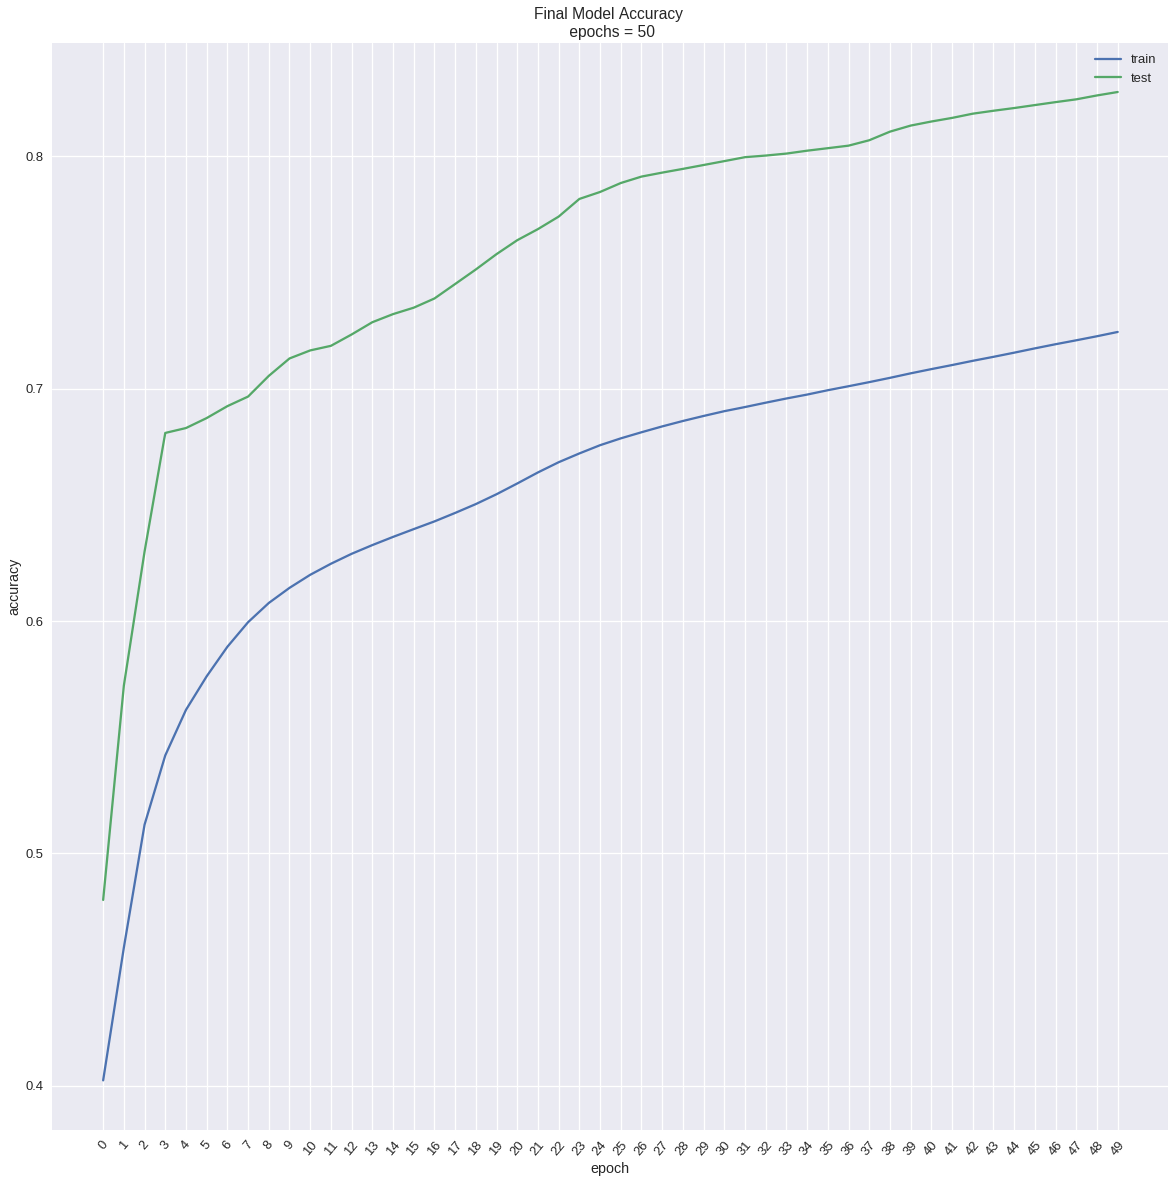

In [104]:
# Plot Accuracy
plot_metrics(training = np.load('final_model_acc.npy'),
             validation= np.load('final_model_valacc.npy'),
             title = 'Final Model Accuracy \n epochs = 50', 
             ylabel = 'accuracy',
             xstep = 1,epochs = 50)

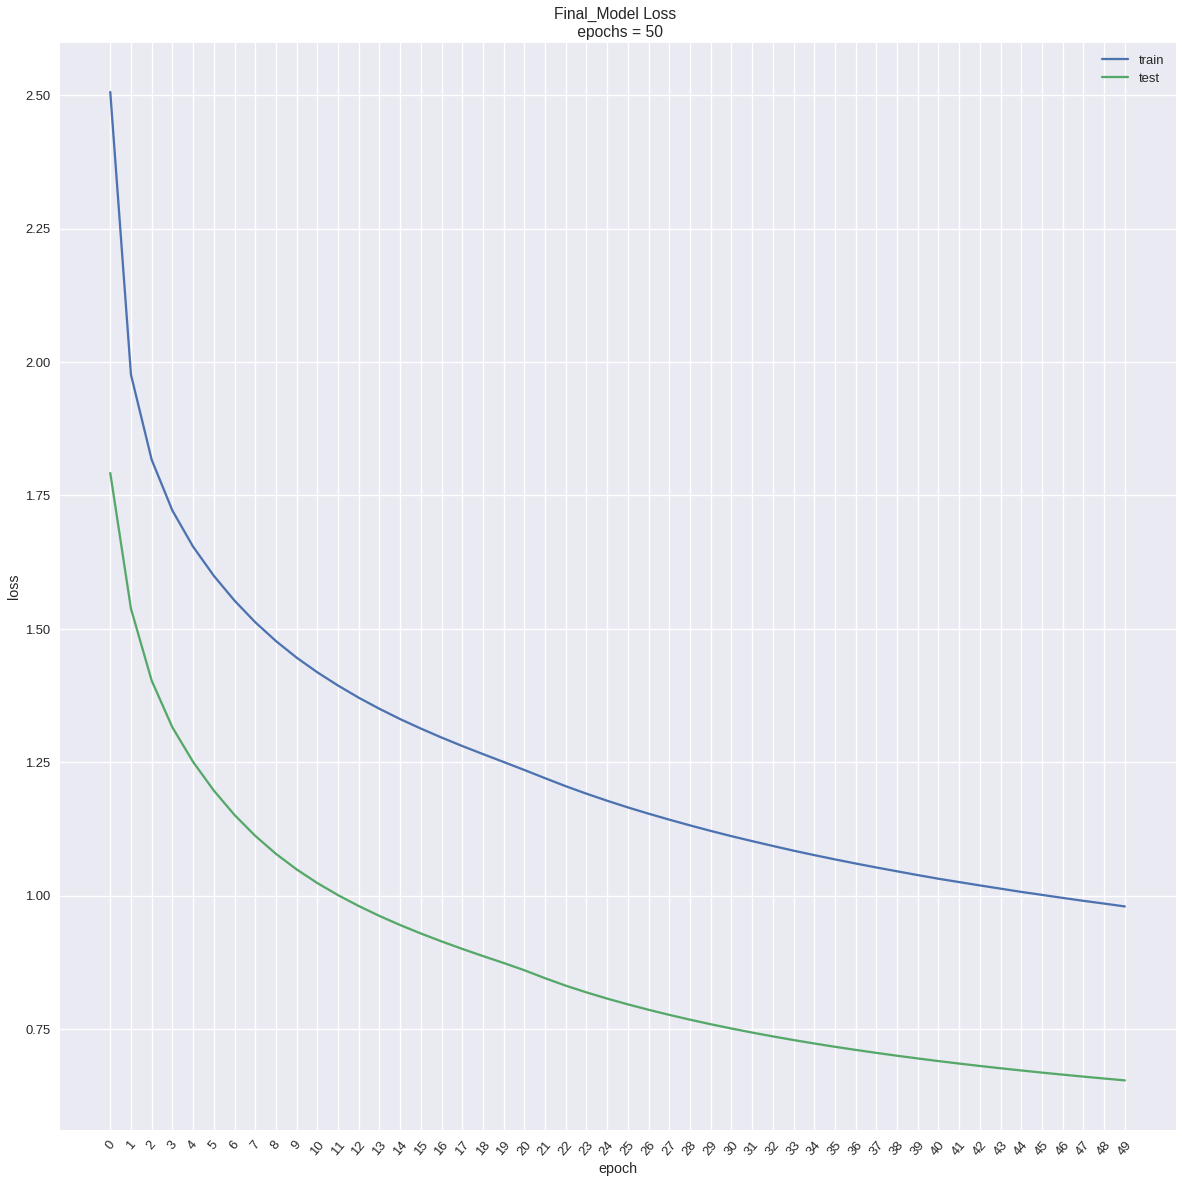

In [105]:
#Plot Loss

plot_metrics(training = np.load('final_model_loss.npy'),
             validation= np.load('final_model_valloss.npy'),
             title = 'Final_Model Loss \n epochs = 50', 
             ylabel = 'loss',
             xstep = 1,epochs = 50)

**K-Fold Cross Validation**

In [77]:
#Divide data into 5 k_folds
    
kfold = KFold(n_splits = 5, shuffle=True, random_state=42)
    
# Initialize score list
    
cvscores = []

In [124]:
for train, test in kfold.split(cat_valid, num_valid, out_valid):
    
    #Prepare re-sampling (only training data)
    
    x_valid = np.concatenate((num_valid[train], cat_valid[train]), axis = 1)
    
    #Convert output(y) from one-hot encoding back to one categorical array
    
    y_valid = np.argmax(out_valid[train], axis=1)
    
    #Random Re-Sampling
    
    rd_sampler = RandomOverSampler(sampling_strategy = sampling_strategy, random_state=0)
    xvalid_rdsampler, yvalid_rdsampler = rd_sampler.fit_resample(x_valid, y_valid)
    
    #Validation Training Data
    
    cat_valid_rdsampling = xvalid_rdsampler[:,[8,9,10,11,12,13]]
    
    num_valid_rdsampling = xvalid_rdsampler[:,[0,1,2,3,4,5,6,7]]
    
    out_valid_rdsampling = np.max(yvalid_rdsampler) + 1
    
    out_valid_rdsampling = np.eye(out_valid_rdsampling)[yvalid_rdsampler]
    
    #-------MODEL STARTS HERE-----------
    
    # Categorical Inputs
    
    cat_input = Input(shape=(cat_input_cols,), dtype='int32', name='cat_input')
    
    # Embedding Layer
    
    embed = Embedding(output_dim=30, input_dim=dim, input_length=cat_input_cols)(cat_input)
    
    # A flattening layer will transform the vector sequence into a single vector.
    
    flatten = Flatten()(embed)
    
    #Define numerical features input layer
    
    num_input = Input(shape=(num_cols,), name='num_input')
    
    # Input Layer. Concatenate numerical data & categorical data inputs into one input.
    
    input_layer = keras.layers.concatenate([flatten, num_input])
    
    # Dense Layers
    
    dropout1 = Dropout(0.2)(input_layer)
    layer1 = Dense(20, activation='relu')(dropout1)
    dropout2 = Dropout(0.2)(layer1)
    layer2 = Dense(20, activation='relu')(dropout2)
    
    # Model
    
    modelcv = Model(inputs=[cat_input, num_input], outputs=[main_output])
    
    # Optimizer: Adam Gradient Descent
    
    adamgrad = keras.optimizers.Adagrad(lr=0.0001, epsilon=None, decay=0.0)
    
    #Compile Model
    
    modelcv.compile(optimizer=adamgrad, loss={'main_output':'categorical_crossentropy'},
               metrics=['accuracy'])
    
    # Fit the model
    
    modelcv.fit({'cat_input':cat_valid_rdsampling,
                 'num_input': num_valid_rdsampling}, 
                {'main_output': out_valid_rdsampling},
                  epochs=50, batch_size = 64,
                  shuffle = True, verbose = 1)
    
    # Evaluate the model
    
    scores = modelcv.evaluate({'cat_input':cat_valid[test], 
                               'num_input': num_valid[test]}, 
                              {'main_output': out_valid[test]}, 
                              batch_size=64, verbose=0)
    
    print("%s: %.2f%%" % (modelcv.metrics_names[1], scores[1]*100))
    
    cvscores.append(scores[1] * 100)

print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

Epoch 1/25
3404494/3404494 [==============================] - 128s 38us/step - loss: 1.9593 - acc: 0.5151
Epoch 2/25
3404494/3404494 [==============================] - 128s 37us/step - loss: 1.0036 - acc: 0.7598
Epoch 3/25
3404494/3404494 [==============================] - 126s 37us/step - loss: 0.7838 - acc: 0.8079
Epoch 4/25
3404494/3404494 [==============================] - 127s 37us/step - loss: 0.6837 - acc: 0.8310
Epoch 5/25
3404494/3404494 [==============================] - 127s 37us/step - loss: 0.6241 - acc: 0.8435
Epoch 6/25
3404494/3404494 [==============================] - 127s 37us/step - loss: 0.5837 - acc: 0.8520
Epoch 7/25
3404494/3404494 [==============================] - 126s 37us/step - loss: 0.5543 - acc: 0.8581
Epoch 8/25
3404494/3404494 [==============================] - 126s 37us/step - loss: 0.5316 - acc: 0.8630
Epoch 9/25
3404494/3404494 [==============================] - 126s 37us/step - loss: 0.5134 - acc: 0.8681
Epoch 10/25
3404494/3404494 [=================

In [125]:
#Display CV Results

final_model_cv_results = cvscores

final_model_cv_results

[84.18742816197411,
 84.65495365057933,
 82.16417130634429,
 82.77708945976039,
 83.09922228380387]

In [126]:
# Save model cv 

np.save('final_model_cv_accuracy.npy', model7_cv_results)

**Examine Final Model Predictions Using Testing Data**

In [106]:
# load json and create model

json_file = open("deep_learning_final_model.json", 'r')

loaded_model_json = json_file.read()

json_file.close()

loaded_model = model_from_json(loaded_model_json)

# load weights into new model

loaded_model.load_weights("deep_learning_final_model_weights.h5")

print("Loaded model from disk")

Loaded model from disk


In [111]:
#Model probability predictions

prob = loaded_model.predict({'cat_input':cat_test, 'num_input':num_test})

# Use argmax to pull the catoegory with highest probability out. 

predicted = prob.argmax(axis=-1)

# Convert one-hot encoded test output data back to categorical data. 

true = out_test.argmax(axis=-1)

#Calculate Confusion Matrix

final_model_cfmtx = confusion_matrix(true, predicted)

#Remove empty column [1] - it creates issues when calculating 

final_model_cfmtx = np.delete(final_model_cfmtx, [1], axis=0)
final_model_cfmtx = np.delete(final_model_cfmtx, [1], axis=1)

In [112]:
#Calculate accuracy by class

calculate_acc_class(confusion_matrix = final_model_cfmtx)

Average accuracy by class is (without NaN & Zeroes): 0.497
Average accuracy by class is (with zeroes): 0.336


In [113]:
predict_eval = eval_confusionmatrix(confusion_matrix = final_model_cfmtx)

print('False Positive Rate: ',predict_eval['False Positive Rate'])

print('True Positive Rate: ',predict_eval['True Positive Rate'])

False Positive Rate:  ('Overall:', 0.004778772099621712, 'Average:', 0.005697451232054573)
True Positive Rate:  ('Overall:', 0.8279642044136184, 'Average:', 0.3355075137513731)


/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:60: RuntimeWarning: invalid value encountered in true_divide


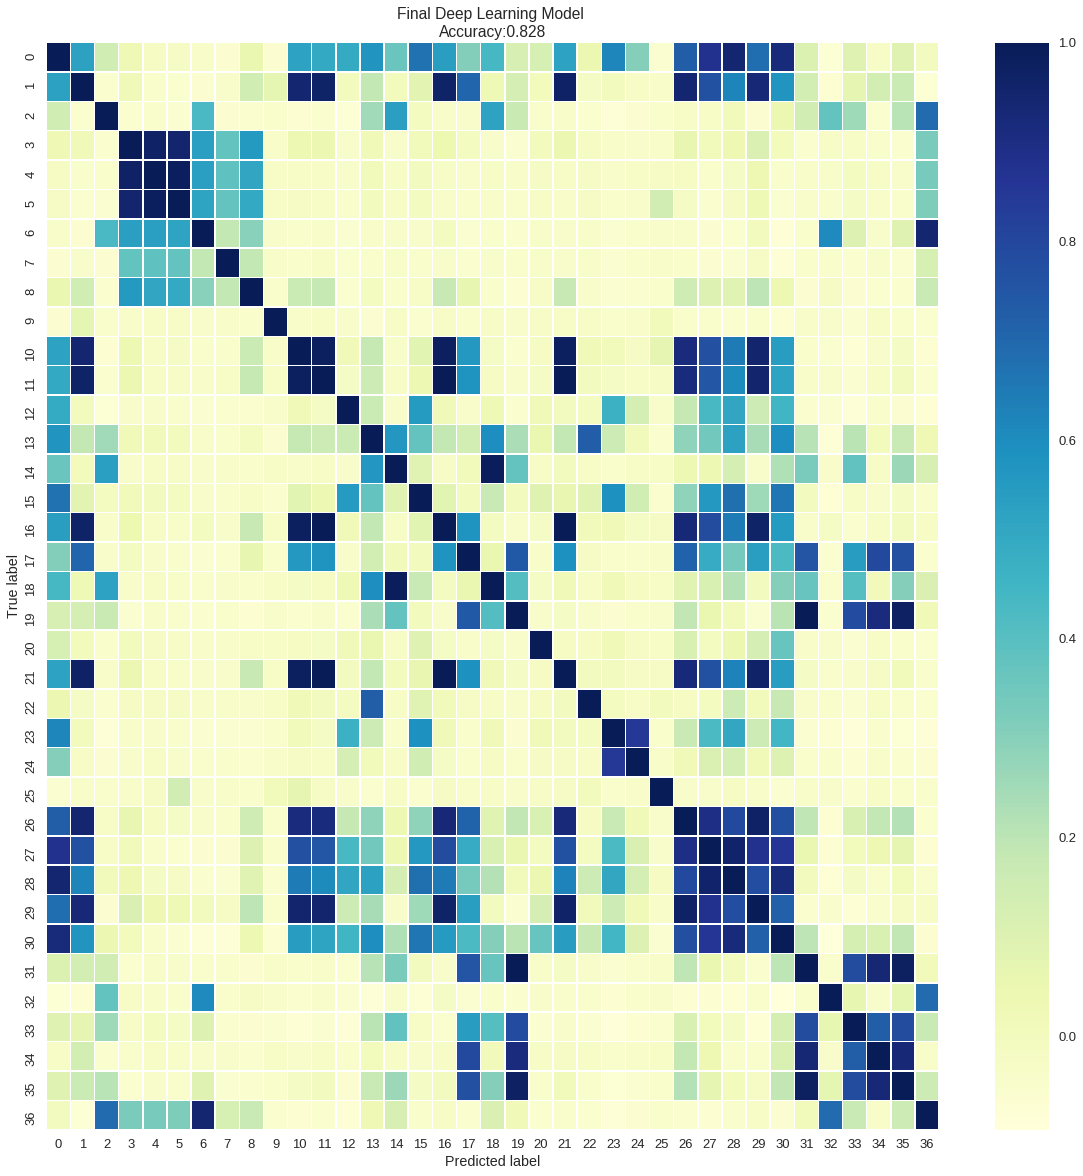

In [114]:
plot_confusion_assoc(confusion_matrix = final_model_cfmtx, 
                         title ='Final Deep Learning Model \nAccuracy:{0:.3f}'.format(accuracy_score(true, predicted)))

## Neural Network Model 2

LR = 0.001, Embedding Dimensions = 30, Epochs = 50, Dropout Rate = 0.20, Batch = 64, Oversampling = Yes

In [98]:
# Categorical Inputs

cat_input = Input(shape=(cat_input_cols,), dtype='int32', name='cat_input')

# Embedding Layer

embed = Embedding(output_dim=30, input_dim=dim, input_length=cat_input_cols)(cat_input)

# A flattening layer will transform the vector sequence into a single vector.

flatten = Flatten()(embed)

#Define numerical features input layer

num_input = Input(shape=(num_cols,), name='num_input')

# Input Layer. Concatenate numerical data & categorical data inputs into one input.

input_layer = keras.layers.concatenate([flatten, num_input])

# Dense Layers

dropout1 = Dropout(0.2)(input_layer)
layer1 = Dense(20, activation='relu')(dropout1)
dropout2 = Dropout(0.2)(layer1)
layer2 = Dense(20, activation='relu')(dropout2)

# Output Layer

main_output = Dense(out_cols, activation='softmax', name='main_output')(layer2)

# Model

final_model2 = Model(inputs=[cat_input, num_input], outputs=[main_output])

# Optimizer: Adam Gradient Descent

adamgrad = keras.optimizers.Adagrad(lr=0.001, epsilon=None, decay=0.0)

#Compile Model

final_model2.compile(optimizer=adamgrad, loss={'main_output':'categorical_crossentropy'},metrics=['accuracy'])

In [99]:
%%time

# Fit Model Function

final_model2_hist = final_model2.fit({'cat_input':cat_train_rdsampling, 
                                    'num_input': num_train_rdsampling}, 
                                   {'main_output': out_train_rdsampling},
                                   validation_data = testing_data,
                                   epochs=50, 
                                   batch_size = 64,
                                   shuffle = True, 
                                   verbose = 2)

Train on 16335173 samples, validate on 319005 samples
Epoch 1/50
 - 1415s - loss: 1.0998 - acc: 0.6952 - val_loss: 0.5779 - val_acc: 0.8420
Epoch 2/50
 - 1415s - loss: 0.7777 - acc: 0.7814 - val_loss: 0.5008 - val_acc: 0.8693
Epoch 3/50
 - 1420s - loss: 0.6971 - acc: 0.8074 - val_loss: 0.4662 - val_acc: 0.8781
Epoch 4/50
 - 1416s - loss: 0.6536 - acc: 0.8205 - val_loss: 0.4451 - val_acc: 0.8824
Epoch 5/50
 - 1417s - loss: 0.6234 - acc: 0.8292 - val_loss: 0.4304 - val_acc: 0.8857
Epoch 6/50
 - 1416s - loss: 0.6018 - acc: 0.8353 - val_loss: 0.4198 - val_acc: 0.8878
Epoch 7/50
 - 1417s - loss: 0.5857 - acc: 0.8399 - val_loss: 0.4109 - val_acc: 0.8890
Epoch 8/50
 - 1416s - loss: 0.5729 - acc: 0.8432 - val_loss: 0.4039 - val_acc: 0.8907
Epoch 9/50
 - 1415s - loss: 0.5625 - acc: 0.8461 - val_loss: 0.3980 - val_acc: 0.8918
Epoch 10/50
 - 1415s - loss: 0.5536 - acc: 0.8485 - val_loss: 0.3929 - val_acc: 0.8928
Epoch 11/50
 - 1418s - loss: 0.5458 - acc: 0.8505 - val_loss: 0.3886 - val_acc: 0.893

In [100]:
# Save model history metrics

np.save('final_model2_valloss.npy', final_model2_hist.history['val_loss'])
np.save('final_model2_loss.npy', final_model2_hist.history['loss'])
np.save('final_model2_acc.npy', final_model2_hist.history['acc'])
np.save('final_model2_valacc.npy', final_model2_hist.history['val_acc'])

In [101]:
# serialize model to JSON

model_json = final_model2.to_json()

with open("deep_learning_final_model2.json", "w") as json_file:
    json_file.write(model_json)

    # serialize weights to HDF5

    final_model2.save_weights("deep_learning_final_model2_weights.h5")

print("Saved model to disk")

Saved model to disk


**Save Final Model**

**Accuracy of Training and Testing**

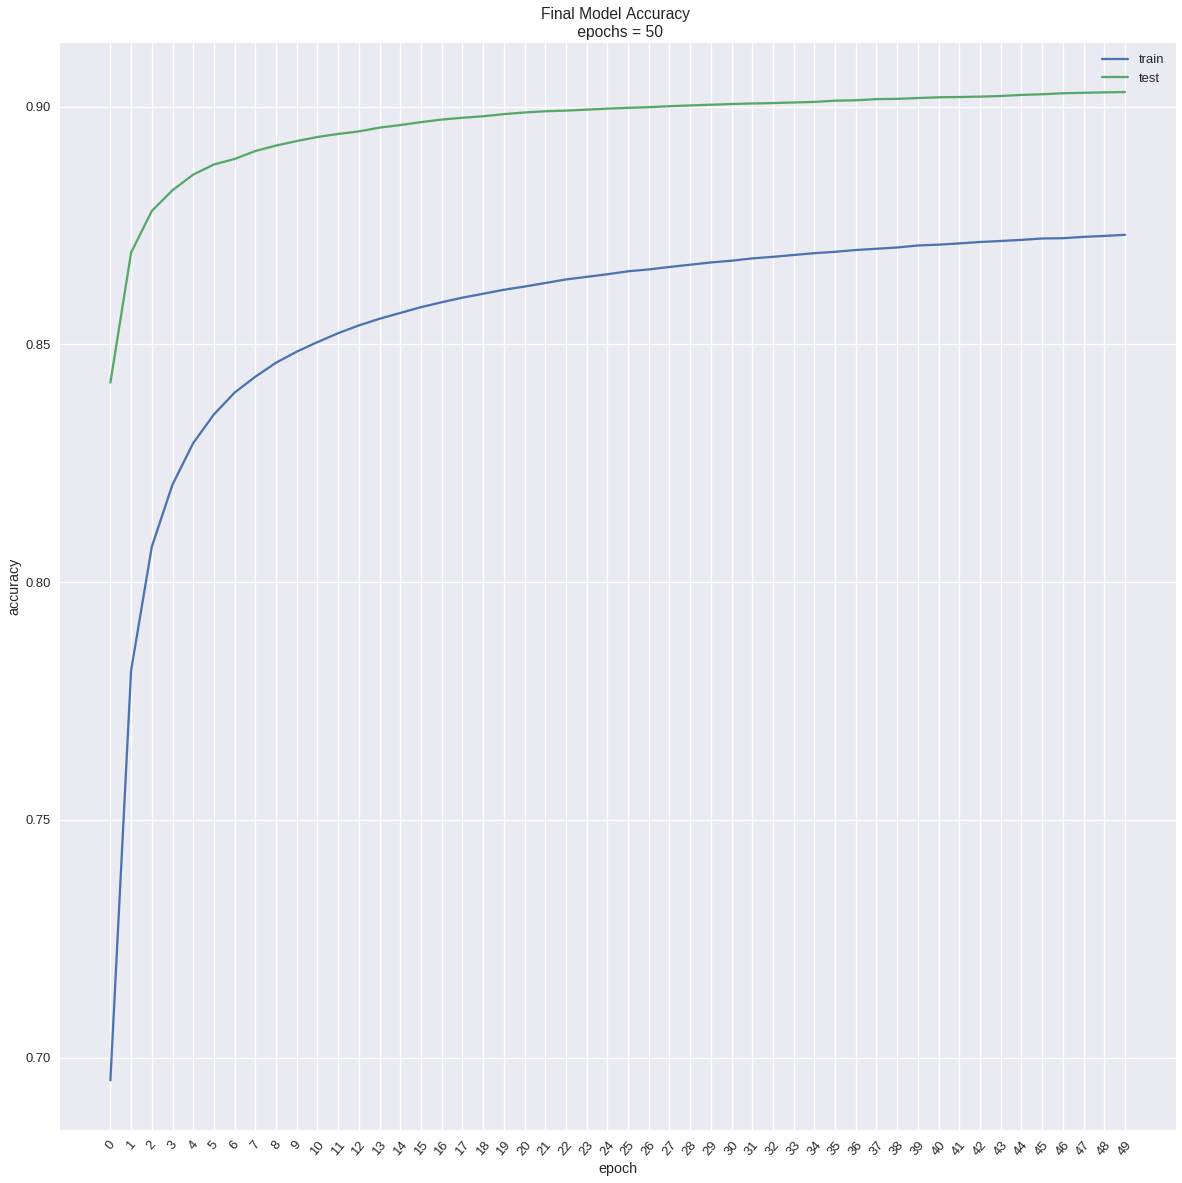

In [115]:
# Plot Accuracy
plot_metrics(training = np.load('final_model2_acc.npy'),
             validation= np.load('final_model2_valacc.npy'),
             title = 'Final Model Accuracy \n epochs = 50', 
             ylabel = 'accuracy',
             xstep = 1,epochs = 50)

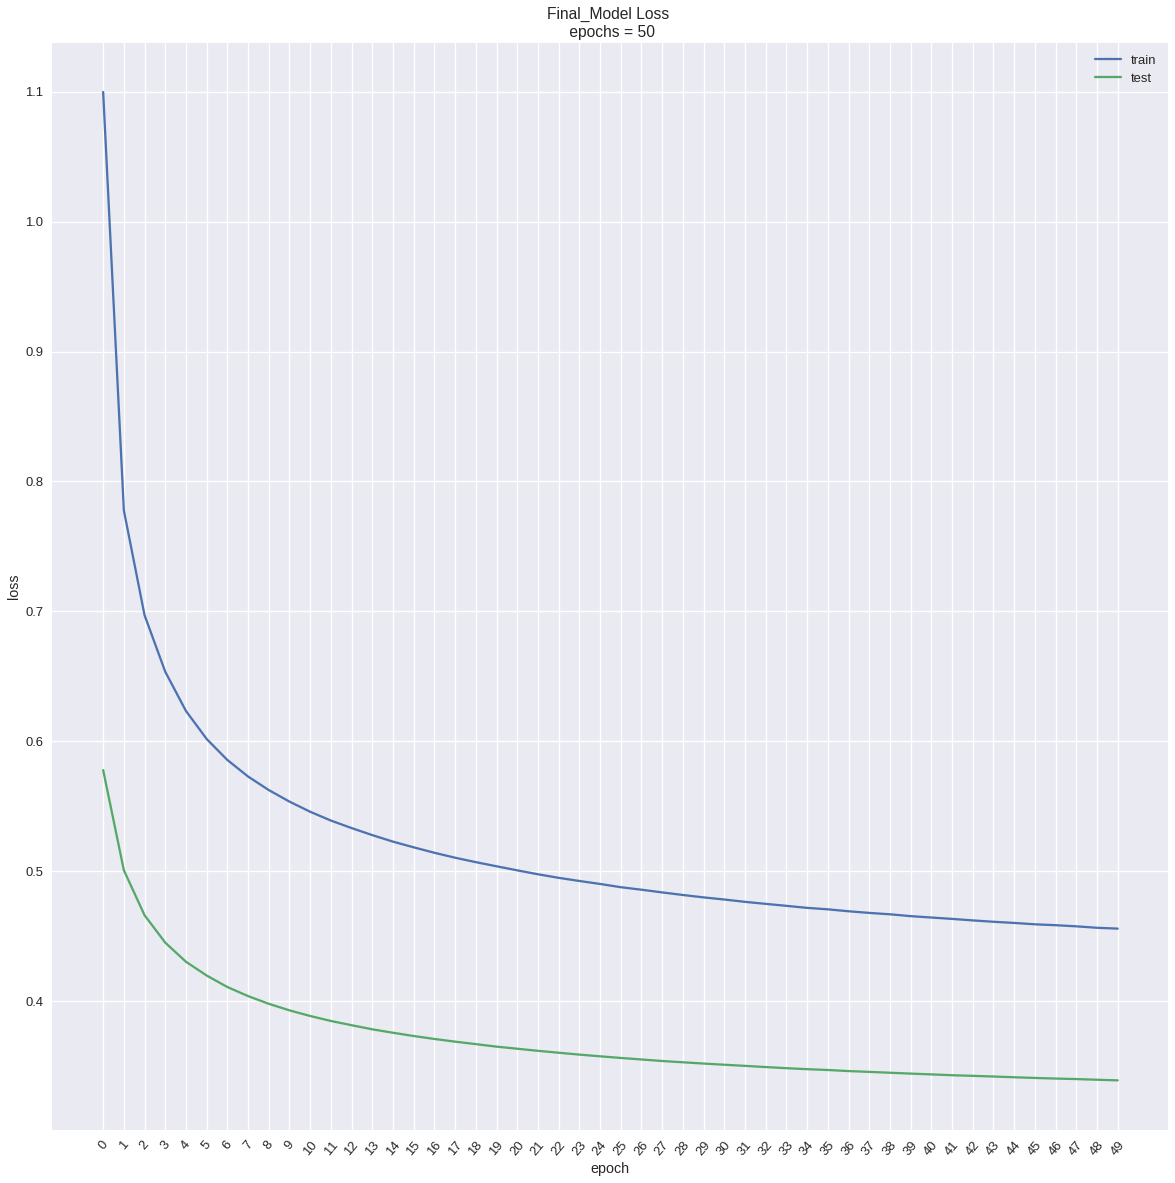

In [116]:
#Plot Loss

plot_metrics(training = np.load('final_model2_loss.npy'),
             validation= np.load('final_model2_valloss.npy'),
             title = 'Final_Model Loss \n epochs = 50', 
             ylabel = 'loss',
             xstep = 1, epochs = 50)

**K-Fold Cross Validation**

In [135]:
#Divide data into 5 k_folds
    
kfold = KFold(n_splits = 5, shuffle=True, random_state=42)
    
# Initialize score list
    
cvscores = []

In [ ]:
for train, test in kfold.split(cat_valid, num_valid, out_valid):
    
    #Prepare re-sampling (only training data)
    
    x_valid = np.concatenate((num_valid[train], cat_valid[train]), axis = 1)
    
    #Convert output(y) from one-hot encoding back to one categorical array
    
    y_valid = np.argmax(out_valid[train], axis=1)
    
    #Random Re-Sampling
    
    rd_sampler = RandomOverSampler(sampling_strategy = sampling_strategy, random_state=0)
    xvalid_rdsampler, yvalid_rdsampler = rd_sampler.fit_resample(x_valid, y_valid)
    
    #Validation Training Data
    
    cat_valid_rdsampling = xvalid_rdsampler[:,[8,9,10,11,12,13]]
    
    num_valid_rdsampling = xvalid_rdsampler[:,[0,1,2,3,4,5,6,7]]
    
    out_valid_rdsampling = np.max(yvalid_rdsampler) + 1
    
    out_valid_rdsampling = np.eye(out_valid_rdsampling)[yvalid_rdsampler]
    
    #-------MODEL STARTS HERE-----------
    
    # Categorical Inputs
    
    cat_input = Input(shape=(cat_input_cols,), dtype='int32', name='cat_input')
    
    # Embedding Layer
    
    embed = Embedding(output_dim=30, input_dim=dim, input_length=cat_input_cols)(cat_input)
    
    # A flattening layer will transform the vector sequence into a single vector.
    
    flatten = Flatten()(embed)
    
    #Define numerical features input layer
    
    num_input = Input(shape=(num_cols,), name='num_input')
    
    # Input Layer. Concatenate numerical data & categorical data inputs into one input.
    
    input_layer = keras.layers.concatenate([flatten, num_input])
    
    # Dense Layers
    
    dropout1 = Dropout(0.2)(input_layer)
    layer1 = Dense(20, activation='relu')(dropout1)
    dropout2 = Dropout(0.2)(layer1)
    layer2 = Dense(20, activation='relu')(dropout2)
    
    # Output Layer
    
    main_output = Dense(out_cols, activation='softmax', name='main_output')(layer2)
    
    # Model
    
    modelcv = Model(inputs=[cat_input, num_input], outputs=[main_output])
    
    # Optimizer: Adam Gradient Descent
    
    adamgrad = keras.optimizers.Adagrad(lr=0.001, epsilon=None, decay=0.0)
    
    #Compile Model
    
    modelcv.compile(optimizer=adamgrad, loss={'main_output':'categorical_crossentropy'},
               metrics=['accuracy'])
    
    # Fit the model
    
    modelcv.fit({'cat_input':cat_valid_rdsampling,
                 'num_input': num_valid_rdsampling}, 
              {'main_output': out_valid_rdsampling},
                  epochs=50, batch_size = 64,
                  shuffle = True, verbose = 1)
    
    # Evaluate the model
    
    scores = modelcv.evaluate({'cat_input':cat_valid[test], 
                               'num_input': num_valid[test]}, 
                              {'main_output': out_valid[test]}, 
                              batch_size=64, verbose=0)
    
    print("%s: %.2f%%" % (modelcv.metrics_names[1], scores[1]*100))
    
    cvscores.append(scores[1] * 100)

print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

Epoch 1/50
1329664/3404494 [==========>...................] - ETA: 3:00 - loss: 2.3505 - acc: 0.3776

In [ ]:
#Display CV Results

final_model2_cv_results = cvscores

final_model2_cv_results

In [ ]:
# Save model cv 

np.save('final_model2_cv_accuracy.npy', final_model2_cv_results)

**Examine Final Model Predictions Using Testing Data**

In [118]:
# load json and create model

json_file = open("deep_learning_final_model2.json", 'r')

loaded_model_json = json_file.read()

json_file.close()

loaded_model = model_from_json(loaded_model_json)

# load weights into new model

loaded_model.load_weights("deep_learning_final_model2_weights.h5")

print("Loaded model from disk")

Loaded model from disk


In [122]:
#Model probability predictions

prob = loaded_model.predict({'cat_input':cat_test, 'num_input':num_test})

# Use argmax to pull the catoegory with highest probability out. 

predicted = prob.argmax(axis=-1)

# Convert one-hot encoded test output data back to categorical data. 

true = out_test.argmax(axis=-1)

#Calculate Confusion Matrix

final_model_cfmtx = confusion_matrix(true, predicted)

#Remove empty column [1] - it creates issues when calculating 

final_model_cfmtx = np.delete(final_model_cfmtx, [1], axis=0)
final_model_cfmtx = np.delete(final_model_cfmtx, [1], axis=1)

In [123]:
#Calculate accuracy by class

calculate_acc_class(confusion_matrix = final_model_cfmtx)

Average accuracy by class is (without NaN & Zeroes): 0.84
Average accuracy by class is (with zeroes): 0.84


In [124]:
predict_eval = eval_confusionmatrix(confusion_matrix = final_model_cfmtx)

print('False Positive Rate: ',predict_eval['False Positive Rate'])

print('True Positive Rate: ',predict_eval['True Positive Rate'])

False Positive Rate:  ('Overall:', 0.002690469870847693, 'Average:', 0.003177505357092284)
True Positive Rate:  ('Overall:', 0.903143084649483, 'Average:', 0.840422059476155)


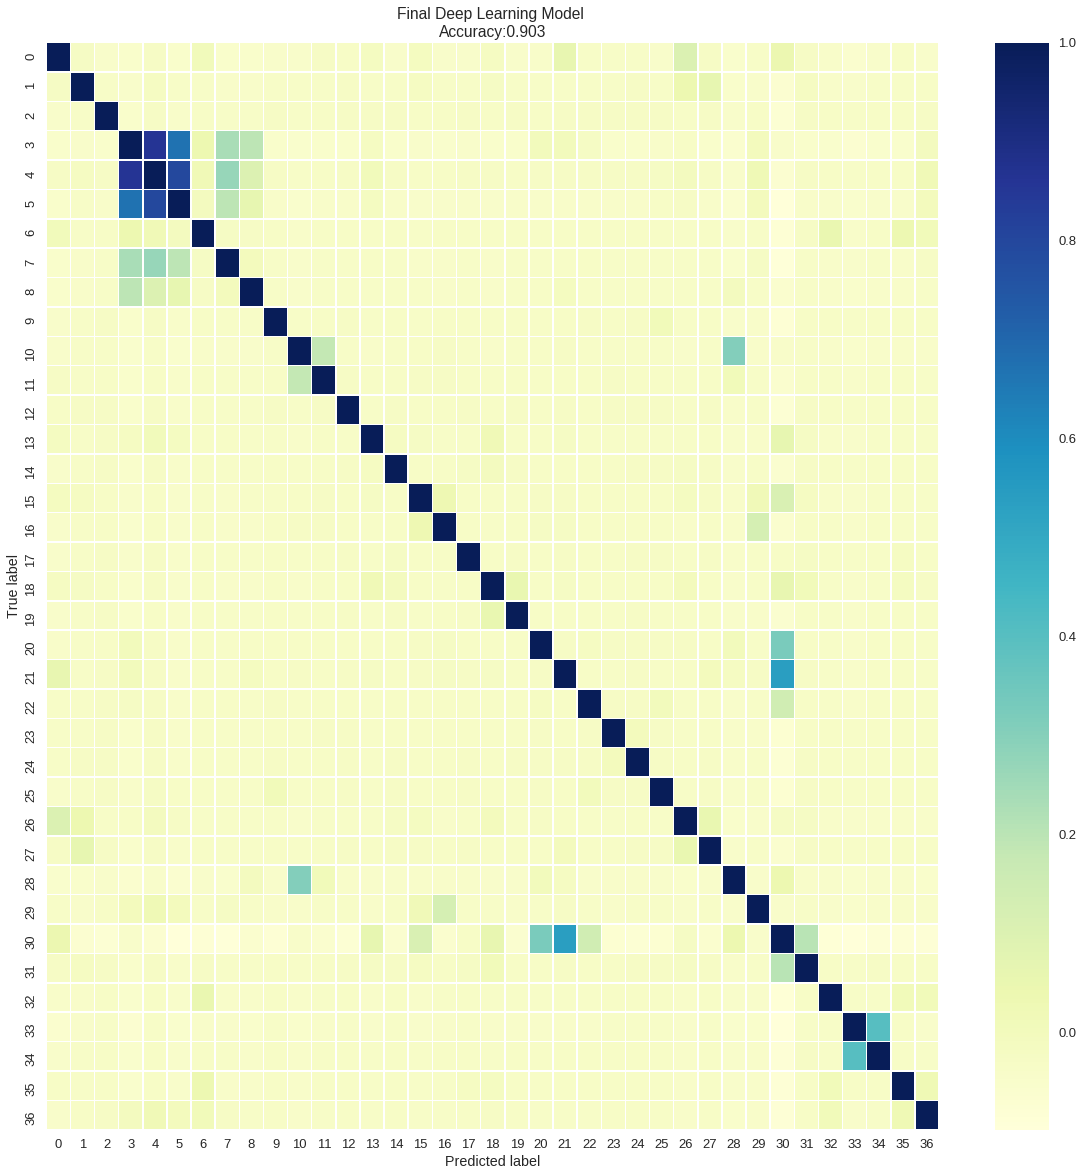

In [125]:
plot_confusion_assoc(confusion_matrix = final_model_cfmtx, 
                         title ='Final Deep Learning Model \nAccuracy:{0:.3f}'.format(accuracy_score(true, predicted)))